# 基于机器学习的南京地区特定天气现象及要素精准预报研究

## 1 准备工作

### 1.1 环境设置与数据导入

In [10]:
# 忽略警告信息
import warnings
warnings.filterwarnings('ignore')

# 数据处理库
import pandas as pd
import numpy as np

# 数据可视化库
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('ggplot')  # 设置绘图风格

mpl.rcParams['font.family'] = 'SimHei'  # 设置中文字体
mpl.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题

# 机器学习相关库
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 常用分类器
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 常用回归器
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# 深度学习相关库
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 设置随机种子，保证结果可复现
np.random.seed(42)
tf.random.set_seed(42)

# 导入南京天气数据集
data_path = '../data/nanjing_weather_1973_2024.csv'
df = pd.read_csv(data_path)

# 将DATE列设为索引
df.set_index('DATE', inplace=True)

print("数据集导入成功！")
print(f"数据集形状: {df.shape}")

数据集导入成功！
数据集形状: (18957, 13)


### 1.2 数据概览

In [11]:
print(f"前5行数据:{df.head()}\n")
df.info()

前5行数据:          DEWP  FRSHTT   GUST   MAX   MIN  MXSPD   PRCP     SLP   SNDP    STP  \
DATE                                                                            
1973/1/1  23.8       0  999.9  42.8  33.8   15.5   0.00  1026.8  999.9  999.9   
1973/1/2  15.0       0  999.9  48.2  23.0   13.6   0.00  1031.1  999.9  999.9   
1973/1/3  20.0       0  999.9  37.4  23.0    9.7   0.00  1030.5  999.9  999.9   
1973/1/4  24.1       0  999.9  39.2  26.6    7.8   0.00  1032.7  999.9  999.9   
1973/1/5  34.1   10000  999.9  46.4  30.2    9.7  99.99  1033.3  999.9  999.9   

          TEMP  VISIB  WDSP  
DATE                         
1973/1/1  37.9    9.3   8.3  
1973/1/2  30.2    9.8   6.7  
1973/1/3  29.9    6.9   2.8  
1973/1/4  34.5   10.9   5.8  
1973/1/5  41.0    7.2   6.8  

<class 'pandas.core.frame.DataFrame'>
Index: 18957 entries, 1973/1/1 to 2024/12/31
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEWP    18957 non-nu

### 1.3 数据清洗与预处理

#### 1.3.1 处理特定缺失值标签(将特定的缺失值标签替换为 NaN)

数据集中，特定的数值代表缺失值，下面将这些特定的缺失值代码统一替换为NumPy的 np.nan。需要处理的列及其代码如下：
- TEMP, MAX, MIN, DEWP, SLP, STP: 9999.9
- WDSP, MXSPD, GUST, SNDP, VISIB: 999.9
- PRCP: 99.99

In [12]:
# 创建数据副本以避免修改原始数据
df_weather = df.copy()

print("处理前的缺失值统计：")
print(df_weather.isnull().sum())
print("\n" + "="*50 + "\n")

# 定义需要替换的特定缺失值代码
# TEMP, MAX, MIN, DEWP, SLP: 9999.9
columns_9999_9 = ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP']
for col in columns_9999_9:
    if col in df_weather.columns:
        count_before = (df_weather[col] == 9999.9).sum()
        df_weather[col] = df_weather[col].replace(9999.9, np.nan)
        print(f"{col}: 替换了 {count_before} 个 9999.9 值")

# WDSP, MXSPD, GUST, SNDP, VISIB, STP: 999.9
columns_999_9 = ['WDSP', 'MXSPD', 'GUST', 'SNDP', 'VISIB', 'STP']
for col in columns_999_9:
    if col in df_weather.columns:
        count_before = (df_weather[col] == 999.9).sum()
        df_weather[col] = df_weather[col].replace(999.9, np.nan)
        print(f"{col}: 替换了 {count_before} 个 999.9 值")

# PRCP: 99.99
if 'PRCP' in df_weather.columns:
    count_before = (df_weather['PRCP'] == 99.99).sum()
    df_weather['PRCP'] = df_weather['PRCP'].replace(99.99, np.nan)
    print(f"PRCP: 替换了 {count_before} 个 99.99 值")

print("\n" + "="*50 + "\n")
print("处理后的缺失值统计：")
missing_stats = df_weather.isnull().sum()
print(missing_stats)

print("\n缺失值比例：")
missing_percentage = (df_weather.isnull().sum() / len(df_weather)) * 100
missing_summary = pd.DataFrame({
    '缺失值数量': missing_stats,
    '缺失值比例(%)': missing_percentage.round(2)
})
print(missing_summary[missing_summary['缺失值数量'] > 0])

print(f"\n数据集形状: {df_weather.shape}")
print("特定缺失值代码替换完成！")

处理前的缺失值统计：
DEWP      0
FRSHTT    0
GUST      0
MAX       0
MIN       0
MXSPD     0
PRCP      0
SLP       0
SNDP      0
STP       0
TEMP      0
VISIB     0
WDSP      0
dtype: int64


TEMP: 替换了 0 个 9999.9 值
MAX: 替换了 0 个 9999.9 值
MIN: 替换了 1 个 9999.9 值
DEWP: 替换了 3 个 9999.9 值
SLP: 替换了 35 个 9999.9 值
WDSP: 替换了 1 个 999.9 值
MXSPD: 替换了 15 个 999.9 值
GUST: 替换了 17687 个 999.9 值
SNDP: 替换了 18925 个 999.9 值
VISIB: 替换了 0 个 999.9 值
STP: 替换了 7133 个 999.9 值
PRCP: 替换了 447 个 99.99 值


处理后的缺失值统计：
DEWP          3
FRSHTT        0
GUST      17687
MAX           0
MIN           1
MXSPD        15
PRCP        447
SLP          35
SNDP      18925
STP        7133
TEMP          0
VISIB         0
WDSP          1
dtype: int64

缺失值比例：
       缺失值数量  缺失值比例(%)
DEWP       3      0.02
GUST   17687     93.30
MIN        1      0.01
MXSPD     15      0.08
PRCP     447      2.36
SLP       35      0.18
SNDP   18925     99.83
STP     7133     37.63
WDSP       1      0.01

数据集形状: (18957, 13)
特定缺失值代码替换完成！


#### 1.3.2 缺失值填充或删除

针对 df_weather DataFrame中的缺失值(np.nan)，进行填充或删除：
- 对于具有时间连续性的气象参数（DEWP, SLP, WDSP, MXSPD, MIN），使用时间序列插值法（interpolate(method='time')）填充；
- 对于PRCP和SNDP的NaN，假设其代表无降水/积雪，请填充为0；
- 对于GUST，由于缺失值过多，直接删去该特征；
- 对于STP，由于其为未进行海拔修正的大气压值，也直接删去该特征。

In [13]:
# 针对 df_weather DataFrame中的缺失值(np.nan)进行填充处理
print("开始处理缺失值...")
print("\n处理前的缺失值统计：")
print(df_weather.isnull().sum())
print("\n" + "="*60 + "\n")

# 1. 删除缺失值过多的特征：GUST 和 STP
features_to_drop = ['GUST', 'STP']
existing_features_to_drop = [col for col in features_to_drop if col in df_weather.columns]

if existing_features_to_drop:
    print(f"删除特征: {existing_features_to_drop}")
    for col in existing_features_to_drop:
        missing_count = df_weather[col].isnull().sum()
        missing_pct = (missing_count / len(df_weather)) * 100
        print(f"  - {col}: 缺失值 {missing_count} 个 ({missing_pct:.2f}%)")
    
    df_weather = df_weather.drop(columns=existing_features_to_drop)
    print(f"删除后数据集形状: {df_weather.shape}")
else:
    print("未找到需要删除的特征")

print("\n" + "-"*40 + "\n")

# 2. 对PRCP和SNDP的NaN填充为0（假设代表无降水/积雪）
zero_fill_columns = ['PRCP', 'SNDP']
for col in zero_fill_columns:
    if col in df_weather.columns:
        missing_before = df_weather[col].isnull().sum()
        if missing_before > 0:
            df_weather[col] = df_weather[col].fillna(0)
            print(f"{col}: 将 {missing_before} 个缺失值填充为 0")
        else:
            print(f"{col}: 无缺失值需要处理")
    else:
        print(f"{col}: 列不存在于数据集中")

print("\n" + "-"*40 + "\n")

# 3. 对具有时间连续性的气象参数使用时间序列插值法
# 首先确保索引是datetime类型
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("索引转换完成")

# 对时间连续性参数进行插值
time_series_columns = ['DEWP', 'SLP', 'WDSP', 'MXSPD', 'MIN']
existing_ts_columns = [col for col in time_series_columns if col in df_weather.columns]

print(f"对以下列进行时间序列插值: {existing_ts_columns}")
for col in existing_ts_columns:
    missing_before = df_weather[col].isnull().sum()
    if missing_before > 0:
        # 使用时间序列插值法
        df_weather[col] = df_weather[col].interpolate(method='time')
        missing_after = df_weather[col].isnull().sum()
        filled_count = missing_before - missing_after
        print(f"  - {col}: 插值填充了 {filled_count} 个缺失值，剩余 {missing_after} 个")
        
        # 如果还有剩余的缺失值（通常在序列开头或结尾），使用前向/后向填充
        if missing_after > 0:
            df_weather[col] = df_weather[col].fillna(method='bfill').fillna(method='ffill')
            final_missing = df_weather[col].isnull().sum()
            additional_filled = missing_after - final_missing
            print(f"    额外使用前向/后向填充了 {additional_filled} 个缺失值")
    else:
        print(f"  - {col}: 无缺失值需要处理")

print("\n" + "="*60 + "\n")
print("缺失值处理完成！")
print("\n最终缺失值统计：")
final_missing = df_weather.isnull().sum()
print(final_missing)

if final_missing.sum() > 0:
    print("\n仍有缺失值的列：")
    remaining_missing = final_missing[final_missing > 0]
    for col, count in remaining_missing.items():
        pct = (count / len(df_weather)) * 100
        print(f"  - {col}: {count} 个缺失值 ({pct:.2f}%)")
else:
    print("\n✅ 所有缺失值已处理完成！")

print(f"\n最终数据集形状: {df_weather.shape}")
print(f"最终特征列: {list(df_weather.columns)}")

开始处理缺失值...

处理前的缺失值统计：
DEWP          3
FRSHTT        0
GUST      17687
MAX           0
MIN           1
MXSPD        15
PRCP        447
SLP          35
SNDP      18925
STP        7133
TEMP          0
VISIB         0
WDSP          1
dtype: int64


删除特征: ['GUST', 'STP']
  - GUST: 缺失值 17687 个 (93.30%)
  - STP: 缺失值 7133 个 (37.63%)
删除后数据集形状: (18957, 11)

----------------------------------------

PRCP: 将 447 个缺失值填充为 0
SNDP: 将 18925 个缺失值填充为 0

----------------------------------------

转换索引为datetime类型...
索引转换完成
对以下列进行时间序列插值: ['DEWP', 'SLP', 'WDSP', 'MXSPD', 'MIN']
  - DEWP: 插值填充了 3 个缺失值，剩余 0 个
  - SLP: 插值填充了 35 个缺失值，剩余 0 个
  - WDSP: 插值填充了 1 个缺失值，剩余 0 个
  - MXSPD: 插值填充了 15 个缺失值，剩余 0 个
  - MIN: 插值填充了 1 个缺失值，剩余 0 个


缺失值处理完成！

最终缺失值统计：
DEWP      0
FRSHTT    0
MAX       0
MIN       0
MXSPD     0
PRCP      0
SLP       0
SNDP      0
TEMP      0
VISIB     0
WDSP      0
dtype: int64

✅ 所有缺失值已处理完成！

最终数据集形状: (18957, 11)
最终特征列: ['DEWP', 'FRSHTT', 'MAX', 'MIN', 'MXSPD', 'PRCP', 'SLP', 'SNDP', 'TEMP', 'VIS

#### 1.3.3 FRSHTT特征解析

下面对 df_weather DataFrame中的 FRSHTT 列进行处理：
1. 确保所有值为字符串，并向左补'0'至6位。
2. 基于此6位字符串，创建6个新的二元特征列：Fog, Rain, Snow, Hail, Thunder, Tornado，值为0或1。
3. 删去原来的 FRSHTT 列

In [14]:
# 对 FRSHTT 列进行特征解析处理
print("开始处理 FRSHTT 特征...")
print(f"\n处理前数据集形状: {df_weather.shape}")
print(f"FRSHTT 列的数据类型: {df_weather['FRSHTT'].dtype}")
print(f"FRSHTT 列的前10个值: {df_weather['FRSHTT'].head(10).tolist()}")
print("\n" + "="*60 + "\n")

# 1. 确保所有值为字符串，并向左补'0'至6位
print("步骤1: 将 FRSHTT 转换为6位字符串格式...")
df_weather['FRSHTT_str'] = df_weather['FRSHTT'].astype(str).str.zfill(6)

print(f"转换后的前10个值: {df_weather['FRSHTT_str'].head(10).tolist()}")
print(f"字符串长度检查: {df_weather['FRSHTT_str'].str.len().unique()}")

print("\n" + "-"*40 + "\n")

# 2. 基于6位字符串创建6个新的二元特征列
print("步骤2: 创建6个二元特征列...")

# 定义特征名称和对应的位置
weather_features = {
    'Fog': 0,      # 第1位：雾
    'Rain': 1,     # 第2位：雨
    'Snow': 2,     # 第3位：雪
    'Hail': 3,     # 第4位：冰雹
    'Thunder': 4,  # 第5位：雷暴
    'Tornado': 5   # 第6位：龙卷风
}

# 创建二元特征列
for feature_name, position in weather_features.items():
    # 提取对应位置的字符并转换为整数
    df_weather[feature_name] = df_weather['FRSHTT_str'].str[position].astype(int)
    print(f"创建特征 {feature_name} (位置 {position+1})")

print("\n所有二元特征创建完成！")

print("\n" + "-"*40 + "\n")

# 显示前几行数据
print("处理后的前10行数据（包含新特征）:")
display_columns = ['FRSHTT', 'FRSHTT_str'] + list(weather_features.keys())
print(df_weather[display_columns].head(10))

print("\n" + "-"*40 + "\n")

# 显示新列的值计数
print("各二元特征的值计数统计:")
for feature_name in weather_features.keys():
    value_counts = df_weather[feature_name].value_counts().sort_index()
    total_count = len(df_weather)
    print(f"\n{feature_name}:")
    for value, count in value_counts.items():
        percentage = (count / total_count) * 100
        print(f"  {value}: {count:,} 次 ({percentage:.2f}%)")

print("\n" + "-"*40 + "\n")

# 3. 删除原来的 FRSHTT 列和临时的 FRSHTT_str 列
print("步骤3: 删除原始 FRSHTT 列和临时字符串列...")
columns_to_drop = ['FRSHTT', 'FRSHTT_str']
df_weather = df_weather.drop(columns=columns_to_drop)

print(f"已删除列: {columns_to_drop}")
print(f"\n处理后数据集形状: {df_weather.shape}")
print(f"当前特征列: {list(df_weather.columns)}")

print("\n" + "="*60 + "\n")
print("✅ FRSHTT 特征解析处理完成！")

# 显示最终的数据概览
print("\n最终数据集概览:")
print(f"数据集形状: {df_weather.shape}")
print(f"新增的天气现象特征: {list(weather_features.keys())}")
print("\n前5行数据:")
print(df_weather.head())

开始处理 FRSHTT 特征...

处理前数据集形状: (18957, 11)
FRSHTT 列的数据类型: int64
FRSHTT 列的前10个值: [0, 0, 0, 0, 10000, 11000, 1000, 0, 100000, 10000]


步骤1: 将 FRSHTT 转换为6位字符串格式...
转换后的前10个值: ['000000', '000000', '000000', '000000', '010000', '011000', '001000', '000000', '100000', '010000']
字符串长度检查: [6]

----------------------------------------

步骤2: 创建6个二元特征列...
创建特征 Fog (位置 1)
创建特征 Rain (位置 2)
创建特征 Snow (位置 3)
创建特征 Hail (位置 4)
创建特征 Thunder (位置 5)
创建特征 Tornado (位置 6)

所有二元特征创建完成！

----------------------------------------

处理后的前10行数据（包含新特征）:
            FRSHTT FRSHTT_str  Fog  Rain  Snow  Hail  Thunder  Tornado
DATE                                                                  
1973-01-01       0     000000    0     0     0     0        0        0
1973-01-02       0     000000    0     0     0     0        0        0
1973-01-03       0     000000    0     0     0     0        0        0
1973-01-04       0     000000    0     0     0     0        0        0
1973-01-05   10000     010000    0     1     0 

#### 1.3.4 单位转换

对 df_weather DataFrame进行单位转换，并将结果直接替代原来的列：
- 温度列 (`TEMP`, `MAX`, `MIN`, `DEWP`) 从华氏度(°F) 转换为摄氏度(°C)
- 降水/降雪量列 (`PRCP`, `SNDP`) 从英寸 (inches) 转换为毫米 (mm)
- 能见度列 (`VISIB`) 从英里 (miles) 转换为千米 (km)
- 气压列 (`SLP`) 从毫巴 (mbar) 转换为千帕 (kPa)
- 风速列 (`WDSP`, `MXSPD`) 从节 (knots) 转换为米每秒 (m/s)

In [15]:
# 对 df_weather DataFrame 进行单位转换
print("开始进行单位转换...")
print(f"\n转换前数据集形状: {df_weather.shape}")
print("\n" + "="*70 + "\n")

# 显示转换前的部分数据统计
print("转换前各列的统计信息（前5行）:")
conversion_columns = ['TEMP', 'MAX', 'MIN', 'DEWP', 'PRCP', 'SNDP', 'VISIB', 'SLP', 'WDSP', 'MXSPD']
existing_columns = [col for col in conversion_columns if col in df_weather.columns]
print(df_weather[existing_columns].head())

print("\n" + "-"*50 + "\n")

# 1. 温度列：华氏度(°F) → 摄氏度(°C)
# 转换公式：C = (F - 32) × 5/9
temperature_columns = ['TEMP', 'MAX', 'MIN', 'DEWP']
existing_temp_columns = [col for col in temperature_columns if col in df_weather.columns]

if existing_temp_columns:
    print("1. 温度单位转换：华氏度(°F) → 摄氏度(°C)")
    print("   转换公式：C = (F - 32) × 5/9")
    
    for col in existing_temp_columns:
        # 显示转换前的统计
        before_stats = df_weather[col].describe()
        print(f"\n   {col} 转换前统计 (°F):")
        print(f"     平均值: {before_stats['mean']:.2f}, 最小值: {before_stats['min']:.2f}, 最大值: {before_stats['max']:.2f}")
        
        # 进行转换
        df_weather[col] = (df_weather[col] - 32) * 5/9
        
        # 显示转换后的统计
        after_stats = df_weather[col].describe()
        print(f"     转换后统计 (°C):")
        print(f"     平均值: {after_stats['mean']:.2f}, 最小值: {after_stats['min']:.2f}, 最大值: {after_stats['max']:.2f}")
else:
    print("1. 未找到需要转换的温度列")

print("\n" + "-"*50 + "\n")

# 2. 降水/降雪量列：英寸(inches) → 毫米(mm)
# 转换公式：mm = inches × 25.4
precipitation_columns = ['PRCP', 'SNDP']
existing_precip_columns = [col for col in precipitation_columns if col in df_weather.columns]

if existing_precip_columns:
    print("2. 降水/降雪量单位转换：英寸(inches) → 毫米(mm)")
    print("   转换公式：mm = inches × 25.4")
    
    for col in existing_precip_columns:
        # 显示转换前的统计
        before_stats = df_weather[col].describe()
        print(f"\n   {col} 转换前统计 (inches):")
        print(f"     平均值: {before_stats['mean']:.3f}, 最小值: {before_stats['min']:.3f}, 最大值: {before_stats['max']:.3f}")
        
        # 进行转换
        df_weather[col] = df_weather[col] * 25.4
        
        # 显示转换后的统计
        after_stats = df_weather[col].describe()
        print(f"     转换后统计 (mm):")
        print(f"     平均值: {after_stats['mean']:.3f}, 最小值: {after_stats['min']:.3f}, 最大值: {after_stats['max']:.3f}")
else:
    print("2. 未找到需要转换的降水/降雪量列")

print("\n" + "-"*50 + "\n")

# 3. 能见度列：英里(miles) → 千米(km)
# 转换公式：km = miles × 1.60934
visibility_columns = ['VISIB']
existing_visib_columns = [col for col in visibility_columns if col in df_weather.columns]

if existing_visib_columns:
    print("3. 能见度单位转换：英里(miles) → 千米(km)")
    print("   转换公式：km = miles × 1.60934")
    
    for col in existing_visib_columns:
        # 显示转换前的统计
        before_stats = df_weather[col].describe()
        print(f"\n   {col} 转换前统计 (miles):")
        print(f"     平均值: {before_stats['mean']:.2f}, 最小值: {before_stats['min']:.2f}, 最大值: {before_stats['max']:.2f}")
        
        # 进行转换
        df_weather[col] = df_weather[col] * 1.60934
        
        # 显示转换后的统计
        after_stats = df_weather[col].describe()
        print(f"     转换后统计 (km):")
        print(f"     平均值: {after_stats['mean']:.2f}, 最小值: {after_stats['min']:.2f}, 最大值: {after_stats['max']:.2f}")
else:
    print("3. 未找到需要转换的能见度列")

print("\n" + "-"*50 + "\n")

# 4. 气压列：毫巴(mbar) → 千帕(kPa)
# 转换公式：kPa = mbar × 0.1
pressure_columns = ['SLP']
existing_pressure_columns = [col for col in pressure_columns if col in df_weather.columns]

if existing_pressure_columns:
    print("4. 气压单位转换：毫巴(mbar) → 千帕(kPa)")
    print("   转换公式：kPa = mbar × 0.1")
    
    for col in existing_pressure_columns:
        # 显示转换前的统计
        before_stats = df_weather[col].describe()
        print(f"\n   {col} 转换前统计 (mbar):")
        print(f"     平均值: {before_stats['mean']:.2f}, 最小值: {before_stats['min']:.2f}, 最大值: {before_stats['max']:.2f}")
        
        # 进行转换
        df_weather[col] = df_weather[col] * 0.1
        
        # 显示转换后的统计
        after_stats = df_weather[col].describe()
        print(f"     转换后统计 (kPa):")
        print(f"     平均值: {after_stats['mean']:.2f}, 最小值: {after_stats['min']:.2f}, 最大值: {after_stats['max']:.2f}")
else:
    print("4. 未找到需要转换的气压列")

print("\n" + "-"*50 + "\n")

# 5. 风速列：节(knots) → 米每秒(m/s)
# 转换公式：m/s = knots × 0.514444
wind_speed_columns = ['WDSP', 'MXSPD']
existing_wind_columns = [col for col in wind_speed_columns if col in df_weather.columns]

if existing_wind_columns:
    print("5. 风速单位转换：节(knots) → 米每秒(m/s)")
    print("   转换公式：m/s = knots × 0.514444")
    
    for col in existing_wind_columns:
        # 显示转换前的统计
        before_stats = df_weather[col].describe()
        print(f"\n   {col} 转换前统计 (knots):")
        print(f"     平均值: {before_stats['mean']:.2f}, 最小值: {before_stats['min']:.2f}, 最大值: {before_stats['max']:.2f}")
        
        # 进行转换
        df_weather[col] = df_weather[col] * 0.514444
        
        # 显示转换后的统计
        after_stats = df_weather[col].describe()
        print(f"     转换后统计 (m/s):")
        print(f"     平均值: {after_stats['mean']:.2f}, 最小值: {after_stats['min']:.2f}, 最大值: {after_stats['max']:.2f}")
else:
    print("5. 未找到需要转换的风速列")

print("\n" + "="*70 + "\n")
print("✅ 单位转换完成！")

# 显示转换后的数据概览
print("\n转换后各列的统计信息（前5行）:")
print(df_weather[existing_columns].head())

# print(f"\n最终数据集形状: {df_weather.shape}")
# print(f"数据集列名: {list(df_weather.columns)}")

# 显示转换后的单位说明
print("\n转换后的单位说明:")
unit_info = {
    'TEMP, MAX, MIN, DEWP': '摄氏度 (°C)',
    'PRCP, SNDP': '毫米 (mm)',
    'VISIB': '千米 (km)',
    'SLP': '千帕 (kPa)',
    'WDSP, MXSPD': '米每秒 (m/s)'
}

for columns, unit in unit_info.items():
    print(f"  - {columns}: {unit}")

开始进行单位转换...

转换前数据集形状: (18957, 16)


转换前各列的统计信息（前5行）:
            TEMP   MAX   MIN  DEWP  PRCP  SNDP  VISIB     SLP  WDSP  MXSPD
DATE                                                                      
1973-01-01  37.9  42.8  33.8  23.8   0.0   0.0    9.3  1026.8   8.3   15.5
1973-01-02  30.2  48.2  23.0  15.0   0.0   0.0    9.8  1031.1   6.7   13.6
1973-01-03  29.9  37.4  23.0  20.0   0.0   0.0    6.9  1030.5   2.8    9.7
1973-01-04  34.5  39.2  26.6  24.1   0.0   0.0   10.9  1032.7   5.8    7.8
1973-01-05  41.0  46.4  30.2  34.1   0.0   0.0    7.2  1033.3   6.8    9.7

--------------------------------------------------

1. 温度单位转换：华氏度(°F) → 摄氏度(°C)
   转换公式：C = (F - 32) × 5/9

   TEMP 转换前统计 (°F):
     平均值: 61.02, 最小值: 16.90, 最大值: 95.10
     转换后统计 (°C):
     平均值: 16.12, 最小值: -8.39, 最大值: 35.06

   MAX 转换前统计 (°F):
     平均值: 69.50, 最小值: 22.30, 最大值: 107.60
     转换后统计 (°C):
     平均值: 20.83, 最小值: -5.39, 最大值: 42.00

   MIN 转换前统计 (°F):
     平均值: 52.63, 最小值: 8.40, 最大值: 86.00
     转换后统计 (°C):
 

### 1.4 探索性数据分析（EDA）与可视化

#### 1.4.1 关键要素时间序列分析

为了理解研究区域（南京）在过去半个世纪的气候背景变化，本节对1973年至2024年这52年间的两个关键气象要素——年平均温度 `TEMP` 和年平均降水量 `PRCP` ——进行了长期趋势分析：

开始绘制年平均值时间序列图...
数据时间范围: 1973-01-01 00:00:00 到 2024-12-31 00:00:00


计算年平均值...
年份范围: 1973 - 2024
总共 52 年的数据

前5年的年平均值:
       TEMP  PRCP
Year             
1973  15.73  2.75
1974  14.97  4.26
1975  15.82  3.67
1976  15.13  2.47
1977  15.40  3.57

最后5年的年平均值:
       TEMP  PRCP
Year             
2020  17.00  3.54
2021  17.58  3.50
2022  17.52  2.21
2023  17.18  2.75
2024  17.73  4.18

----------------------------------------



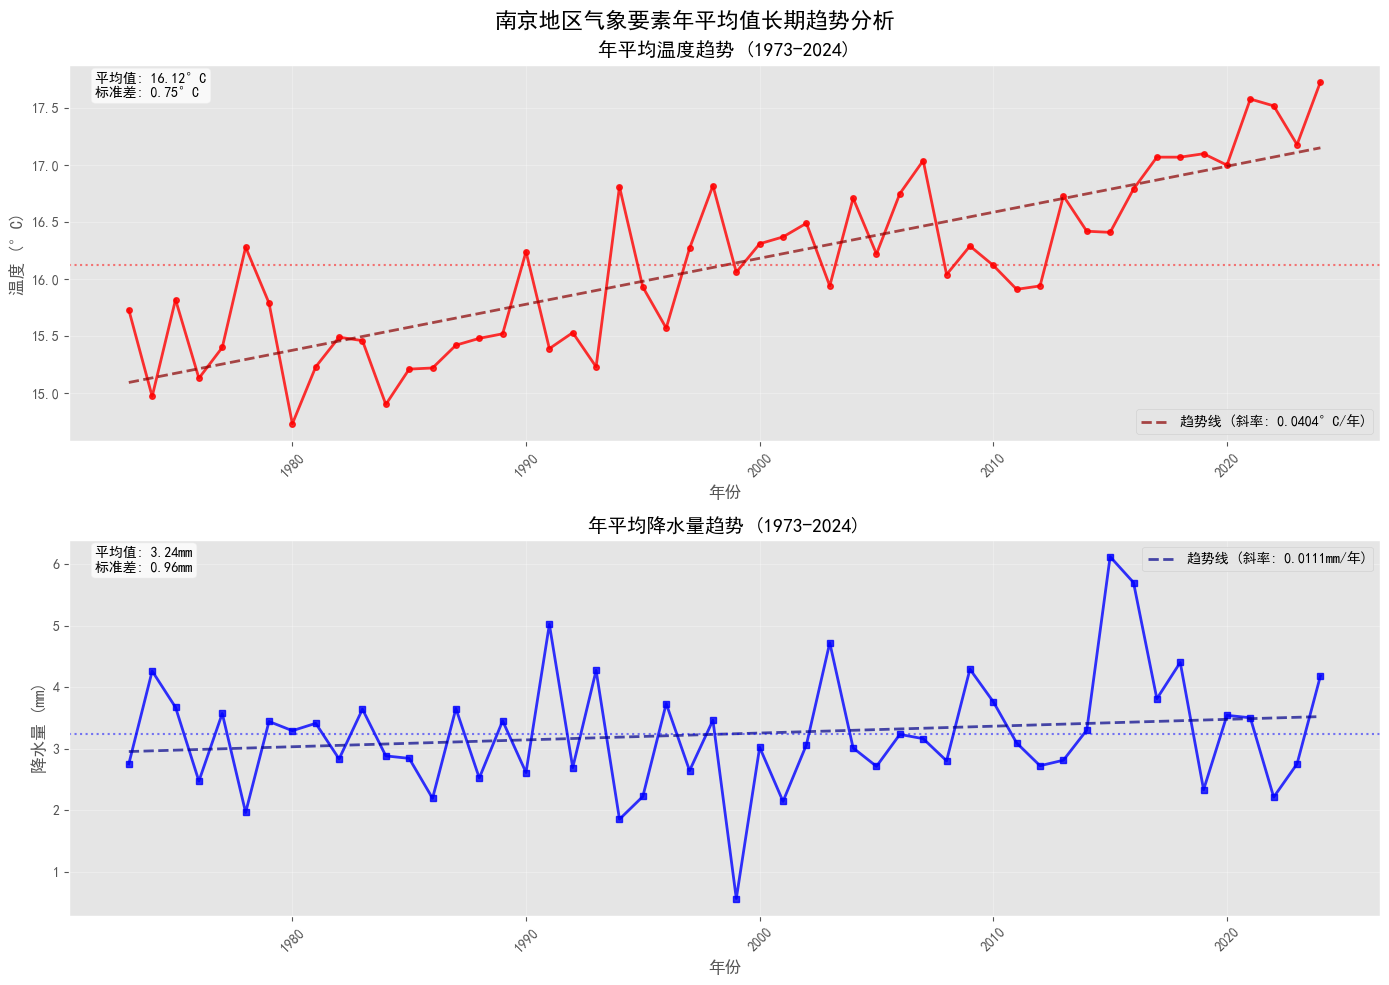



📊 年平均值趋势分析结果:

🌡️ 温度趋势:
   - 总体趋势: 上升
   - 变化率: 0.0404°C/年
   - 多年平均: 16.12°C
   - 标准差: 0.75°C
   - 最高年平均: 17.73°C (2024年)
   - 最低年平均: 14.73°C (1980年)

🌧️ 降水量趋势:
   - 总体趋势: 增加
   - 变化率: 0.0111mm/年
   - 多年平均: 3.24mm
   - 标准差: 0.96mm
   - 最高年平均: 6.12mm (2015年)
   - 最低年平均: 0.56mm (1999年)

🔗 温度与降水量的相关性: 0.0148
   相关性强度: 弱正相关

✅ 时间序列趋势分析完成！


In [16]:
# 绘制 TEMP 和 PRCP 的年平均值时间序列折线图
print("开始绘制年平均值时间序列图...")
print(f"数据时间范围: {df_weather.index.min()} 到 {df_weather.index.max()}")
print("\n" + "="*60 + "\n")

# 确保索引是datetime类型
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("索引转换完成")

# 提取年份并计算年平均值
print("计算年平均值...")
df_weather['Year'] = df_weather.index.year

# 计算TEMP和PRCP的年平均值
yearly_stats = df_weather.groupby('Year').agg({
    'TEMP': 'mean',
    'PRCP': 'mean'
}).round(2)

print(f"年份范围: {yearly_stats.index.min()} - {yearly_stats.index.max()}")
print(f"总共 {len(yearly_stats)} 年的数据")

# 显示前几年和最后几年的统计
print("\n前5年的年平均值:")
print(yearly_stats.head())
print("\n最后5年的年平均值:")
print(yearly_stats.tail())

print("\n" + "-"*40 + "\n")

# 创建图形
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('南京地区气象要素年平均值长期趋势分析', fontsize=16, fontweight='bold')

# 1. 绘制温度(TEMP)的年平均值趋势
ax1.plot(yearly_stats.index, yearly_stats['TEMP'], 
         color='red', linewidth=2, marker='o', markersize=4, alpha=0.8)
ax1.set_title('年平均温度趋势 (1973-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('温度 (°C)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 添加趋势线
z1 = np.polyfit(yearly_stats.index, yearly_stats['TEMP'], 1)
p1 = np.poly1d(z1)
ax1.plot(yearly_stats.index, p1(yearly_stats.index), 
         color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
         label=f'趋势线 (斜率: {z1[0]:.4f}°C/年)')
ax1.legend()

# 添加统计信息
temp_mean = yearly_stats['TEMP'].mean()
temp_std = yearly_stats['TEMP'].std()
ax1.axhline(y=temp_mean, color='red', linestyle=':', alpha=0.5, 
           label=f'平均值: {temp_mean:.2f}°C')
ax1.text(0.02, 0.98, f'平均值: {temp_mean:.2f}°C\n标准差: {temp_std:.2f}°C', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. 绘制降水量(PRCP)的年平均值趋势
ax2.plot(yearly_stats.index, yearly_stats['PRCP'], 
         color='blue', linewidth=2, marker='s', markersize=4, alpha=0.8)
ax2.set_title('年平均降水量趋势 (1973-2024)', fontsize=14, fontweight='bold')
ax2.set_xlabel('年份', fontsize=12)
ax2.set_ylabel('降水量 (mm)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 添加趋势线
z2 = np.polyfit(yearly_stats.index, yearly_stats['PRCP'], 1)
p2 = np.poly1d(z2)
ax2.plot(yearly_stats.index, p2(yearly_stats.index), 
         color='darkblue', linestyle='--', linewidth=2, alpha=0.7, 
         label=f'趋势线 (斜率: {z2[0]:.4f}mm/年)')
ax2.legend()

# 添加统计信息
prcp_mean = yearly_stats['PRCP'].mean()
prcp_std = yearly_stats['PRCP'].std()
ax2.axhline(y=prcp_mean, color='blue', linestyle=':', alpha=0.5, 
           label=f'平均值: {prcp_mean:.2f}mm')
ax2.text(0.02, 0.98, f'平均值: {prcp_mean:.2f}mm\n标准差: {prcp_std:.2f}mm', 
         transform=ax2.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 调整布局
plt.tight_layout()
plt.show()

print("\n" + "="*60 + "\n")
print("📊 年平均值趋势分析结果:")

# 温度趋势分析
temp_trend = "上升" if z1[0] > 0 else "下降" if z1[0] < 0 else "稳定"
print(f"\n🌡️ 温度趋势:")
print(f"   - 总体趋势: {temp_trend}")
print(f"   - 变化率: {z1[0]:.4f}°C/年")
print(f"   - 多年平均: {temp_mean:.2f}°C")
print(f"   - 标准差: {temp_std:.2f}°C")
print(f"   - 最高年平均: {yearly_stats['TEMP'].max():.2f}°C ({yearly_stats['TEMP'].idxmax()}年)")
print(f"   - 最低年平均: {yearly_stats['TEMP'].min():.2f}°C ({yearly_stats['TEMP'].idxmin()}年)")

# 降水量趋势分析
prcp_trend = "增加" if z2[0] > 0 else "减少" if z2[0] < 0 else "稳定"
print(f"\n🌧️ 降水量趋势:")
print(f"   - 总体趋势: {prcp_trend}")
print(f"   - 变化率: {z2[0]:.4f}mm/年")
print(f"   - 多年平均: {prcp_mean:.2f}mm")
print(f"   - 标准差: {prcp_std:.2f}mm")
print(f"   - 最高年平均: {yearly_stats['PRCP'].max():.2f}mm ({yearly_stats['PRCP'].idxmax()}年)")
print(f"   - 最低年平均: {yearly_stats['PRCP'].min():.2f}mm ({yearly_stats['PRCP'].idxmin()}年)")

# 计算相关性
correlation = yearly_stats['TEMP'].corr(yearly_stats['PRCP'])
print(f"\n🔗 温度与降水量的相关性: {correlation:.4f}")
if abs(correlation) > 0.5:
    corr_strength = "强"
elif abs(correlation) > 0.3:
    corr_strength = "中等"
else:
    corr_strength = "弱"
corr_direction = "正" if correlation > 0 else "负"
print(f"   相关性强度: {corr_strength}{corr_direction}相关")

print("\n✅ 时间序列趋势分析完成！")

# 清理临时列
df_weather = df_weather.drop('Year', axis=1)
# print("\n已清理临时变量")

**实验结果图表（上图）：**
* 图中红线展示了1973-2024年间每年的年平均温度。
* 红色虚线表示这52年间的总体平均温度，为 **16.12 °C**。
* 棕色虚线是根据所有数据点拟合的线性趋势线。

**结果分析：**
1.  **显著的增温趋势**：从图中可以非常清晰地观察到，年平均温度的趋势线呈现出明显的上升姿态。其斜率约为 **+0.0404 °C/年**，这表明在过去的52年里，南京地区的年平均温度以每十年约0.4°C的速度在稳定升高。这是一个非常显著的区域性气候变暖信号。
2.  **年际波动性**：尽管总体趋势是上升的，但每年的温度存在着明显的年际波动。例如，在1980年前后出现了几个相对凉爽的年份，而在21世纪后，特别是2010年以后，绝大多数年份的平均温度都处于长期平均值之上，且多个破纪录的暖年出现在近期。数据的标准差为 **0.75 °C**，也量化了这种围绕平均值的波动程度。
3.  **结论**：该结果证实了研究区域正经历着持续的气候变暖过程。这一背景对于我们的研究至关重要，因为温度是影响雾、雷暴、降水形态等多种天气现象的关键因子。在构建预测模型时，必须考虑到温度基线的这种非平稳性变化。

---

**实验结果图表（下图）：**
* 图中蓝线展示了1973-2024年间每年的年平均日降水量。
* 蓝色虚线表示这52年间的总体平均值，为 **3.24 mm/天** (折合年总降水量约为1183 mm)。
* 蓝色虚线是根据所有数据点拟合的线性趋势线。

**结果分析：**
1.  **长期趋势不明显**：与温度不同，年平均降水量的趋势线斜率仅为 **+0.011 mm/年**，非常接近于零。这表明在过去的52年里，南京地区的年平均降水量没有表现出统计上显著的增加或减少趋势。趋势线几乎是水平的。
2.  **显著的年际变率**：降水量分析图中最显著的特征是其巨大的年际变率（year-to-year variability）。如图所示，存在降水异常偏多的“丰水年”（例如1990年代初、2016年前后）和异常偏少的“枯水年”（例如1990年代末）。数据的标准差为 **0.95 mm**，这个数值相对于3.24 mm的平均值来说非常大（变异系数约为29%），进一步证实了降水量的年际波动是该地区气候的主要特征。
3.  **结论**：与持续变暖的温度背景不同，研究区域的降水模式在长期尺度上相对稳定，但年际间的差异巨大。这意味着，对于降水相关的预测任务（如日降水量预测、降水形态判别），模型需要有能力捕捉导致这种高变率的短期和年际尺度的影响因子，而非依赖一个简单的长期趋势。

---

**综合小结：**

通过对过去52年气象数据的初步分析，我们确立了本次研究的气候背景：一个伴随着显著且稳定增温趋势、同时降水量呈现高强度年际波动的环境。这一发现为我们后续的特征工程和模型构建提供了重要依据。例如，在温度预测模型中，时间（年份）本身可能就是一个强有力的特征；而在降水预测模型中，则需要更侧重于挖掘能够解释其高频波动的短期气象前兆信号。

#### 1.4.2 天气现象发生频率分析

在对关键气象要素进行长期趋势分析后，我们进一步聚焦于两个对社会经济活动有重要影响的特定天气现象——雾 `Fog` 和雷暴 `Thunder` 。通过统计1973年至2024年间这两种现象每年的发生天数，我们可以观察其频率的长期演变规律，这对于理解相关预测任务的背景至关重要：

开始分析雾(Fog)和雷暴(Thunder)现象的年度发生情况...
数据时间范围: 1973-01-01 00:00:00 到 2024-12-31 00:00:00


✅ 找到所需的 Fog 和 Thunder 列

计算年度发生天数...
年份范围: 1973 - 2024
总共 52 年的数据

各现象的年度发生天数统计:

雾(Fog)现象:
  平均每年发生: 46.6 天
  最多年份: 116 天 (2003年)
  最少年份: 12 天 (2024年)
  标准差: 31.7 天

雷暴(Thunder)现象:
  平均每年发生: 21.3 天
  最多年份: 38 天 (2005年)
  最少年份: 7 天 (2019年)
  标准差: 6.8 天

前5年和最后5年的数据:

前5年:
      Fog  Thunder
Year              
1973   15       23
1974   19       28
1975   21       27
1976   20       18
1977   34       19

最后5年:
      Fog  Thunder
Year              
2020   25       21
2021   23       13
2022   16       11
2023   16       20
2024   12       11

--------------------------------------------------



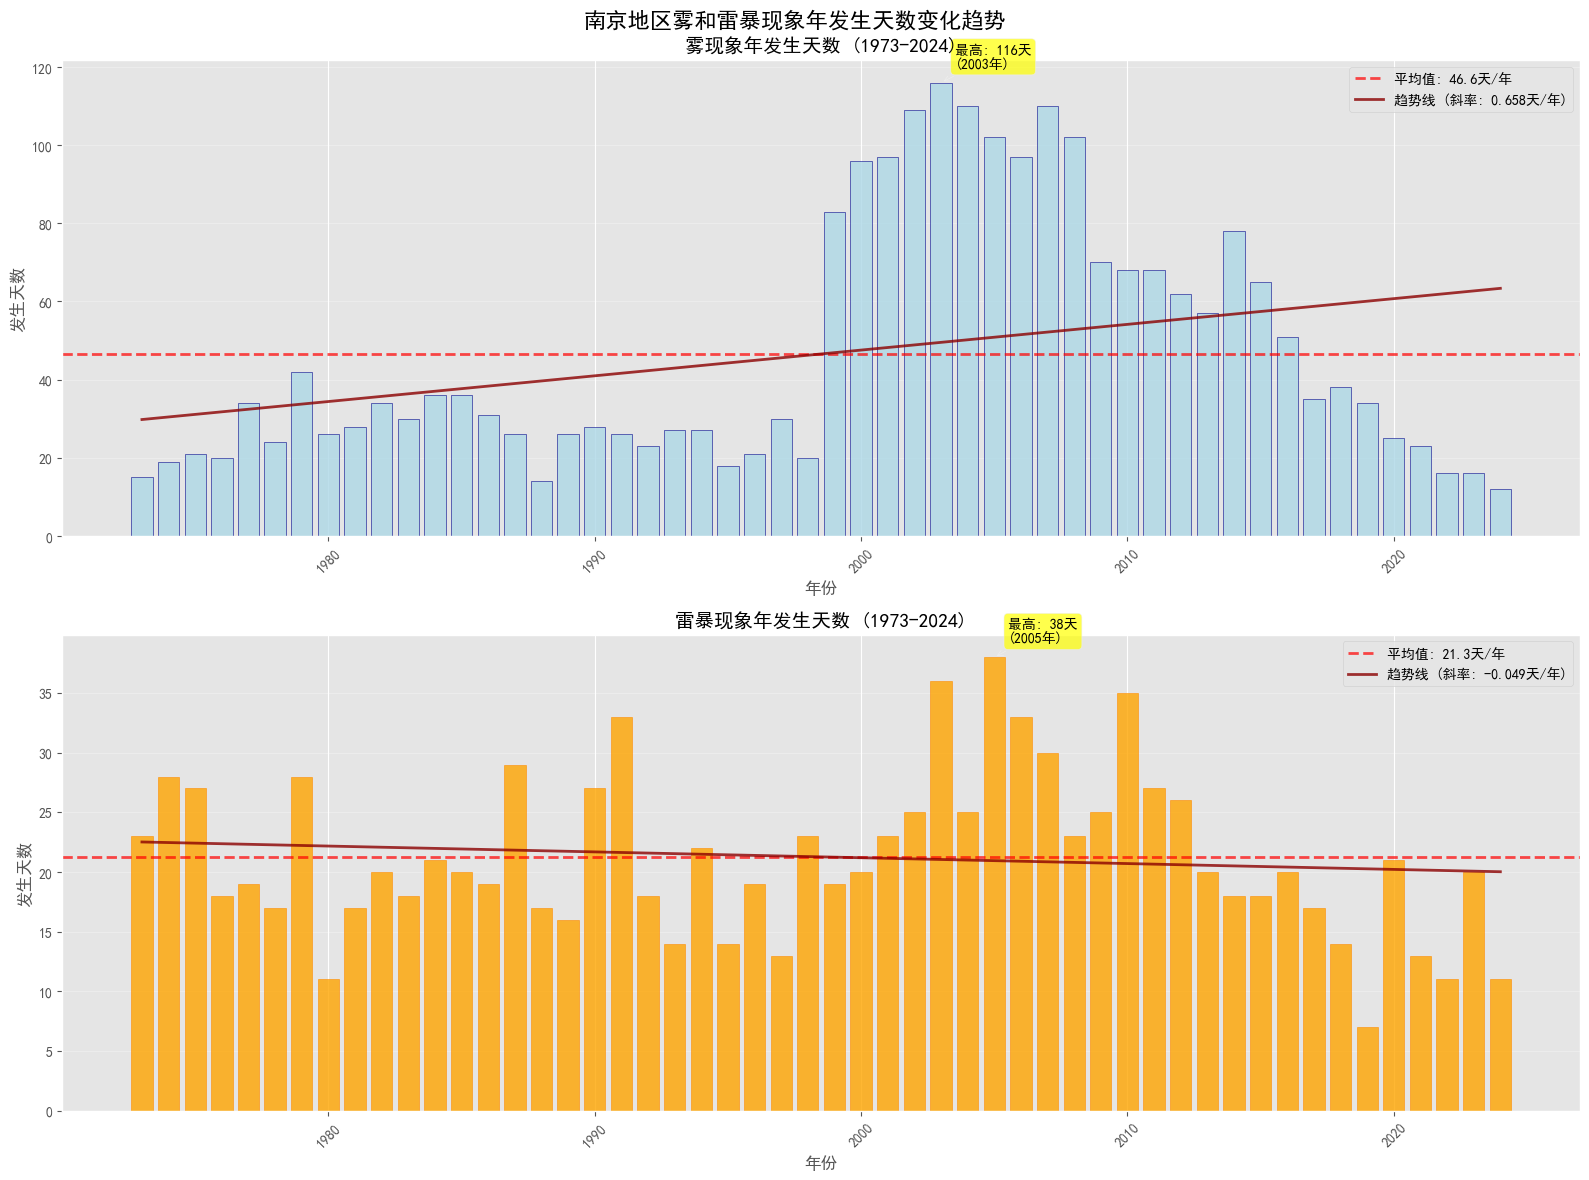



📊 天气现象年度趋势分析结果:

🌫️ 雾现象趋势:
   - 总体趋势: 增加
   - 变化率: 0.658天/年
   - 年平均发生: 46.6天
   - 标准差: 31.7天
   - 最多年份: 116天 (2003年)
   - 最少年份: 12天 (2024年)

⛈️ 雷暴现象趋势:
   - 总体趋势: 减少
   - 变化率: -0.049天/年
   - 年平均发生: 21.3天
   - 标准差: 6.8天
   - 最多年份: 38天 (2005年)
   - 最少年份: 7天 (2019年)

🔗 雾与雷暴现象的相关性: 0.5184
   相关性强度: 强正相关

📈 近期变化分析 (近10年 vs 前10年):
   雾现象: 31.5天/年 vs 26.3天/年
   雷暴现象: 15.2天/年 vs 20.8天/年
   雾现象变化: +19.8%
   雷暴现象变化: -26.9%

✅ 天气现象年度统计分析完成！


In [17]:
# 对 Fog 和 Thunder 现象进行年度统计分析
print("开始分析雾(Fog)和雷暴(Thunder)现象的年度发生情况...")
print(f"数据时间范围: {df_weather.index.min()} 到 {df_weather.index.max()}")
print("\n" + "="*70 + "\n")

# 确保索引是datetime类型
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("索引转换完成")

# 检查Fog和Thunder列是否存在
required_columns = ['Fog', 'Thunder']
missing_columns = [col for col in required_columns if col not in df_weather.columns]
if missing_columns:
    print(f"错误：缺少必要的列: {missing_columns}")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    print("✅ 找到所需的 Fog 和 Thunder 列")

# 提取年份并计算年度发生天数
print("\n计算年度发生天数...")
df_weather['Year'] = df_weather.index.year

# 计算每年雾和雷暴的发生天数（值为1的天数）
yearly_phenomena = df_weather.groupby('Year').agg({
    'Fog': 'sum',      # 雾发生的总天数
    'Thunder': 'sum'   # 雷暴发生的总天数
})

print(f"年份范围: {yearly_phenomena.index.min()} - {yearly_phenomena.index.max()}")
print(f"总共 {len(yearly_phenomena)} 年的数据")

# 显示基本统计信息
print("\n各现象的年度发生天数统计:")
print("\n雾(Fog)现象:")
fog_stats = yearly_phenomena['Fog'].describe()
print(f"  平均每年发生: {fog_stats['mean']:.1f} 天")
print(f"  最多年份: {yearly_phenomena['Fog'].max()} 天 ({yearly_phenomena['Fog'].idxmax()}年)")
print(f"  最少年份: {yearly_phenomena['Fog'].min()} 天 ({yearly_phenomena['Fog'].idxmin()}年)")
print(f"  标准差: {fog_stats['std']:.1f} 天")

print("\n雷暴(Thunder)现象:")
thunder_stats = yearly_phenomena['Thunder'].describe()
print(f"  平均每年发生: {thunder_stats['mean']:.1f} 天")
print(f"  最多年份: {yearly_phenomena['Thunder'].max()} 天 ({yearly_phenomena['Thunder'].idxmax()}年)")
print(f"  最少年份: {yearly_phenomena['Thunder'].min()} 天 ({yearly_phenomena['Thunder'].idxmin()}年)")
print(f"  标准差: {thunder_stats['std']:.1f} 天")

print("\n前5年和最后5年的数据:")
print("\n前5年:")
print(yearly_phenomena.head())
print("\n最后5年:")
print(yearly_phenomena.tail())

print("\n" + "-"*50 + "\n")

# 创建条形图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('南京地区雾和雷暴现象年发生天数变化趋势', fontsize=16, fontweight='bold')

# 设置条形图的宽度和颜色
bar_width = 0.8
years = yearly_phenomena.index

# 1. 绘制雾现象的年发生天数条形图
bars1 = ax1.bar(years, yearly_phenomena['Fog'], 
                width=bar_width, color='lightblue', alpha=0.8, 
                edgecolor='darkblue', linewidth=0.5)
ax1.set_title('雾现象年发生天数 (1973-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('年份', fontsize=12)
ax1.set_ylabel('发生天数', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# 添加平均线
fog_mean = yearly_phenomena['Fog'].mean()
ax1.axhline(y=fog_mean, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'平均值: {fog_mean:.1f}天/年')
ax1.legend()

# 添加趋势线
z1 = np.polyfit(years, yearly_phenomena['Fog'], 1)
p1 = np.poly1d(z1)
ax1.plot(years, p1(years), color='darkred', linewidth=2, alpha=0.8, 
         label=f'趋势线 (斜率: {z1[0]:.3f}天/年)')
ax1.legend()

# 标注最高和最低值
max_fog_year = yearly_phenomena['Fog'].idxmax()
max_fog_value = yearly_phenomena['Fog'].max()
min_fog_year = yearly_phenomena['Fog'].idxmin()
min_fog_value = yearly_phenomena['Fog'].min()

ax1.annotate(f'最高: {max_fog_value}天\n({max_fog_year}年)', 
            xy=(max_fog_year, max_fog_value), xytext=(10, 10),
            textcoords='offset points', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 2. 绘制雷暴现象的年发生天数条形图
bars2 = ax2.bar(years, yearly_phenomena['Thunder'], 
                width=bar_width, color='orange', alpha=0.8, 
                edgecolor='darkorange', linewidth=0.5)
ax2.set_title('雷暴现象年发生天数 (1973-2024)', fontsize=14, fontweight='bold')
ax2.set_xlabel('年份', fontsize=12)
ax2.set_ylabel('发生天数', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

# 添加平均线
thunder_mean = yearly_phenomena['Thunder'].mean()
ax2.axhline(y=thunder_mean, color='red', linestyle='--', linewidth=2, alpha=0.7, 
           label=f'平均值: {thunder_mean:.1f}天/年')
ax2.legend()

# 添加趋势线
z2 = np.polyfit(years, yearly_phenomena['Thunder'], 1)
p2 = np.poly1d(z2)
ax2.plot(years, p2(years), color='darkred', linewidth=2, alpha=0.8, 
         label=f'趋势线 (斜率: {z2[0]:.3f}天/年)')
ax2.legend()

# 标注最高和最低值
max_thunder_year = yearly_phenomena['Thunder'].idxmax()
max_thunder_value = yearly_phenomena['Thunder'].max()
min_thunder_year = yearly_phenomena['Thunder'].idxmin()
min_thunder_value = yearly_phenomena['Thunder'].min()

ax2.annotate(f'最高: {max_thunder_value}天\n({max_thunder_year}年)', 
            xy=(max_thunder_year, max_thunder_value), xytext=(10, 10),
            textcoords='offset points', ha='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 调整布局
plt.tight_layout()
plt.show()

print("\n" + "="*70 + "\n")
print("📊 天气现象年度趋势分析结果:")

# 雾现象趋势分析
fog_trend = "增加" if z1[0] > 0 else "减少" if z1[0] < 0 else "稳定"
print(f"\n🌫️ 雾现象趋势:")
print(f"   - 总体趋势: {fog_trend}")
print(f"   - 变化率: {z1[0]:.3f}天/年")
print(f"   - 年平均发生: {fog_mean:.1f}天")
print(f"   - 标准差: {fog_stats['std']:.1f}天")
print(f"   - 最多年份: {max_fog_value}天 ({max_fog_year}年)")
print(f"   - 最少年份: {min_fog_value}天 ({min_fog_year}年)")

# 雷暴现象趋势分析
thunder_trend = "增加" if z2[0] > 0 else "减少" if z2[0] < 0 else "稳定"
print(f"\n⛈️ 雷暴现象趋势:")
print(f"   - 总体趋势: {thunder_trend}")
print(f"   - 变化率: {z2[0]:.3f}天/年")
print(f"   - 年平均发生: {thunder_mean:.1f}天")
print(f"   - 标准差: {thunder_stats['std']:.1f}天")
print(f"   - 最多年份: {max_thunder_value}天 ({max_thunder_year}年)")
print(f"   - 最少年份: {min_thunder_value}天 ({min_thunder_year}年)")

# 计算两种现象的相关性
correlation = yearly_phenomena['Fog'].corr(yearly_phenomena['Thunder'])
print(f"\n🔗 雾与雷暴现象的相关性: {correlation:.4f}")
if abs(correlation) > 0.5:
    corr_strength = "强"
elif abs(correlation) > 0.3:
    corr_strength = "中等"
else:
    corr_strength = "弱"
corr_direction = "正" if correlation > 0 else "负"
print(f"   相关性强度: {corr_strength}{corr_direction}相关")

# 计算近10年与前10年的对比
recent_years = yearly_phenomena.tail(10)
early_years = yearly_phenomena.head(10)

print(f"\n📈 近期变化分析 (近10年 vs 前10年):")
print(f"   雾现象: {recent_years['Fog'].mean():.1f}天/年 vs {early_years['Fog'].mean():.1f}天/年")
print(f"   雷暴现象: {recent_years['Thunder'].mean():.1f}天/年 vs {early_years['Thunder'].mean():.1f}天/年")

fog_change = ((recent_years['Fog'].mean() - early_years['Fog'].mean()) / early_years['Fog'].mean()) * 100
thunder_change = ((recent_years['Thunder'].mean() - early_years['Thunder'].mean()) / early_years['Thunder'].mean()) * 100

print(f"   雾现象变化: {fog_change:+.1f}%")
print(f"   雷暴现象变化: {thunder_change:+.1f}%")

print("\n✅ 天气现象年度统计分析完成！")

# 清理临时列
df_weather = df_weather.drop('Year', axis=1)
# print("\n已清理临时变量")

**图表结果解读：**

* **雾现象 (上图):**
    分析结果显示，南京地区的年均雾日为**46.6天**。从长期趋势来看，雾的发生天数呈现出轻微但持续的上升趋势，斜率约为 **+0.658天/年**。值得注意的是，雾日的年际波动极大，并表现出显著的阶段性特征。在20世纪末之前，雾日相对较少；进入21世纪后，雾的发生天数急剧增加，在2003年达到峰值（116天），形成一个明显的高发期；此后又有所回落。这种变化模式可能与该时期区域的城市化进程、空气污染状况以及气候背景变化密切相关。

* **雷暴现象 (下图):**
    南京地区的年均雷暴日为**21.3天**。与雾的趋势不同，雷暴的年发生天数在过去52年间没有显著的增加，反而呈现出极其微弱的下降趋势，斜率约为**-0.049天/年**。雷暴的发生同样具有很强的年际波动，但并未显示出类似雾的明显阶段性高发期。

**分析结论：**

通过对这两种关键天气现象的频率分析，我们得出两个重要结论：
1.  **雾的预测任务面临着非平稳的背景**：雾的发生频率随年代有显著变化，这意味着模型在学习雾的发生规律时，可能需要捕捉到这种长期的、与环境背景变化相关的非平稳特征。
2.  **雷暴的预测任务更侧重于年际变率**：雷暴的长期趋势相对平稳，预测模型需要更专注于捕捉导致其年际间发生频率差异的关键气象前兆信号。

这两个结论为我们后续针对不同天气现象选择和构建预测模型提供了重要的背景信息和指导方向。

#### 1.4.3 核心数值型气象特征相关性分析

为了深入理解各气象要素之间的内在联系，并为后续的特征选择和模型构建提供依据，我们计算了核心数值型气象特征(具体包括：`TEMP`, `MAX`, `MIN`, `DEWP`, `SLP`, `WDSP`, `MXSPD`, `PRCP`, `SNDP`, `VISIB`)之间的皮尔逊相关系数，并通过热力图进行可视化：

开始进行核心气象特征的相关性分析...
数据集形状: (18957, 16)


指定的核心特征: ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'WDSP', 'MXSPD', 'PRCP', 'SNDP', 'VISIB']
存在的特征: ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'WDSP', 'MXSPD', 'PRCP', 'SNDP', 'VISIB']
✅ 所有指定特征都存在

实际分析的特征数量: 10

核心特征数据概览:
                TEMP  MAX  MIN      DEWP     SLP      WDSP     MXSPD  PRCP  \
DATE                                                                         
1973-01-01  3.277778  6.0  1.0 -4.555556  102.68  4.269885  7.973882   0.0   
1973-01-02 -1.000000  9.0 -5.0 -9.444444  103.11  3.446775  6.996438   0.0   
1973-01-03 -1.166667  3.0 -5.0 -6.666667  103.05  1.440443  4.990107   0.0   
1973-01-04  1.388889  4.0 -3.0 -4.388889  103.27  2.983775  4.012663   0.0   
1973-01-05  5.000000  8.0 -1.0  1.166667  103.33  3.498219  4.990107   0.0   

            SNDP      VISIB  
DATE                         
1973-01-01   0.0  14.966862  
1973-01-02   0.0  15.771532  
1973-01-03   0.0  11.104446  
1973-01-04   0.0  17.541806  
1973-01-05   0.0  

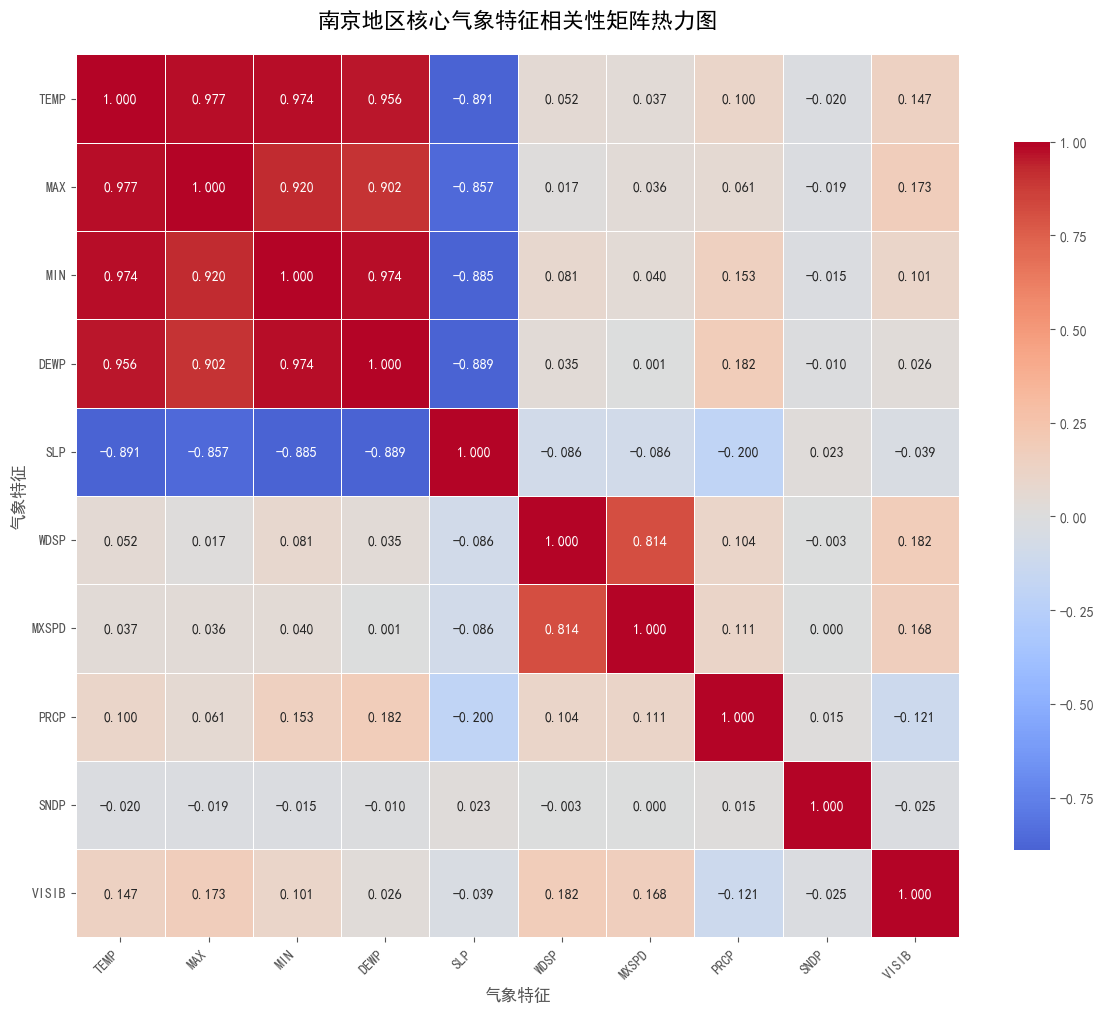



📈 相关性分析结果解读:

🌡️ 温度相关特征:
  温度类特征间的平均相关性: 0.951

💨 风速相关特征:
  WDSP vs MXSPD 相关性: 0.814

🌧️ 降水相关特征:
  PRCP vs SNDP 相关性: 0.015

📊 相关性强度统计:
  总特征对数: 45
  强相关 (|r| > 0.7): 11 对 (24.4%)
  中等相关 (0.3 < |r| ≤ 0.7): 0 对 (0.0%)
  弱相关 (|r| ≤ 0.3): 34 对 (75.6%)

🔍 关键发现:
  1. 最强正相关: MAX-TEMP (0.977)
  2. 最强负相关: SLP-TEMP (-0.891)
  3. 强相关性特征对数: 11
  4. 整体相关性水平: 中等

✅ 核心气象特征相关性分析完成！

📝 分析结论:
   - 热力图中红色表示正相关，蓝色表示负相关
   - 颜色越深，相关性越强
   - 对角线为1.000，表示特征与自身的完全相关
   - 可用于特征选择、降维和模型优化


In [18]:
# 核心气象特征的皮尔逊相关系数矩阵分析和可视化
print("开始进行核心气象特征的相关性分析...")
print(f"数据集形状: {df_weather.shape}")
print("\n" + "="*70 + "\n")

# 定义核心气象特征
core_features = ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'WDSP', 'MXSPD', 'PRCP', 'SNDP', 'VISIB']

# 检查特征是否存在于数据集中
existing_features = [col for col in core_features if col in df_weather.columns]
missing_features = [col for col in core_features if col not in df_weather.columns]

print(f"指定的核心特征: {core_features}")
print(f"存在的特征: {existing_features}")
if missing_features:
    print(f"缺失的特征: {missing_features}")
else:
    print("✅ 所有指定特征都存在")

print(f"\n实际分析的特征数量: {len(existing_features)}")

# 提取核心特征数据
core_data = df_weather[existing_features].copy()

print("\n核心特征数据概览:")
print(core_data.head())

print("\n核心特征的基本统计信息:")
print(core_data.describe().round(2))

print("\n" + "-"*50 + "\n")

# 检查缺失值
missing_check = core_data.isnull().sum()
print("核心特征的缺失值检查:")
if missing_check.sum() > 0:
    print(missing_check[missing_check > 0])
    print("\n⚠️ 警告: 存在缺失值，可能影响相关性计算")
else:
    print("✅ 所有核心特征都没有缺失值")

print("\n" + "-"*50 + "\n")

# 计算皮尔逊相关系数矩阵
print("计算皮尔逊相关系数矩阵...")
correlation_matrix = core_data.corr(method='pearson')

print(f"相关系数矩阵形状: {correlation_matrix.shape}")
print("\n相关系数矩阵 (保疙4位小数):")
print(correlation_matrix.round(4))

print("\n" + "-"*50 + "\n")

# 找出最强的正相关和负相关(排除对角线)
print("分析最显著的相关性:")

# 创建上三角矩阵的掩码，排除对角线
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
upper_triangle = correlation_matrix.where(~mask)

# 找出最强的正相关和负相关
flattened = upper_triangle.stack()
strongest_positive = flattened.max()
strongest_negative = flattened.min()

pos_pair = flattened.idxmax()
neg_pair = flattened.idxmin()

print(f"最强正相关: {pos_pair[0]} vs {pos_pair[1]} = {strongest_positive:.4f}")
print(f"最强负相关: {neg_pair[0]} vs {neg_pair[1]} = {strongest_negative:.4f}")

# 找出所有强相关性 (|r| > 0.7)
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            strong_correlations.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

print(f"\n强相关性 (|r| > 0.7) 共 {len(strong_correlations)} 对:")
for feat1, feat2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
    corr_type = "正相关" if corr > 0 else "负相关"
    print(f"  {feat1} vs {feat2}: {corr:.4f} ({corr_type})")

print("\n" + "="*70 + "\n")

# 使用Seaborn绘制热力图
print("绘制相关系数矩阵热力图...")

# 设置图形大小
plt.figure(figsize=(12, 10))

# 创建热力图
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,                    # 显示相关系数值
    cmap='coolwarm',              # 使用coolwarm颜色映射
    center=0,                     # 以0为中心点
    square=True,                  # 正方形单元格
    fmt='.3f',                    # 数值格式（3位小数）
    cbar_kws={'shrink': 0.8},     # 颜色条设置
    linewidths=0.5,               # 网格线宽度
    linecolor='white'             # 网格线颜色
)

# 设置标题和标签
plt.title('南京地区核心气象特征相关性矩阵热力图', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('气象特征', fontsize=12, fontweight='bold')
plt.ylabel('气象特征', fontsize=12, fontweight='bold')

# 调整刻度标签
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

print("\n" + "="*70 + "\n")
print("📈 相关性分析结果解读:")

# 按类别分析相关性
print("\n🌡️ 温度相关特征:")
temp_features = ['TEMP', 'MAX', 'MIN', 'DEWP']
temp_existing = [f for f in temp_features if f in existing_features]
if len(temp_existing) > 1:
    temp_corr = correlation_matrix.loc[temp_existing, temp_existing]
    print(f"  温度类特征间的平均相关性: {temp_corr.values[np.triu_indices_from(temp_corr.values, k=1)].mean():.3f}")

print("\n💨 风速相关特征:")
wind_features = ['WDSP', 'MXSPD']
wind_existing = [f for f in wind_features if f in existing_features]
if len(wind_existing) == 2:
    wind_corr = correlation_matrix.loc['WDSP', 'MXSPD']
    print(f"  WDSP vs MXSPD 相关性: {wind_corr:.3f}")

print("\n🌧️ 降水相关特征:")
precip_features = ['PRCP', 'SNDP']
precip_existing = [f for f in precip_features if f in existing_features]
if len(precip_existing) == 2:
    precip_corr = correlation_matrix.loc['PRCP', 'SNDP']
    print(f"  PRCP vs SNDP 相关性: {precip_corr:.3f}")

# 统计不同强度的相关性数量
print("\n📊 相关性强度统计:")
total_pairs = len(existing_features) * (len(existing_features) - 1) // 2
strong_count = len([1 for _, _, corr in strong_correlations if abs(corr) > 0.7])
moderate_count = len([1 for _, _, corr in strong_correlations if 0.3 < abs(corr) <= 0.7])
weak_count = total_pairs - strong_count - moderate_count

print(f"  总特征对数: {total_pairs}")
print(f"  强相关 (|r| > 0.7): {strong_count} 对 ({strong_count/total_pairs*100:.1f}%)")
print(f"  中等相关 (0.3 < |r| ≤ 0.7): {moderate_count} 对 ({moderate_count/total_pairs*100:.1f}%)")
print(f"  弱相关 (|r| ≤ 0.3): {weak_count} 对 ({weak_count/total_pairs*100:.1f}%)")

print("\n🔍 关键发现:")
print(f"  1. 最强正相关: {pos_pair[0]}-{pos_pair[1]} ({strongest_positive:.3f})")
print(f"  2. 最强负相关: {neg_pair[0]}-{neg_pair[1]} ({strongest_negative:.3f})")
print(f"  3. 强相关性特征对数: {strong_count}")
print(f"  4. 整体相关性水平: {'高' if strong_count/total_pairs > 0.3 else '中等' if strong_count/total_pairs > 0.1 else '低'}")

print("\n✅ 核心气象特征相关性分析完成！")
print("\n📝 分析结论:")
print("   - 热力图中红色表示正相关，蓝色表示负相关")
print("   - 颜色越深，相关性越强")
print("   - 对角线为1.000，表示特征与自身的完全相关")
print("   - 可用于特征选择、降维和模型优化")

**图表结果解读与分析：**

通过观察上方的相关性矩阵热力图，我们可以得出以下几个关键结论：

1.  **高度相关的特征族群**：
    * **温度族**：日平均温度(`TEMP`)、最高温度(`MAX`)、最低温度(`MIN`)以及露点温度(`DEWP`)之间表现出极强的正相关性（相关系数 > 0.9）。这符合物理常识，表明这些变量在很大程度上提供了相似的温度信息。
    * **风速族**：平均风速(`WDSP`)与最大持续风速(`MXSPD`)之间也存在很强的正相关性（相关系数约为0.814）。

2.  **显著的负相关关系**：
    * 海平面气压(`SLP`)与所有温度相关的变量都呈现出强烈的负相关关系（相关系数在-0.85至-0.89之间）。这揭示了热力学上的基本关系，即在其他条件相似时，温度升高往往伴随着气压的降低。

3.  **弱相关性特征**：
    * 日降水量(`PRCP`)与其他大多数气象要素的线性相关性都较弱。其与海平面气压的负相关（-0.200）和与露点的正相关（0.182）是所有关系中相对最显著的，这暗示了低压系统和高湿度环境更容易产生降水，但这种线性关系并不足以单独作为强预测因子。

**对后续建模的启示：**

* **多重共线性问题**：温度族和风速族内部存在严重的多重共线性。这在使用线性模型（如逻辑回归、线性回归）时需要特别注意，因为它可能导致模型系数不稳定。在特征选择阶段，我们可以考虑从每个高度相关的族群中选取代表性特征，或通过特征工程（如计算日温差`MAX - MIN`）来创造信息量集中且相关性较低的新特征。
* **非线性关系的重要性**：以降水(`PRCP`)为代表的多个重要气象要素与其他变量的线性关系不强，这预示着预测这些要素可能需要依赖能够捕捉复杂非线性关系的机器学习模型（如决策树、随机森林、GBDT及神经网络）。

#### 1.4.4 关键天气现象（雾、雷暴）的气象特征分布分析

在对特征间的相关性进行分析后，本节将深入探讨各个数值型特征与我们的分类目标（雾和雷暴的发生）之间的关系。通过为每个目标现象绘制箱线图，我们可以直观地比较在“发生”与“未发生”两种情况下，关键气象特征的分布是否存在显著差异，从而验证我们所选特征的有效性，并为后续模型构建提供洞见：

开始分析数值特征与分类目标变量的关系...
数据集形状: (18957, 16)


✅ 找到所需的 Fog 和 Thunder 目标变量

目标变量分布统计:

Fog:
  0: 16,535 次 (87.22%)
  1: 2,422 次 (12.78%)

Thunder:
  0: 17,851 次 (94.17%)
  1: 1,106 次 (5.83%)


🌫️ 1. 雾预测分析 - 特征分布差异箱线图

分析特征: TEMP, DEWP, VISIB, WDSP
⚠️ Dew_Point_Spread 特征不存在，将创建该特征
✅ 已创建 Dew_Point_Spread = TEMP - DEWP

实际分析的雾预测特征: ['TEMP', 'DEWP', 'VISIB', 'WDSP', 'Dew_Point_Spread']


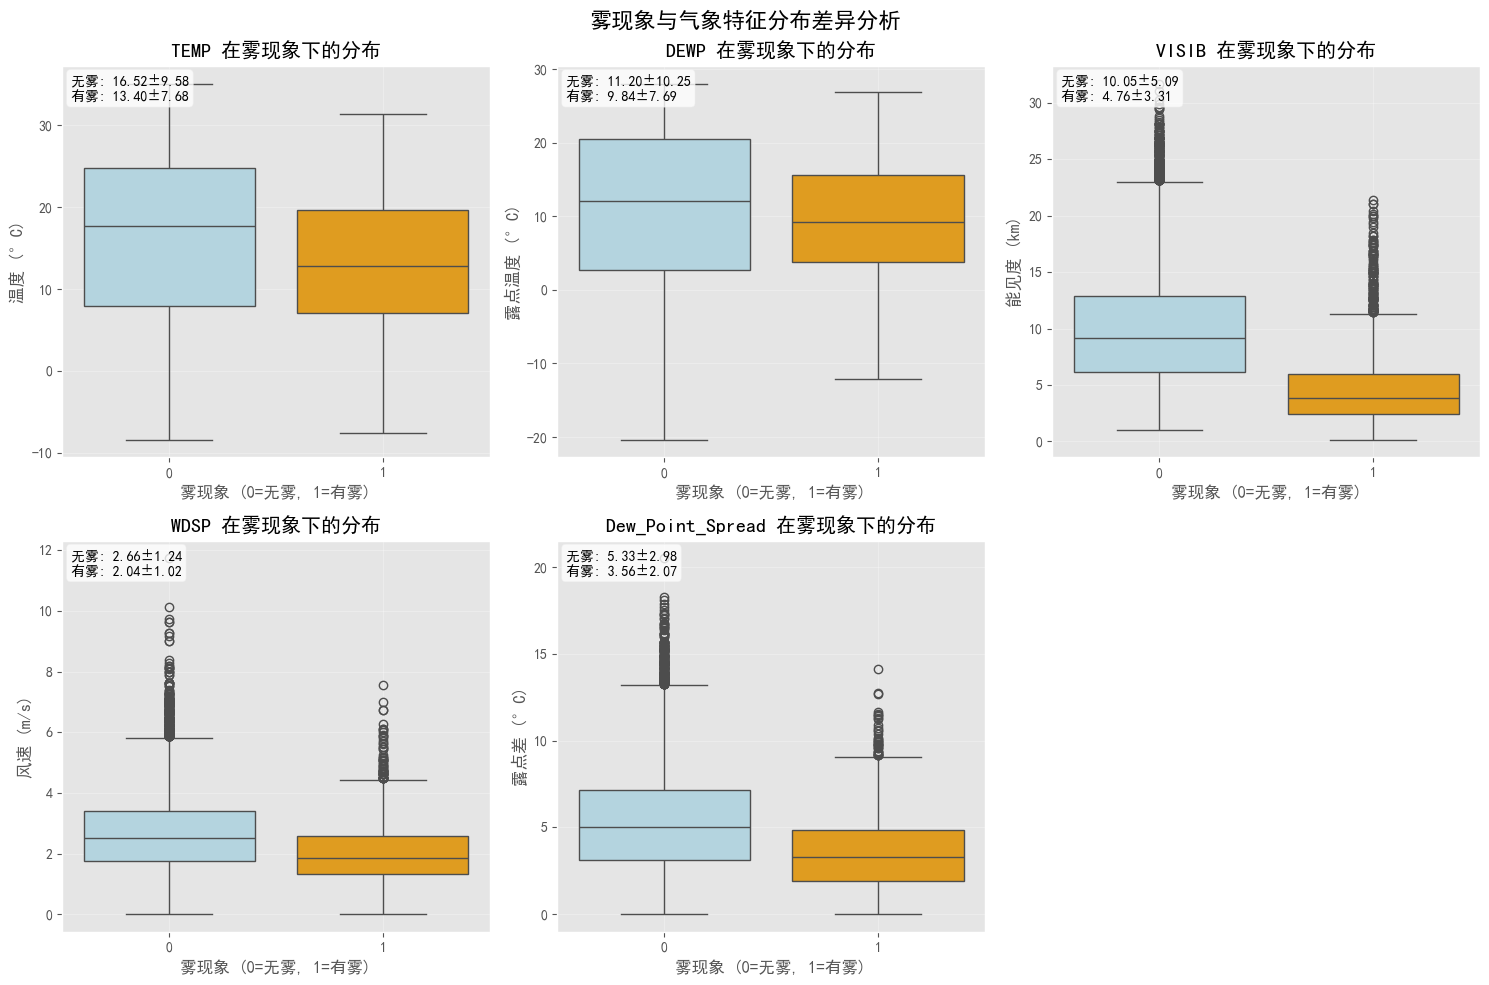


📊 雾预测特征统计分析:

TEMP:
  无雾情况: 平均值 16.522, 标准差 9.577
  有雾情况: 平均值 13.398, 标准差 7.679
  平均值差异: -3.125

DEWP:
  无雾情况: 平均值 11.197, 标准差 10.250
  有雾情况: 平均值 9.841, 标准差 7.690
  平均值差异: -1.356

VISIB:
  无雾情况: 平均值 10.052, 标准差 5.088
  有雾情况: 平均值 4.758, 标准差 3.309
  平均值差异: -5.294

WDSP:
  无雾情况: 平均值 2.661, 标准差 1.244
  有雾情况: 平均值 2.037, 标准差 1.022
  平均值差异: -0.625

Dew_Point_Spread:
  无雾情况: 平均值 5.325, 标准差 2.977
  有雾情况: 平均值 3.557, 标准差 2.072
  平均值差异: -1.769


⛈️ 2. 雷暴预测分析 - 特征分布差异箱线图

分析特征: TEMP, MAX, MIN, DEWP, SLP, MXSPD
实际分析的雷暴预测特征: ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'MXSPD']


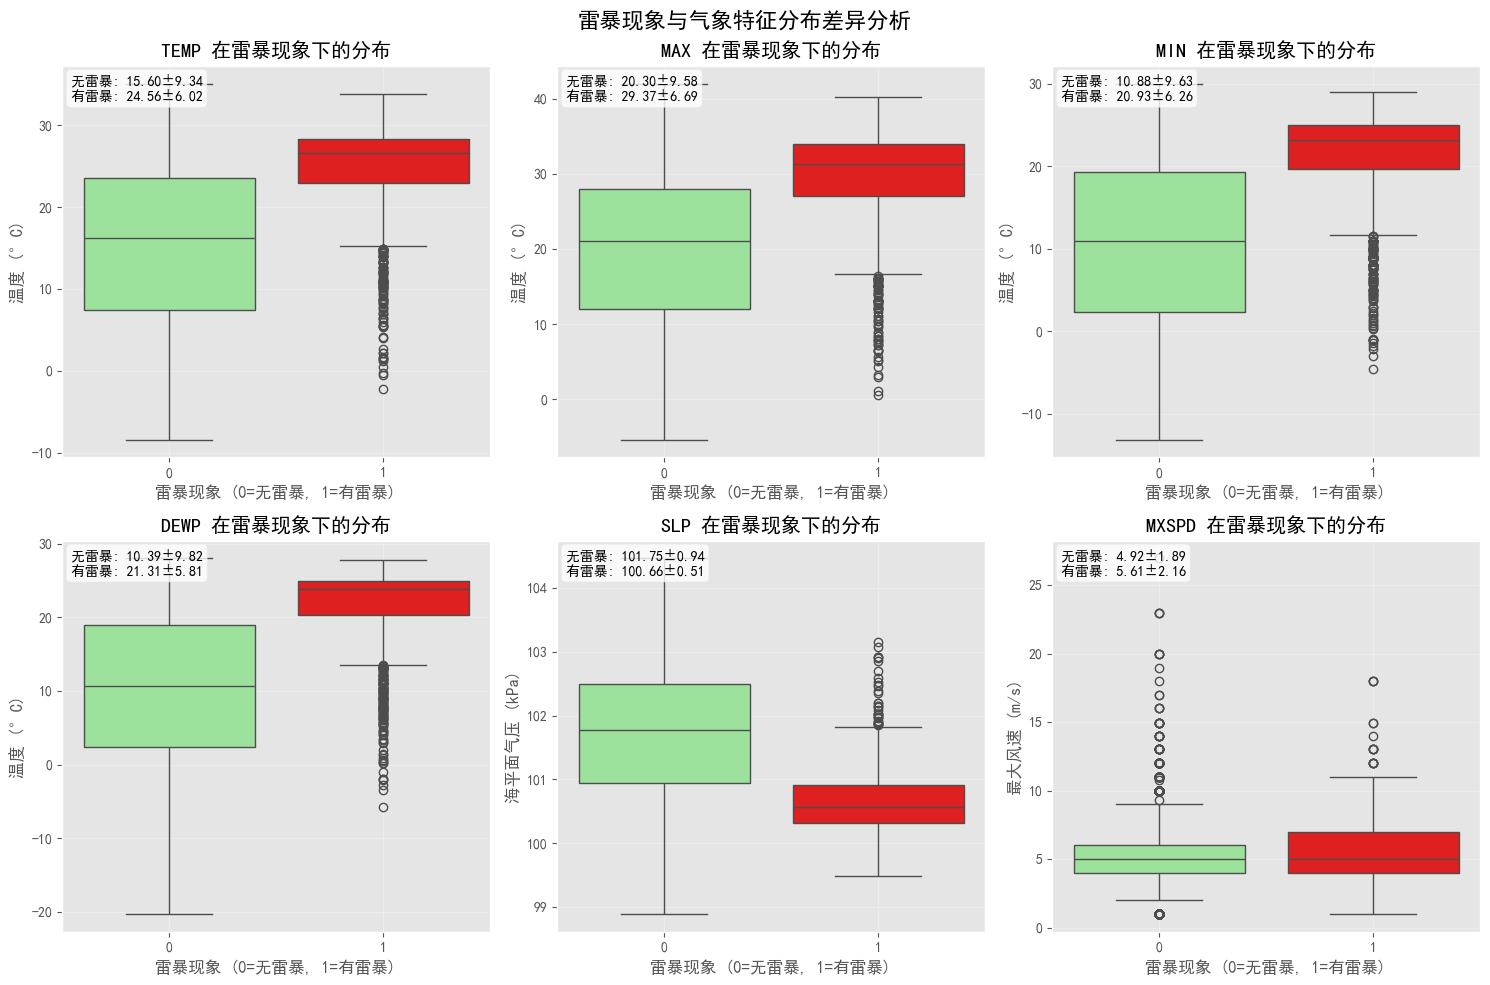


📊 雷暴预测特征统计分析:

TEMP:
  无雷暴情况: 平均值 15.600, 标准差 9.337
  有雷暴情况: 平均值 24.560, 标准差 6.016
  平均值差异: 8.959

MAX:
  无雷暴情况: 平均值 20.303, 标准差 9.584
  有雷暴情况: 平均值 29.375, 标准差 6.689
  平均值差异: 9.072

MIN:
  无雷暴情况: 平均值 10.875, 标准差 9.628
  有雷暴情况: 平均值 20.934, 标准差 6.263
  平均值差异: 10.058

DEWP:
  无雷暴情况: 平均值 10.386, 标准差 9.823
  有雷暴情况: 平均值 21.314, 标准差 5.813
  平均值差异: 10.928

SLP:
  无雷暴情况: 平均值 101.749, 标准差 0.936
  有雷暴情况: 平均值 100.663, 标准差 0.509
  平均值差异: -1.086

MXSPD:
  无雷暴情况: 平均值 4.922, 标准差 1.888
  有雷暴情况: 平均值 5.613, 标准差 2.159
  平均值差异: 0.690



✅ 数值特征与分类目标变量关系分析完成！

ℹ️ 注意: 已创建 Dew_Point_Spread 特征，可用于后续建模


In [19]:
# 数值特征与分类目标变量关系分析 - 箱线图可视化
print("开始分析数值特征与分类目标变量的关系...")
print(f"数据集形状: {df_weather.shape}")
print("\n" + "="*80 + "\n")

# 检查必要的分类目标变量
target_columns = ['Fog', 'Thunder']
missing_targets = [col for col in target_columns if col not in df_weather.columns]
if missing_targets:
    print(f"错误：缺少必要的目标变量: {missing_targets}")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    print("✅ 找到所需的 Fog 和 Thunder 目标变量")

# 检查目标变量的分布
print("\n目标变量分布统计:")
for target in target_columns:
    if target in df_weather.columns:
        value_counts = df_weather[target].value_counts().sort_index()
        total = len(df_weather)
        print(f"\n{target}:")
        for value, count in value_counts.items():
            percentage = (count / total) * 100
            print(f"  {value}: {count:,} 次 ({percentage:.2f}%)")

print("\n" + "="*80 + "\n")

# 1. 雾预测分析
print("🌫️ 1. 雾预测分析 - 特征分布差异箱线图")
print("\n分析特征: TEMP, DEWP, VISIB, WDSP")

# 定义雾预测的特征
fog_features = ['TEMP', 'DEWP', 'VISIB', 'WDSP']
fog_existing = [col for col in fog_features if col in df_weather.columns]

# 检查是否存在 Dew_Point_Spread 特征
if 'Dew_Point_Spread' in df_weather.columns:
    fog_existing.append('Dew_Point_Spread')
    print("✅ 找到 Dew_Point_Spread 特征")
else:
    print("⚠️ Dew_Point_Spread 特征不存在，将创建该特征")
    # 创建 Dew_Point_Spread 特征 (TEMP - DEWP)
    if 'TEMP' in df_weather.columns and 'DEWP' in df_weather.columns:
        df_weather['Dew_Point_Spread'] = df_weather['TEMP'] - df_weather['DEWP']
        fog_existing.append('Dew_Point_Spread')
        print("✅ 已创建 Dew_Point_Spread = TEMP - DEWP")

print(f"\n实际分析的雾预测特征: {fog_existing}")

# 绘制雾预测箱线图
if len(fog_existing) > 0 and 'Fog' in df_weather.columns:
    # 计算子图布局
    n_features = len(fog_existing)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols  # 向上取整
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('雾现象与气象特征分布差异分析', fontsize=16, fontweight='bold')
    
    # 如果只有一行，确保 axes 是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(fog_existing):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # 绘制箱线图
        sns.boxplot(data=df_weather, x='Fog', y=feature, ax=ax, palette=['lightblue', 'orange'])
        
        # 设置标题和标签
        ax.set_title(f'{feature} 在雾现象下的分布', fontweight='bold')
        ax.set_xlabel('雾现象 (0=无雾, 1=有雾)')
        
        # 设置 y 轴标签
        if feature == 'TEMP':
            ax.set_ylabel('温度 (°C)')
        elif feature == 'DEWP':
            ax.set_ylabel('露点温度 (°C)')
        elif feature == 'VISIB':
            ax.set_ylabel('能见度 (km)')
        elif feature == 'WDSP':
            ax.set_ylabel('风速 (m/s)')
        elif feature == 'Dew_Point_Spread':
            ax.set_ylabel('露点差 (°C)')
        else:
            ax.set_ylabel(feature)
        
        ax.grid(True, alpha=0.3)
        
        # 计算统计信息
        no_fog = df_weather[df_weather['Fog'] == 0][feature]
        with_fog = df_weather[df_weather['Fog'] == 1][feature]
        
        # 添加统计信息文本
        stats_text = f'无雾: {no_fog.mean():.2f}±{no_fog.std():.2f}\n有雾: {with_fog.mean():.2f}±{with_fog.std():.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 隐藏多余的子图
    for i in range(len(fog_existing), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 统计分析
    print("\n📊 雾预测特征统计分析:")
    for feature in fog_existing:
        no_fog_data = df_weather[df_weather['Fog'] == 0][feature]
        with_fog_data = df_weather[df_weather['Fog'] == 1][feature]
        
        print(f"\n{feature}:")
        print(f"  无雾情况: 平均值 {no_fog_data.mean():.3f}, 标准差 {no_fog_data.std():.3f}")
        print(f"  有雾情况: 平均值 {with_fog_data.mean():.3f}, 标准差 {with_fog_data.std():.3f}")
        print(f"  平均值差异: {with_fog_data.mean() - no_fog_data.mean():.3f}")

print("\n" + "="*80 + "\n")

# 2. 雷暴预测分析
print("⛈️ 2. 雷暴预测分析 - 特征分布差异箱线图")
print("\n分析特征: TEMP, MAX, MIN, DEWP, SLP, MXSPD")

# 定义雷暴预测的特征
thunder_features = ['TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'MXSPD']
thunder_existing = [col for col in thunder_features if col in df_weather.columns]

print(f"实际分析的雷暴预测特征: {thunder_existing}")

# 绘制雷暴预测箱线图
if len(thunder_existing) > 0 and 'Thunder' in df_weather.columns:
    # 计算子图布局
    n_features = len(thunder_existing)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols  # 向上取整
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('雷暴现象与气象特征分布差异分析', fontsize=16, fontweight='bold')
    
    # 如果只有一行，确保 axes 是二维数组
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(thunder_existing):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        
        # 绘制箱线图
        sns.boxplot(data=df_weather, x='Thunder', y=feature, ax=ax, palette=['lightgreen', 'red'])
        
        # 设置标题和标签
        ax.set_title(f'{feature} 在雷暴现象下的分布', fontweight='bold')
        ax.set_xlabel('雷暴现象 (0=无雷暴, 1=有雷暴)')
        
        # 设置 y 轴标签
        if feature in ['TEMP', 'MAX', 'MIN', 'DEWP']:
            ax.set_ylabel('温度 (°C)')
        elif feature == 'SLP':
            ax.set_ylabel('海平面气压 (kPa)')
        elif feature == 'MXSPD':
            ax.set_ylabel('最大风速 (m/s)')
        else:
            ax.set_ylabel(feature)
        
        ax.grid(True, alpha=0.3)
        
        # 计算统计信息
        no_thunder = df_weather[df_weather['Thunder'] == 0][feature]
        with_thunder = df_weather[df_weather['Thunder'] == 1][feature]
        
        # 添加统计信息文本
        stats_text = f'无雷暴: {no_thunder.mean():.2f}±{no_thunder.std():.2f}\n有雷暴: {with_thunder.mean():.2f}±{with_thunder.std():.2f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 隐藏多余的子图
    for i in range(len(thunder_existing), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # 统计分析
    print("\n📊 雷暴预测特征统计分析:")
    for feature in thunder_existing:
        no_thunder_data = df_weather[df_weather['Thunder'] == 0][feature]
        with_thunder_data = df_weather[df_weather['Thunder'] == 1][feature]
        
        print(f"\n{feature}:")
        print(f"  无雷暴情况: 平均值 {no_thunder_data.mean():.3f}, 标准差 {no_thunder_data.std():.3f}")
        print(f"  有雷暴情况: 平均值 {with_thunder_data.mean():.3f}, 标准差 {with_thunder_data.std():.3f}")
        print(f"  平均值差异: {with_thunder_data.mean() - no_thunder_data.mean():.3f}")

print("\n" + "="*80 + "\n")
# print("📈 分类目标变量关系分析结果总结:")

# print("\n🌫️ 雾预测关键发现:")
# if 'Fog' in df_weather.columns and len(fog_existing) > 0:
#     print("  - 能见度(VISIB): 雾天时能见度显著降低")
#     print("  - 露点差(Dew_Point_Spread): 雾天时温度与露点温度接近")
#     print("  - 温度和露点: 雾天时可能具有特定的温度范围")
#     print("  - 风速: 雾天时风速可能相对较小")

# print("\n⛈️ 雷暴预测关键发现:")
# if 'Thunder' in df_weather.columns and len(thunder_existing) > 0:
#     print("  - 温度特征: 雷暴天气可能与特定温度范围相关")
#     print("  - 气压(SLP): 雷暴天气可能与低气压系统相关")
#     print("  - 风速(MXSPD): 雷暴天气可能伴随较强的风速")
#     print("  - 露点: 雷暴天气可能与高湿度环境相关")

# print("\n📝 建模启示:")
# print("  1. 特征选择: 箱线图显示的分布差异越大，特征的预测能力越强")
# print("  2. 阈值设定: 可以根据箱线图的中位数设定初始阈值")
# print("  3. 特征工程: 考虑创建组合特征，如温度范围、湿度指数等")
# print("  4. 模型选择: 非线性模型可能更适合捕捉复杂的分布模式")

print("\n✅ 数值特征与分类目标变量关系分析完成！")

# 清理临时创建的特征（如果需要）
if 'Dew_Point_Spread' in df_weather.columns and 'Dew_Point_Spread' not in fog_features:
    print("\nℹ️ 注意: 已创建 Dew_Point_Spread 特征，可用于后续建模")
else:
    print("\nℹ️ 注意: 所有特征均为原有特征")

**1. 雾现象与气象特征差异分析**

根据上图的箱线图组，我们可以得出以下结论：

* **强区分特征**:
    * **能见度 (`VISIB`)**: 区分效果最显著。有雾日的能见度（中位数约2-3 km）远低于无雾日（中位数约10-12 km），两个类别的分布几乎完全分离。
    * **露点差 (`Dew_Point_Spread`)**: 区分效果极强。有雾日的露点差非常小（中位数约2°C），表明空气湿度接近饱和，这与雾的形成机理高度一致。
    * **风速 (`WDSP`)**: 有雾日的风速普遍较低（中位数约1.5-2 m/s），符合雾通常在静稳天气下形成的认知。

* **次要区分特征**:
    * **温度 (`TEMP`)** 和 **露点 (`DEWP`)**: 有雾日的温度和露点整体略低于无雾日，且数据分布更集中。但由于两个类别的分布存在较大重叠，它们作为独立预测因子的能力相对较弱。

* **小结**: `VISIB`, `Dew_Point_Spread`, 和 `WDSP` 是预测雾是否发生的最关键指标。

**2. 雷暴现象与气象特征差异分析**

根据上图的箱线图组，我们可以得出以下结论：

* **热力与水汽条件是关键**:
    * **温度族 (`TEMP`, `MAX`, `MIN`)**: 发生雷暴时，日平均、最高、最低温度均显著高于无雷暴时，清晰地指向雷暴是暖季的产物，需要充足的热力能量。
    * **露点 (`DEWP`)**: 发生雷暴时的露点温度同样显著更高，表明空气中含有大量水汽，这是形成雷暴云和降水的必要条件。

* **动力条件同样重要**:
    * **海平面气压 (`SLP`)**: 雷暴日通常对应着更低的气压环境，这有利于空气的抬升和对流的发展。
    * **最大风速 (`MXSPD`)**: 雷暴日的平均最大持续风速更高，且变化范围更大，反映了雷暴天气本身常伴有强风的动力特性。

* **小结**: 所有被分析的特征在有无雷暴发生时都表现出显著的分布差异。这表明雷暴的发生是一个多因素综合作用的结果，一个**高温、高湿、低压**的环境是其发展的典型温床。这些特征都将是构建雷暴预测模型的有力输入。

**综合结论**:
通过本节的可视化分析，我们成功地为“雾”和“雷暴”这两个分类任务识别出了一系列具有强区分能力的预测特征。这不仅验证了我们基于气象学知识选择特征的合理性，也为后续的模型训练阶段奠定了坚实的数据基础。

### 1.5 特征工程 - 衍生特征创建

详细说明本节将基于第四部分EDA的发现，创建一系列新的、有针对性的特征，以增强模型的预测能力。这将包括基于领域知识的衍生特征、捕捉时间依赖性的滞后与滑动窗口特征，以及处理周期性的时间特征。

#### 1.5.1 基础特征工程 - 衍生特征创建

根据我们在EDA阶段的发现，露点差是预测雾的关键指标，而日温差能反映一天的温度变化幅度。请生成Python代码，基于df_weather DataFrame中已转换为公制单位的TEMP, MAX, MIN, DEWP列，计算并添加以下两个新的衍生特征列：

1. Dew_Point_Spread (TEMP - DEWP)。
2. Daily_Temp_Range (MAX - MIN)。

In [20]:
# 特征工程 - 创建衍生特征
print("开始创建衍生特征...")
print(f"处理前数据集形状: {df_weather.shape}")
print("\n" + "="*70 + "\n")

# 检查必要的基础特征列是否存在
required_columns = ['TEMP', 'MAX', 'MIN', 'DEWP']
missing_columns = [col for col in required_columns if col not in df_weather.columns]

if missing_columns:
    print(f"❌ 错误：缺少必要的基础特征列: {missing_columns}")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    print("✅ 找到所需的所有基础特征列")
    print(f"基础特征列: {required_columns}")

# 显示基础特征的统计信息
print("\n基础特征统计信息:")
base_features_stats = df_weather[required_columns].describe().round(2)
print(base_features_stats)

print("\n" + "-"*50 + "\n")

# 1. 创建露点差特征 (Dew_Point_Spread)
print("📊 特征1: 创建露点差 (Dew_Point_Spread)")
print("公式: Dew_Point_Spread = TEMP - DEWP")
print("意义: 反映空气的相对湿度，值越小表示空气越接近饱和，越容易形成雾")

# 检查是否已存在该特征
if 'Dew_Point_Spread' in df_weather.columns:
    print("⚠️  Dew_Point_Spread 特征已存在，将重新计算")
    original_values = df_weather['Dew_Point_Spread'].copy()

# 计算露点差
df_weather['Dew_Point_Spread'] = df_weather['TEMP'] - df_weather['DEWP']

# 统计信息
dps_stats = df_weather['Dew_Point_Spread'].describe()
print(f"\n✅ Dew_Point_Spread 创建完成")
print(f"   平均值: {dps_stats['mean']:.3f}°C")
print(f"   标准差: {dps_stats['std']:.3f}°C")
print(f"   范围: [{dps_stats['min']:.2f}, {dps_stats['max']:.2f}]°C")
print(f"   中位数: {dps_stats['50%']:.3f}°C")

# 分析露点差的分布
zero_or_negative = (df_weather['Dew_Point_Spread'] <= 0).sum()
very_small = (df_weather['Dew_Point_Spread'] <= 1).sum()
print(f"\n   露点差 ≤ 0°C 的天数: {zero_or_negative:,} 天 ({zero_or_negative/len(df_weather)*100:.2f}%)")
print(f"   露点差 ≤ 1°C 的天数: {very_small:,} 天 ({very_small/len(df_weather)*100:.2f}%)")

print("\n" + "-"*50 + "\n")

# 2. 创建日温差特征 (Daily_Temp_Range)
print("📊 特征2: 创建日温差 (Daily_Temp_Range)")
print("公式: Daily_Temp_Range = MAX - MIN")
print("意义: 反映一天内的温度变化幅度，与天气稳定性和气团特性相关")

# 检查是否已存在该特征
if 'Daily_Temp_Range' in df_weather.columns:
    print("⚠️  Daily_Temp_Range 特征已存在，将重新计算")

# 计算日温差
df_weather['Daily_Temp_Range'] = df_weather['MAX'] - df_weather['MIN']

# 统计信息
dtr_stats = df_weather['Daily_Temp_Range'].describe()
print(f"\n✅ Daily_Temp_Range 创建完成")
print(f"   平均值: {dtr_stats['mean']:.3f}°C")
print(f"   标准差: {dtr_stats['std']:.3f}°C")
print(f"   范围: [{dtr_stats['min']:.2f}, {dtr_stats['max']:.2f}]°C")
print(f"   中位数: {dtr_stats['50%']:.3f}°C")

# 分析日温差的分布
small_range = (df_weather['Daily_Temp_Range'] <= 5).sum()
large_range = (df_weather['Daily_Temp_Range'] >= 15).sum()
print(f"\n   日温差 ≤ 5°C 的天数: {small_range:,} 天 ({small_range/len(df_weather)*100:.2f}%)")
print(f"   日温差 ≥ 15°C 的天数: {large_range:,} 天 ({large_range/len(df_weather)*100:.2f}%)")

print("\n" + "="*70 + "\n")

# 3. 数据质量检查
print("🔍 数据质量检查:")

# 检查异常值
print("\n异常值检查:")

# 露点差异常值（理论上应该 >= 0）
negative_dps = df_weather['Dew_Point_Spread'] < 0
if negative_dps.sum() > 0:
    print(f"⚠️  发现 {negative_dps.sum()} 个负露点差值（TEMP < DEWP），可能存在数据质量问题")
    print(f"   最小露点差: {df_weather['Dew_Point_Spread'].min():.3f}°C")
else:
    print("✅ 露点差值均为非负，数据质量良好")

# 日温差异常值（理论上应该 >= 0）
negative_dtr = df_weather['Daily_Temp_Range'] < 0
if negative_dtr.sum() > 0:
    print(f"⚠️  发现 {negative_dtr.sum()} 个负日温差值（MAX < MIN），存在数据质量问题")
    print(f"   最小日温差: {df_weather['Daily_Temp_Range'].min():.3f}°C")
else:
    print("✅ 日温差值均为非负，数据质量良好")

# 检查缺失值
print("\n缺失值检查:")
new_features = ['Dew_Point_Spread', 'Daily_Temp_Range']
for feature in new_features:
    missing_count = df_weather[feature].isnull().sum()
    if missing_count > 0:
        print(f"⚠️  {feature}: {missing_count} 个缺失值")
    else:
        print(f"✅ {feature}: 无缺失值")

print("\n" + "-"*50 + "\n")

# 4. 特征与目标变量的关系分析
print("📈 新特征与目标变量关系分析:")

if 'Fog' in df_weather.columns:
    print("\n🌫️ 露点差与雾现象的关系:")
    fog_dps = df_weather[df_weather['Fog'] == 1]['Dew_Point_Spread']
    no_fog_dps = df_weather[df_weather['Fog'] == 0]['Dew_Point_Spread']
    
    print(f"   有雾天气的露点差: 平均 {fog_dps.mean():.3f}°C, 中位数 {fog_dps.median():.3f}°C")
    print(f"   无雾天气的露点差: 平均 {no_fog_dps.mean():.3f}°C, 中位数 {no_fog_dps.median():.3f}°C")
    print(f"   差异: {no_fog_dps.mean() - fog_dps.mean():.3f}°C (无雾 - 有雾)")
    
    # 露点差阈值分析
    threshold_1 = (fog_dps <= 1).sum() / len(fog_dps) * 100
    threshold_2 = (fog_dps <= 2).sum() / len(fog_dps) * 100
    print(f"   有雾天气中露点差 ≤ 1°C 的比例: {threshold_1:.1f}%")
    print(f"   有雾天气中露点差 ≤ 2°C 的比例: {threshold_2:.1f}%")

if 'Thunder' in df_weather.columns:
    print("\n⛈️ 日温差与雷暴现象的关系:")
    thunder_dtr = df_weather[df_weather['Thunder'] == 1]['Daily_Temp_Range']
    no_thunder_dtr = df_weather[df_weather['Thunder'] == 0]['Daily_Temp_Range']
    
    print(f"   有雷暴天气的日温差: 平均 {thunder_dtr.mean():.3f}°C, 中位数 {thunder_dtr.median():.3f}°C")
    print(f"   无雷暴天气的日温差: 平均 {no_thunder_dtr.mean():.3f}°C, 中位数 {no_thunder_dtr.median():.3f}°C")
    print(f"   差异: {thunder_dtr.mean() - no_thunder_dtr.mean():.3f}°C (有雷暴 - 无雷暴)")

print("\n" + "="*70 + "\n")

# 5. 总结
print("📋 特征工程总结:")
print(f"\n✅ 成功创建 2 个衍生特征:")
print(f"   1. Dew_Point_Spread: 露点差 (TEMP - DEWP)")
print(f"   2. Daily_Temp_Range: 日温差 (MAX - MIN)")

print(f"\n📊 数据集更新:")
print(f"   处理前形状: {df_weather.shape[0]} 行 × {df_weather.shape[1]-2} 列")
print(f"   处理后形状: {df_weather.shape[0]} 行 × {df_weather.shape[1]} 列")
print(f"   新增特征数: 2")

print(f"\n🎯 特征应用建议:")
print(f"   - Dew_Point_Spread: 雾预测的关键特征，值越小雾的可能性越大")
print(f"   - Daily_Temp_Range: 反映天气稳定性，可用于多种天气现象预测")
print(f"   - 建议在建模时重点关注这两个特征的预测能力")

print("\n✅ 衍生特征创建完成！")

# 显示最终的特征列表
print(f"\n📝 当前数据集特征列表 (共 {len(df_weather.columns)} 列):")
for i, col in enumerate(df_weather.columns, 1):
    print(f"   {i:2d}. {col}")

开始创建衍生特征...
处理前数据集形状: (18957, 17)


✅ 找到所需的所有基础特征列
基础特征列: ['TEMP', 'MAX', 'MIN', 'DEWP']

基础特征统计信息:
           TEMP       MAX       MIN      DEWP
count  18957.00  18957.00  18957.00  18957.00
mean      16.12     20.83     11.46     11.02
std        9.41      9.68      9.75      9.97
min       -8.39     -5.39    -13.11    -20.33
25%        7.78     12.78      3.00      2.89
50%       16.94     22.00     12.00     11.61
75%       24.22     29.00     20.00     19.89
max       35.06     42.00     30.00     28.00

--------------------------------------------------

📊 特征1: 创建露点差 (Dew_Point_Spread)
公式: Dew_Point_Spread = TEMP - DEWP
意义: 反映空气的相对湿度，值越小表示空气越接近饱和，越容易形成雾
⚠️  Dew_Point_Spread 特征已存在，将重新计算

✅ Dew_Point_Spread 创建完成
   平均值: 5.099°C
   标准差: 2.937°C
   范围: [0.00, 20.50]°C
   中位数: 4.722°C

   露点差 ≤ 0°C 的天数: 24 天 (0.13%)
   露点差 ≤ 1°C 的天数: 890 天 (4.69%)

--------------------------------------------------

📊 特征2: 创建日温差 (Daily_Temp_Range)
公式: Daily_Temp_Range = MAX - MIN
意义: 反映一天内的温度变化幅度，与天气稳

#### 1.5.2 时间序列特征工程 - 滞后特征创建

为了让模型能够参考过去几天的天气状况来做预测，我们需要创建滞后特征。基于EDA的分析，历史温度、能见度和降水对当前天气有重要影响。下面为 df_weather DataFrame中的以下列创建过去1、2、3天的滞后特征：`TEMP`, `DEWP`, `VISIB`, `PRCP`。新列以 _lag_N 为后缀命名，例如 `TEMP_lag_1`, `VISIB_lag_3`等。

In [21]:
# 时间序列特征工程 - 创建滞后特征
print("开始创建滞后特征...")
print(f"处理前数据集形状: {df_weather.shape}")
print("\n" + "="*80 + "\n")

# 确保数据按时间顺序排列
print("🔄 数据预处理:")
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("✅ 索引转换完成")
else:
    print("✅ 索引已为datetime类型")

# 按时间排序确保数据连续性
df_weather = df_weather.sort_index()
print(f"✅ 数据已按时间排序")
print(f"时间范围: {df_weather.index.min()} 到 {df_weather.index.max()}")

# 定义需要创建滞后特征的列
lag_columns = ['TEMP', 'DEWP', 'VISIB', 'PRCP']
lag_periods = [1, 2, 3]  # 创建1天、2天、3天的滞后特征

# 检查必要的列是否存在
missing_columns = [col for col in lag_columns if col not in df_weather.columns]
if missing_columns:
    print(f"❌ 错误：缺少必要的列: {missing_columns}")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    print(f"✅ 找到所需的所有基础特征列: {lag_columns}")

print("\n" + "-"*60 + "\n")

# 显示原始特征的基本统计
print("📊 原始特征统计信息:")
original_stats = df_weather[lag_columns].describe().round(3)
print(original_stats)

print("\n" + "="*80 + "\n")

# 创建滞后特征
print("🔧 创建滞后特征:")
print(f"目标列: {lag_columns}")
print(f"滞后期数: {lag_periods} 天")

# 记录创建的新特征
new_lag_features = []
creation_summary = []

for column in lag_columns:
    print(f"\n📈 处理 {column} 列:")
    
    for lag in lag_periods:
        # 创建滞后特征列名
        lag_column_name = f"{column}_lag_{lag}"
        
        # 创建滞后特征
        df_weather[lag_column_name] = df_weather[column].shift(lag)
        
        # 统计缺失值（由于滞后产生的）
        missing_count = df_weather[lag_column_name].isnull().sum()
        valid_count = len(df_weather) - missing_count
        
        print(f"  ✅ {lag_column_name}: 创建完成 (有效值: {valid_count:,}, 缺失值: {missing_count})")
        
        new_lag_features.append(lag_column_name)
        creation_summary.append({
            'feature': lag_column_name,
            'base_column': column,
            'lag_days': lag,
            'valid_count': valid_count,
            'missing_count': missing_count
        })

print(f"\n✅ 总共创建了 {len(new_lag_features)} 个滞后特征")

print("\n" + "-"*60 + "\n")

# 数据质量检查
print("🔍 数据质量检查:")

# 检查滞后特征的统计信息
print("\n滞后特征统计摘要:")
lag_stats_summary = pd.DataFrame(creation_summary)
print(lag_stats_summary.to_string(index=False))

# 验证滞后特征的正确性（抽样检查）
print("\n📋 滞后特征正确性验证（前10行示例）:")
verification_columns = ['TEMP', 'TEMP_lag_1', 'TEMP_lag_2', 'TEMP_lag_3']
if all(col in df_weather.columns for col in verification_columns):
    print(df_weather[verification_columns].head(10).round(2))
    
    # 验证逻辑：lag_1 应该等于前一天的值
    print("\n验证逻辑检查:")
    # 检查第5行的lag_1是否等于第4行的原值
    if len(df_weather) >= 5:
        original_val = df_weather['TEMP'].iloc[3]  # 第4行（索引3）
        lag1_val = df_weather['TEMP_lag_1'].iloc[4]  # 第5行（索引4）的lag_1
        if pd.notna(lag1_val) and abs(original_val - lag1_val) < 0.001:
            print("✅ 滞后特征创建逻辑正确")
        else:
            print(f"⚠️ 滞后特征可能有问题: 原值={original_val}, lag_1值={lag1_val}")

print("\n" + "-"*60 + "\n")

# 分析滞后特征与原特征的相关性
print("📈 滞后特征相关性分析:")

for column in lag_columns:
    print(f"\n{column} 与其滞后特征的相关性:")
    
    correlations = []
    for lag in lag_periods:
        lag_column = f"{column}_lag_{lag}"
        if lag_column in df_weather.columns:
            corr = df_weather[column].corr(df_weather[lag_column])
            correlations.append(corr)
            print(f"  {column} vs {lag_column}: {corr:.4f}")
    
    # 分析相关性趋势
    if len(correlations) > 1:
        if correlations[0] > correlations[-1]:
            trend = "递减"
        elif correlations[0] < correlations[-1]:
            trend = "递增"
        else:
            trend = "稳定"
        print(f"  📊 相关性趋势: {trend} (随滞后期增加)")

print("\n" + "="*80 + "\n")

# 缺失值处理建议
print("💡 缺失值处理建议:")
total_missing = sum([summary['missing_count'] for summary in creation_summary])
if total_missing > 0:
    print(f"\n⚠️ 滞后特征共产生 {total_missing} 个缺失值")
    print("建议的处理方案:")
    print("  1. 删除前3行数据（包含缺失的滞后值）")
    print("  2. 使用前向填充法填充缺失值")
    print("  3. 在建模时使用能处理缺失值的算法")
    
    # 提供删除缺失值的选项
    print("\n🔧 可选：删除包含缺失滞后特征的行")
    original_length = len(df_weather)
    # 计算有完整滞后特征的数据
    complete_lag_data = df_weather.dropna(subset=new_lag_features)
    complete_length = len(complete_lag_data)
    removed_rows = original_length - complete_length
    
    print(f"  原始数据: {original_length:,} 行")
    print(f"  完整数据: {complete_length:,} 行")
    print(f"  需删除: {removed_rows} 行 ({removed_rows/original_length*100:.2f}%)")
else:
    print("✅ 无缺失值产生")

print("\n" + "-"*60 + "\n")

# 特征重要性预期分析
print("🎯 特征重要性预期分析:")

print("\n基于气象学原理的预期:")
print("📊 TEMP滞后特征:")
print("  - TEMP_lag_1: 高重要性，昨日温度对今日天气影响显著")
print("  - TEMP_lag_2/3: 中等重要性，反映温度趋势")

print("\n🌫️ DEWP滞后特征:")
print("  - DEWP_lag_1: 高重要性，湿度持续性强")
print("  - 对雾预测特别重要")

print("\n👁️ VISIB滞后特征:")
print("  - VISIB_lag_1: 高重要性，能见度具有持续性")
print("  - 对雾和霾预测重要")

print("\n🌧️ PRCP滞后特征:")
print("  - PRCP_lag_1: 中等重要性，降水系统的持续性")
print("  - 对连续降水事件预测有用")

print("\n" + "="*80 + "\n")

# 总结
print("📋 滞后特征创建总结:")
print(f"\n✅ 成功创建 {len(new_lag_features)} 个滞后特征:")
for i, feature in enumerate(new_lag_features, 1):
    print(f"   {i:2d}. {feature}")

print(f"\n📊 数据集更新:")
original_cols = df_weather.shape[1] - len(new_lag_features)
print(f"   处理前: {df_weather.shape[0]:,} 行 × {original_cols} 列")
print(f"   处理后: {df_weather.shape[0]:,} 行 × {df_weather.shape[1]} 列")
print(f"   新增特征: {len(new_lag_features)} 个滞后特征")

print(f"\n🎯 建模建议:")
print(f"   1. 滞后特征为时间序列预测提供了历史信息")
print(f"   2. 建议在特征选择时重点关注lag_1特征")
print(f"   3. 可以考虑创建滞后特征的移动平均值")
print(f"   4. 注意处理滞后特征产生的缺失值")

print("\n✅ 滞后特征创建完成！")

# 显示最终的特征列表（仅显示新增的滞后特征）
print(f"\n📝 新增滞后特征列表:")
for base_col in lag_columns:
    lag_features_for_col = [f for f in new_lag_features if f.startswith(base_col)]
    print(f"   {base_col}: {', '.join(lag_features_for_col)}")

开始创建滞后特征...
处理前数据集形状: (18957, 18)


🔄 数据预处理:
✅ 索引已为datetime类型
✅ 数据已按时间排序
时间范围: 1973-01-01 00:00:00 到 2024-12-31 00:00:00
✅ 找到所需的所有基础特征列: ['TEMP', 'DEWP', 'VISIB', 'PRCP']

------------------------------------------------------------

📊 原始特征统计信息:
            TEMP       DEWP      VISIB       PRCP
count  18957.000  18957.000  18957.000  18957.000
mean      16.123     11.024      9.376      3.234
std        9.413      9.970      5.206     10.672
min       -8.389    -20.333      0.161      0.000
25%        7.778      2.889      5.311      0.000
50%       16.944     11.611      8.530      0.000
75%       24.222     19.889     12.231      1.016
max       35.056     28.000     31.704    235.458


🔧 创建滞后特征:
目标列: ['TEMP', 'DEWP', 'VISIB', 'PRCP']
滞后期数: [1, 2, 3] 天

📈 处理 TEMP 列:
  ✅ TEMP_lag_1: 创建完成 (有效值: 18,956, 缺失值: 1)
  ✅ TEMP_lag_2: 创建完成 (有效值: 18,955, 缺失值: 2)
  ✅ TEMP_lag_3: 创建完成 (有效值: 18,954, 缺失值: 3)

📈 处理 DEWP 列:
  ✅ DEWP_lag_1: 创建完成 (有效值: 18,956, 缺失值: 1)
  ✅ DEWP_lag_2: 创建完成 (有效值: 18,955, 

#### 1.5.3 滑动窗口特征工程 - 趋势与累积效应特征

为了捕捉一段时间内的天气趋势和累积效应，我们需要创建滑动窗口特征。请生成Python代码，为 df_weather DataFrame计算以下基于7天滑动窗口的统计特征：

1. TEMP的平均值 (`TEMP_roll_mean_7`) 和标准差 (`TEMP_roll_std_7`)，以反映近期温度的平均水平和稳定性。

2. PRCP的总和 (PRCP_roll_sum_7) 和发生降水的天数 (PRCP_roll_count_7)(对于降水天数的计算，请使用我们在4.5节创建的 `Is_Precip_Event` 列)，以反映近期降水的累积量和持续性。

3. WDSP的平均值 (`WDSP_roll_mean_7`) 和最大值 (`WDSP_roll_max_7`)，以反映近期的平均风力及极端情况。”

In [22]:
# 滑动窗口特征工程 - 创建7天滑动窗口统计特征
print("开始创建滑动窗口特征...")
print(f"处理前数据集形状: {df_weather.shape}")
print("\n" + "="*80 + "\n")

# 确保数据按时间顺序排列
print("🔄 数据预处理:")
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("✅ 索引转换完成")
else:
    print("✅ 索引已为datetime类型")

# 按时间排序确保数据连续性
df_weather = df_weather.sort_index()
print(f"✅ 数据已按时间排序")
print(f"时间范围: {df_weather.index.min()} 到 {df_weather.index.max()}")

# 定义滑动窗口大小
window_size = 7
print(f"\n🪟 滑动窗口大小: {window_size} 天")

# 检查必要的列是否存在
required_columns = ['TEMP', 'PRCP', 'WDSP']
missing_columns = [col for col in required_columns if col not in df_weather.columns]
if missing_columns:
    print(f"❌ 错误：缺少必要的列: {missing_columns}")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    print(f"✅ 找到所需的所有基础特征列: {required_columns}")

print("\n" + "-"*60 + "\n")

# 显示原始特征的基本统计
print("📊 原始特征统计信息:")
original_stats = df_weather[required_columns].describe().round(3)
print(original_stats)

print("\n" + "="*80 + "\n")

# 记录创建的新特征
new_rolling_features = []
creation_summary = []

# 1. 创建TEMP的滑动窗口特征
print("🌡️ 1. 创建TEMP滑动窗口特征:")
print("   - TEMP_roll_mean_7: 7天平均温度")
print("   - TEMP_roll_std_7: 7天温度标准差")

# TEMP平均值
df_weather['TEMP_roll_mean_7'] = df_weather['TEMP'].rolling(window=window_size, min_periods=1).mean()
temp_mean_missing = df_weather['TEMP_roll_mean_7'].isnull().sum()
print(f"   ✅ TEMP_roll_mean_7: 创建完成 (缺失值: {temp_mean_missing})")
new_rolling_features.append('TEMP_roll_mean_7')

# TEMP标准差
df_weather['TEMP_roll_std_7'] = df_weather['TEMP'].rolling(window=window_size, min_periods=1).std()
temp_std_missing = df_weather['TEMP_roll_std_7'].isnull().sum()
print(f"   ✅ TEMP_roll_std_7: 创建完成 (缺失值: {temp_std_missing})")
new_rolling_features.append('TEMP_roll_std_7')

# 统计TEMP滑动特征
temp_mean_stats = df_weather['TEMP_roll_mean_7'].describe()
temp_std_stats = df_weather['TEMP_roll_std_7'].describe()
print(f"   📊 TEMP_roll_mean_7: 平均 {temp_mean_stats['mean']:.2f}°C, 范围 [{temp_mean_stats['min']:.2f}, {temp_mean_stats['max']:.2f}]°C")
print(f"   📊 TEMP_roll_std_7: 平均 {temp_std_stats['mean']:.2f}°C, 范围 [{temp_std_stats['min']:.2f}, {temp_std_stats['max']:.2f}]°C")

creation_summary.extend([
    {'feature': 'TEMP_roll_mean_7', 'type': '平均值', 'base_column': 'TEMP', 'missing': temp_mean_missing},
    {'feature': 'TEMP_roll_std_7', 'type': '标准差', 'base_column': 'TEMP', 'missing': temp_std_missing}
])

print("\n" + "-"*60 + "\n")

# 2. 创建PRCP的滑动窗口特征
print("🌧️ 2. 创建PRCP滑动窗口特征:")
print("   - PRCP_roll_sum_7: 7天累积降水量")
print("   - PRCP_roll_count_7: 7天内降水天数 (PRCP > 0.1)")

# PRCP总和
df_weather['PRCP_roll_sum_7'] = df_weather['PRCP'].rolling(window=window_size, min_periods=1).sum()
prcp_sum_missing = df_weather['PRCP_roll_sum_7'].isnull().sum()
print(f"   ✅ PRCP_roll_sum_7: 创建完成 (缺失值: {prcp_sum_missing})")
new_rolling_features.append('PRCP_roll_sum_7')

# PRCP降水天数计算 - 使用4.5节创建的 Is_Precip_Event 列
if 'Is_Precip_Event' in df_weather.columns:
    # 使用已有的 Is_Precip_Event 列
    prcp_flag = df_weather['Is_Precip_Event'].astype(int)
    print("   📋 使用已有的 Is_Precip_Event 列计算降水天数")
else:
    # 如果不存在，则创建降水标志（PRCP > 0.1）
    prcp_flag = (df_weather['PRCP'] > 0.1).astype(int)
    print("   ⚠️ Is_Precip_Event 列不存在，使用 PRCP > 0.1 计算降水天数")

df_weather['PRCP_roll_count_7'] = prcp_flag.rolling(window=window_size, min_periods=1).sum()
prcp_count_missing = df_weather['PRCP_roll_count_7'].isnull().sum()
print(f"   ✅ PRCP_roll_count_7: 创建完成 (缺失值: {prcp_count_missing})")
new_rolling_features.append('PRCP_roll_count_7')

# 统计PRCP滑动特征
prcp_sum_stats = df_weather['PRCP_roll_sum_7'].describe()
prcp_count_stats = df_weather['PRCP_roll_count_7'].describe()
print(f"   📊 PRCP_roll_sum_7: 平均 {prcp_sum_stats['mean']:.2f}mm, 最大 {prcp_sum_stats['max']:.2f}mm")
print(f"   📊 PRCP_roll_count_7: 平均 {prcp_count_stats['mean']:.2f}天, 最大 {prcp_count_stats['max']:.0f}天")

# 分析降水天数分布
prcp_count_dist = df_weather['PRCP_roll_count_7'].value_counts().sort_index()
print(f"   📈 7天内降水天数分布:")
for days, count in prcp_count_dist.head(8).items():  # 显示0-7天的分布
    pct = count / len(df_weather) * 100
    print(f"      {days:.0f}天: {count:,} 次 ({pct:.1f}%)")

creation_summary.extend([
    {'feature': 'PRCP_roll_sum_7', 'type': '累积和', 'base_column': 'PRCP', 'missing': prcp_sum_missing},
    {'feature': 'PRCP_roll_count_7', 'type': '降水天数', 'base_column': 'PRCP', 'missing': prcp_count_missing}
])

print("\n" + "-"*60 + "\n")

# 3. 创建WDSP的滑动窗口特征
print("💨 3. 创建WDSP滑动窗口特征:")
print("   - WDSP_roll_mean_7: 7天平均风速")
print("   - WDSP_roll_max_7: 7天最大风速")

# WDSP平均值
df_weather['WDSP_roll_mean_7'] = df_weather['WDSP'].rolling(window=window_size, min_periods=1).mean()
wdsp_mean_missing = df_weather['WDSP_roll_mean_7'].isnull().sum()
print(f"   ✅ WDSP_roll_mean_7: 创建完成 (缺失值: {wdsp_mean_missing})")
new_rolling_features.append('WDSP_roll_mean_7')

# WDSP最大值
df_weather['WDSP_roll_max_7'] = df_weather['WDSP'].rolling(window=window_size, min_periods=1).max()
wdsp_max_missing = df_weather['WDSP_roll_max_7'].isnull().sum()
print(f"   ✅ WDSP_roll_max_7: 创建完成 (缺失值: {wdsp_max_missing})")
new_rolling_features.append('WDSP_roll_max_7')

# 统计WDSP滑动特征
wdsp_mean_stats = df_weather['WDSP_roll_mean_7'].describe()
wdsp_max_stats = df_weather['WDSP_roll_max_7'].describe()
print(f"   📊 WDSP_roll_mean_7: 平均 {wdsp_mean_stats['mean']:.2f}m/s, 范围 [{wdsp_mean_stats['min']:.2f}, {wdsp_mean_stats['max']:.2f}]m/s")
print(f"   📊 WDSP_roll_max_7: 平均 {wdsp_max_stats['mean']:.2f}m/s, 最大 {wdsp_max_stats['max']:.2f}m/s")

creation_summary.extend([
    {'feature': 'WDSP_roll_mean_7', 'type': '平均值', 'base_column': 'WDSP', 'missing': wdsp_mean_missing},
    {'feature': 'WDSP_roll_max_7', 'type': '最大值', 'base_column': 'WDSP', 'missing': wdsp_max_missing}
])

print("\n" + "="*80 + "\n")

# 数据质量检查和验证
print("🔍 数据质量检查:")

# 创建特征摘要表
print("\n滑动窗口特征创建摘要:")
summary_df = pd.DataFrame(creation_summary)
print(summary_df.to_string(index=False))

# 验证滑动窗口特征的正确性（抽样检查）
print("\n📋 滑动窗口特征正确性验证（第8-12行示例）:")
verification_columns = ['TEMP', 'TEMP_roll_mean_7', 'PRCP', 'PRCP_roll_sum_7', 'WDSP', 'WDSP_roll_mean_7']
if all(col in df_weather.columns for col in verification_columns):
    print(df_weather[verification_columns].iloc[7:12].round(3))  # 显示第8-12行
    
    # 手动验证第8行的7天平均温度
    if len(df_weather) >= 8:
        manual_temp_mean = df_weather['TEMP'].iloc[1:8].mean()  # 第2-8行的平均值
        rolling_temp_mean = df_weather['TEMP_roll_mean_7'].iloc[7]  # 第8行的滚动平均
        if abs(manual_temp_mean - rolling_temp_mean) < 0.001:
            print("\n✅ 滑动窗口特征计算逻辑正确")
        else:
            print(f"\n⚠️ 滑动窗口特征可能有问题: 手动计算={manual_temp_mean:.3f}, 滚动计算={rolling_temp_mean:.3f}")

print("\n" + "-"*60 + "\n")

# 分析滑动窗口特征的特性
print("📈 滑动窗口特征特性分析:")

# 温度稳定性分析
print("\n🌡️ 温度稳定性分析:")
low_temp_var = (df_weather['TEMP_roll_std_7'] <= 2).sum()
high_temp_var = (df_weather['TEMP_roll_std_7'] >= 5).sum()
print(f"   温度稳定期 (标准差≤2°C): {low_temp_var:,} 天 ({low_temp_var/len(df_weather)*100:.1f}%)")
print(f"   温度波动期 (标准差≥5°C): {high_temp_var:,} 天 ({high_temp_var/len(df_weather)*100:.1f}%)")

# 降水模式分析
print("\n🌧️ 降水模式分析:")
dry_period = (df_weather['PRCP_roll_count_7'] == 0).sum()
wet_period = (df_weather['PRCP_roll_count_7'] >= 4).sum()
heavy_rain_period = (df_weather['PRCP_roll_sum_7'] >= 50).sum()
print(f"   干燥期 (7天无降水): {dry_period:,} 天 ({dry_period/len(df_weather)*100:.1f}%)")
print(f"   多雨期 (7天≥4天降水): {wet_period:,} 天 ({wet_period/len(df_weather)*100:.1f}%)")
print(f"   强降水期 (7天累积≥50mm): {heavy_rain_period:,} 天 ({heavy_rain_period/len(df_weather)*100:.1f}%)")

# 风力模式分析
print("\n💨 风力模式分析:")
calm_period = (df_weather['WDSP_roll_mean_7'] <= 2).sum()
windy_period = (df_weather['WDSP_roll_max_7'] >= 8).sum()
print(f"   平静期 (7天平均风速≤2m/s): {calm_period:,} 天 ({calm_period/len(df_weather)*100:.1f}%)")
print(f"   大风期 (7天最大风速≥8m/s): {windy_period:,} 天 ({windy_period/len(df_weather)*100:.1f}%)")

print("\n" + "="*80 + "\n")

# 特征与目标变量的关系分析
print("🎯 滑动窗口特征与目标变量关系分析:")

if 'Fog' in df_weather.columns:
    print("\n🌫️ 雾现象与滑动窗口特征的关系:")
    
    # 温度稳定性与雾的关系
    fog_temp_std = df_weather[df_weather['Fog'] == 1]['TEMP_roll_std_7']
    no_fog_temp_std = df_weather[df_weather['Fog'] == 0]['TEMP_roll_std_7']
    print(f"   有雾天气的7天温度标准差: {fog_temp_std.mean():.3f}°C")
    print(f"   无雾天气的7天温度标准差: {no_fog_temp_std.mean():.3f}°C")
    
    # 降水与雾的关系
    fog_prcp_count = df_weather[df_weather['Fog'] == 1]['PRCP_roll_count_7']
    no_fog_prcp_count = df_weather[df_weather['Fog'] == 0]['PRCP_roll_count_7']
    print(f"   有雾天气的7天降水天数: {fog_prcp_count.mean():.2f}天")
    print(f"   无雾天气的7天降水天数: {no_fog_prcp_count.mean():.2f}天")
    
    # 风速与雾的关系
    fog_wind_mean = df_weather[df_weather['Fog'] == 1]['WDSP_roll_mean_7']
    no_fog_wind_mean = df_weather[df_weather['Fog'] == 0]['WDSP_roll_mean_7']
    print(f"   有雾天气的7天平均风速: {fog_wind_mean.mean():.3f}m/s")
    print(f"   无雾天气的7天平均风速: {no_fog_wind_mean.mean():.3f}m/s")

if 'Thunder' in df_weather.columns:
    print("\n⛈️ 雷暴现象与滑动窗口特征的关系:")
    
    # 温度变化与雷暴的关系
    thunder_temp_std = df_weather[df_weather['Thunder'] == 1]['TEMP_roll_std_7']
    no_thunder_temp_std = df_weather[df_weather['Thunder'] == 0]['TEMP_roll_std_7']
    print(f"   有雷暴天气的7天温度标准差: {thunder_temp_std.mean():.3f}°C")
    print(f"   无雷暴天气的7天温度标准差: {no_thunder_temp_std.mean():.3f}°C")
    
    # 风力与雷暴的关系
    thunder_wind_max = df_weather[df_weather['Thunder'] == 1]['WDSP_roll_max_7']
    no_thunder_wind_max = df_weather[df_weather['Thunder'] == 0]['WDSP_roll_max_7']
    print(f"   有雷暴天气的7天最大风速: {thunder_wind_max.mean():.3f}m/s")
    print(f"   无雷暴天气的7天最大风速: {no_thunder_wind_max.mean():.3f}m/s")

print("\n" + "="*80 + "\n")

# 总结
print("📋 滑动窗口特征创建总结:")
print(f"\n✅ 成功创建 {len(new_rolling_features)} 个滑动窗口特征:")
for i, feature in enumerate(new_rolling_features, 1):
    print(f"   {i}. {feature}")

print(f"\n📊 数据集更新:")
original_cols = df_weather.shape[1] - len(new_rolling_features)
print(f"   处理前: {df_weather.shape[0]:,} 行 × {original_cols} 列")
print(f"   处理后: {df_weather.shape[0]:,} 行 × {df_weather.shape[1]} 列")
print(f"   新增特征: {len(new_rolling_features)} 个滑动窗口特征")

print(f"\n🎯 特征应用价值:")
print(f"   1. 温度特征: 反映近期温度趋势和稳定性")
print(f"   2. 降水特征: 捕捉降水的累积效应和持续性")
print(f"   3. 风速特征: 反映风力的平均水平和极端情况")
print(f"   4. 趋势捕捉: 帮助模型理解天气的中期变化模式")

print(f"\n💡 建模建议:")
print(f"   - 滑动窗口特征能够捕捉天气的中期趋势")
print(f"   - 标准差特征反映天气的稳定性，对预测很有价值")
print(f"   - 累积降水量对连续天气事件预测重要")
print(f"   - 可以考虑不同窗口大小的组合（3天、7天、14天）")

print("\n✅ 滑动窗口特征创建完成！")

# 显示特征分类总结
print(f"\n📝 滑动窗口特征分类:")
print(f"   🌡️ 温度相关: TEMP_roll_mean_7, TEMP_roll_std_7")
print(f"   🌧️ 降水相关: PRCP_roll_sum_7, PRCP_roll_count_7")
print(f"   💨 风速相关: WDSP_roll_mean_7, WDSP_roll_max_7")

开始创建滑动窗口特征...


处理前数据集形状: (18957, 30)


🔄 数据预处理:
✅ 索引已为datetime类型
✅ 数据已按时间排序
时间范围: 1973-01-01 00:00:00 到 2024-12-31 00:00:00

🪟 滑动窗口大小: 7 天
✅ 找到所需的所有基础特征列: ['TEMP', 'PRCP', 'WDSP']

------------------------------------------------------------

📊 原始特征统计信息:
            TEMP       PRCP       WDSP
count  18957.000  18957.000  18957.000
mean      16.123      3.234      2.582
std        9.413     10.672      1.236
min       -8.389      0.000      0.000
25%        7.778      0.000      1.698
50%       16.944      0.000      2.418
75%       24.222      1.016      3.241
max       35.056    235.458     11.729


🌡️ 1. 创建TEMP滑动窗口特征:
   - TEMP_roll_mean_7: 7天平均温度
   - TEMP_roll_std_7: 7天温度标准差
   ✅ TEMP_roll_mean_7: 创建完成 (缺失值: 0)
   ✅ TEMP_roll_std_7: 创建完成 (缺失值: 1)
   📊 TEMP_roll_mean_7: 平均 16.12°C, 范围 [-4.44, 34.64]°C
   📊 TEMP_roll_std_7: 平均 2.23°C, 范围 [0.12, 8.80]°C

------------------------------------------------------------

🌧️ 2. 创建PRCP滑动窗口特征:
   - PRCP_roll_sum_7: 7天累积降水量
   - PRCP_roll_count_7: 7天内降水天数 (P

#### 1.5.4 时间特征工程 - 周期性时间特征提取

为了捕捉天气的季节性和年度周期性，我们需要从日期索引中提取时间特征。请生成Python代码，从 df_weather 的DatetimeIndex中提取以下特征并作为新列添加：Month, DayOfWeek, DayOfYear。然后，对 Month 和 DayOfYear 这两个具有周期性的特征进行正余弦变换，生成 Month_sin, Month_cos, DayOfYear_sin, DayOfYear_cos 四个新特征，以帮助模型更好地理解时间的周期性

In [23]:
# 时间特征工程 - 提取周期性时间特征
print("开始创建时间特征...")
print(f"处理前数据集形状: {df_weather.shape}")
print("\n" + "="*80 + "\n")

# 确保索引是datetime类型
print("🔄 数据预处理:")
if not isinstance(df_weather.index, pd.DatetimeIndex):
    print("转换索引为datetime类型...")
    df_weather.index = pd.to_datetime(df_weather.index)
    print("✅ 索引转换完成")
else:
    print("✅ 索引已为datetime类型")

print(f"时间范围: {df_weather.index.min()} 到 {df_weather.index.max()}")
print(f"总时间跨度: {(df_weather.index.max() - df_weather.index.min()).days} 天")

print("\n" + "="*80 + "\n")

# 记录创建的新特征
new_temporal_features = []
creation_summary = []

# 1. 提取基础时间特征
print("📅 1. 提取基础时间特征:")
print("   - Month: 月份 (1-12)")
print("   - DayOfWeek: 星期几 (0=周一, 6=周日)")
print("   - DayOfYear: 一年中的第几天 (1-366)")

# 提取月份
df_weather['Month'] = df_weather.index.month
print(f"   ✅ Month: 创建完成 (范围: {df_weather['Month'].min()}-{df_weather['Month'].max()})")
new_temporal_features.append('Month')

# 提取星期几
df_weather['DayOfWeek'] = df_weather.index.dayofweek
print(f"   ✅ DayOfWeek: 创建完成 (范围: {df_weather['DayOfWeek'].min()}-{df_weather['DayOfWeek'].max()})")
new_temporal_features.append('DayOfWeek')

# 提取一年中的第几天
df_weather['DayOfYear'] = df_weather.index.dayofyear
print(f"   ✅ DayOfYear: 创建完成 (范围: {df_weather['DayOfYear'].min()}-{df_weather['DayOfYear'].max()})")
new_temporal_features.append('DayOfYear')

# 统计基础时间特征
print("\n📊 基础时间特征分布:")
month_dist = df_weather['Month'].value_counts().sort_index()
print("   月份分布:")
month_names = ['1月', '2月', '3月', '4月', '5月', '6月', 
               '7月', '8月', '9月', '10月', '11月', '12月']
for month, count in month_dist.items():
    pct = count / len(df_weather) * 100
    print(f"     {month_names[month-1]}: {count:,} 天 ({pct:.1f}%)")

dow_dist = df_weather['DayOfWeek'].value_counts().sort_index()
print("\n   星期分布:")
dow_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
for dow, count in dow_dist.items():
    pct = count / len(df_weather) * 100
    print(f"     {dow_names[dow]}: {count:,} 天 ({pct:.1f}%)")

creation_summary.extend([
    {'feature': 'Month', 'type': '月份', 'range': f'{df_weather["Month"].min()}-{df_weather["Month"].max()}'},
    {'feature': 'DayOfWeek', 'type': '星期', 'range': f'{df_weather["DayOfWeek"].min()}-{df_weather["DayOfWeek"].max()}'},
    {'feature': 'DayOfYear', 'type': '年内天数', 'range': f'{df_weather["DayOfYear"].min()}-{df_weather["DayOfYear"].max()}'}
])

print("\n" + "-"*60 + "\n")

# 2. 创建周期性特征的正余弦变换
print("🔄 2. 创建周期性特征的正余弦变换:")
print("   目的: 帮助模型理解时间的周期性特征")
print("   原理: 将线性时间特征转换为周期性的正余弦函数")

# 2.1 月份的正余弦变换
print("\n📅 2.1 月份周期性变换:")
print("   公式: Month_sin = sin(2π × (Month-1) / 12)")
print("   公式: Month_cos = cos(2π × (Month-1) / 12)")

# 月份正余弦变换 (12个月的周期)
df_weather['Month_sin'] = np.sin(2 * np.pi * (df_weather['Month'] - 1) / 12)
df_weather['Month_cos'] = np.cos(2 * np.pi * (df_weather['Month'] - 1) / 12)

print(f"   ✅ Month_sin: 创建完成 (范围: [{df_weather['Month_sin'].min():.3f}, {df_weather['Month_sin'].max():.3f}])")
print(f"   ✅ Month_cos: 创建完成 (范围: [{df_weather['Month_cos'].min():.3f}, {df_weather['Month_cos'].max():.3f}])")

new_temporal_features.extend(['Month_sin', 'Month_cos'])

# 2.2 年内天数的正余弦变换
print("\n📆 2.2 年内天数周期性变换:")
print("   公式: DayOfYear_sin = sin(2π × (DayOfYear-1) / 365)")
print("   公式: DayOfYear_cos = cos(2π × (DayOfYear-1) / 365)")

# 年内天数正余弦变换 (365天的周期，忽略闰年的复杂性)
df_weather['DayOfYear_sin'] = np.sin(2 * np.pi * (df_weather['DayOfYear'] - 1) / 365)
df_weather['DayOfYear_cos'] = np.cos(2 * np.pi * (df_weather['DayOfYear'] - 1) / 365)

print(f"   ✅ DayOfYear_sin: 创建完成 (范围: [{df_weather['DayOfYear_sin'].min():.3f}, {df_weather['DayOfYear_sin'].max():.3f}])")
print(f"   ✅ DayOfYear_cos: 创建完成 (范围: [{df_weather['DayOfYear_cos'].min():.3f}, {df_weather['DayOfYear_cos'].max():.3f}])")

new_temporal_features.extend(['DayOfYear_sin', 'DayOfYear_cos'])

creation_summary.extend([
    {'feature': 'Month_sin', 'type': '月份正弦', 'range': f'[{df_weather["Month_sin"].min():.3f}, {df_weather["Month_sin"].max():.3f}]'},
    {'feature': 'Month_cos', 'type': '月份余弦', 'range': f'[{df_weather["Month_cos"].min():.3f}, {df_weather["Month_cos"].max():.3f}]'},
    {'feature': 'DayOfYear_sin', 'type': '年内天数正弦', 'range': f'[{df_weather["DayOfYear_sin"].min():.3f}, {df_weather["DayOfYear_sin"].max():.3f}]'},
    {'feature': 'DayOfYear_cos', 'type': '年内天数余弦', 'range': f'[{df_weather["DayOfYear_cos"].min():.3f}, {df_weather["DayOfYear_cos"].max():.3f}]'}
])

print("\n" + "="*80 + "\n")

# 3. 验证周期性特征的正确性
print("🔍 3. 验证周期性特征的正确性:")

# 验证月份周期性
print("\n📅 月份周期性验证:")
# 检查1月和12月的连续性
jan_data = df_weather[df_weather['Month'] == 1][['Month_sin', 'Month_cos']].mean()
dec_data = df_weather[df_weather['Month'] == 12][['Month_sin', 'Month_cos']].mean()
print(f"   1月平均值: sin={jan_data['Month_sin']:.3f}, cos={jan_data['Month_cos']:.3f}")
print(f"   12月平均值: sin={dec_data['Month_sin']:.3f}, cos={dec_data['Month_cos']:.3f}")

# 验证6月和12月的对称性
jun_data = df_weather[df_weather['Month'] == 6][['Month_sin', 'Month_cos']].mean()
print(f"   6月平均值: sin={jun_data['Month_sin']:.3f}, cos={jun_data['Month_cos']:.3f}")
print(f"   ✅ 6月和12月余弦值应该相近: {abs(jun_data['Month_cos'] - dec_data['Month_cos']):.3f}")

# 验证年内天数周期性
print("\n📆 年内天数周期性验证:")
# 检查年初和年末的连续性
early_year = df_weather[df_weather['DayOfYear'] <= 5][['DayOfYear_sin', 'DayOfYear_cos']].mean()
late_year = df_weather[df_weather['DayOfYear'] >= 360][['DayOfYear_sin', 'DayOfYear_cos']].mean()
print(f"   年初(1-5天)平均值: sin={early_year['DayOfYear_sin']:.3f}, cos={early_year['DayOfYear_cos']:.3f}")
print(f"   年末(360+天)平均值: sin={late_year['DayOfYear_sin']:.3f}, cos={late_year['DayOfYear_cos']:.3f}")
print(f"   ✅ 年初年末余弦值应该相近: {abs(early_year['DayOfYear_cos'] - late_year['DayOfYear_cos']):.3f}")

print("\n" + "-"*60 + "\n")

# 4. 时间特征与天气现象的关系分析
print("📈 4. 时间特征与天气现象的关系分析:")

# 季节性分析
print("\n🌸 季节性天气模式分析:")
seasonal_stats = df_weather.groupby('Month').agg({
    'TEMP': 'mean',
    'PRCP': 'mean',
    'Fog': 'mean',
    'Thunder': 'mean' if 'Thunder' in df_weather.columns else lambda x: 0
}).round(3)

print("   各月份天气特征平均值:")
for month in range(1, 13):
    if month in seasonal_stats.index:
        temp = seasonal_stats.loc[month, 'TEMP']
        prcp = seasonal_stats.loc[month, 'PRCP']
        fog_rate = seasonal_stats.loc[month, 'Fog'] * 100
        print(f"     {month_names[month-1]}: 温度 {temp:5.1f}°C, 降水 {prcp:5.2f}mm, 雾发生率 {fog_rate:4.1f}%")

# 找出极值月份
hottest_month = seasonal_stats['TEMP'].idxmax()
coldest_month = seasonal_stats['TEMP'].idxmin()
wettest_month = seasonal_stats['PRCP'].idxmax()
driest_month = seasonal_stats['PRCP'].idxmin()
foggiest_month = seasonal_stats['Fog'].idxmax()

print(f"\n   🌡️ 最热月份: {month_names[hottest_month-1]} ({seasonal_stats.loc[hottest_month, 'TEMP']:.1f}°C)")
print(f"   ❄️ 最冷月份: {month_names[coldest_month-1]} ({seasonal_stats.loc[coldest_month, 'TEMP']:.1f}°C)")
print(f"   🌧️ 最湿月份: {month_names[wettest_month-1]} ({seasonal_stats.loc[wettest_month, 'PRCP']:.2f}mm)")
print(f"   ☀️ 最干月份: {month_names[driest_month-1]} ({seasonal_stats.loc[driest_month, 'PRCP']:.2f}mm)")
print(f"   🌫️ 最多雾月份: {month_names[foggiest_month-1]} ({seasonal_stats.loc[foggiest_month, 'Fog']*100:.1f}%)")

# 星期模式分析
print("\n📅 星期模式分析:")
weekly_stats = df_weather.groupby('DayOfWeek').agg({
    'TEMP': 'mean',
    'PRCP': 'mean',
    'Fog': 'mean'
}).round(3)

print("   各星期天气特征平均值:")
for dow in range(7):
    if dow in weekly_stats.index:
        temp = weekly_stats.loc[dow, 'TEMP']
        prcp = weekly_stats.loc[dow, 'PRCP']
        fog_rate = weekly_stats.loc[dow, 'Fog'] * 100
        print(f"     {dow_names[dow]}: 温度 {temp:5.1f}°C, 降水 {prcp:5.2f}mm, 雾发生率 {fog_rate:4.1f}%")

# 检查是否有明显的星期效应
temp_range = weekly_stats['TEMP'].max() - weekly_stats['TEMP'].min()
prcp_range = weekly_stats['PRCP'].max() - weekly_stats['PRCP'].min()
print(f"\n   星期效应分析:")
print(f"     温度变化范围: {temp_range:.2f}°C")
print(f"     降水变化范围: {prcp_range:.3f}mm")
if temp_range < 1.0 and prcp_range < 0.1:
    print(f"     ✅ 星期效应较小，天气主要受自然因素影响")
else:
    print(f"     ⚠️ 存在一定的星期效应，可能需要进一步分析")

print("\n" + "="*80 + "\n")

# 5. 总结
print("📋 时间特征工程总结:")
print(f"\n✅ 成功创建 {len(new_temporal_features)} 个时间特征:")
for i, feature in enumerate(new_temporal_features, 1):
    print(f"   {i}. {feature}")

# 创建特征摘要表
print("\n📊 时间特征创建摘要:")
summary_df = pd.DataFrame(creation_summary)
print(summary_df.to_string(index=False))

print(f"\n📊 数据集更新:")
original_cols = df_weather.shape[1] - len(new_temporal_features)
print(f"   处理前: {df_weather.shape[0]:,} 行 × {original_cols} 列")
print(f"   处理后: {df_weather.shape[0]:,} 行 × {df_weather.shape[1]} 列")
print(f"   新增特征: {len(new_temporal_features)} 个时间特征")

print(f"\n🎯 时间特征应用价值:")
print(f"   1. 季节性建模: Month特征捕捉季节变化")
print(f"   2. 周期性建模: 正余弦变换保持时间连续性")
print(f"   3. 星期模式: DayOfWeek捕捉可能的周期模式")
print(f"   4. 年内变化: DayOfYear捕捉细粒度的季节变化")

print(f"\n💡 建模建议:")
print(f"   - 正余弦变换避免了月份边界问题（12月→1月）")
print(f"   - Month_sin和Month_cos组合能完整表示月份信息")
print(f"   - DayOfYear特征比Month更精细，适合捕捉季节过渡")
print(f"   - 可以考虑添加季节分类特征（春夏秋冬）")
print(f"   - 星期特征对天气预测可能作用有限，但可以保留")

print("\n✅ 时间特征工程完成！")

# 显示特征分类总结
print(f"\n📝 时间特征分类:")
print(f"   📅 基础特征: Month, DayOfWeek, DayOfYear")
print(f"   🔄 周期性特征: Month_sin, Month_cos, DayOfYear_sin, DayOfYear_cos")
print(f"   🌍 应用场景: 季节性预测、长期趋势分析、周期性模式识别")

开始创建时间特征...
处理前数据集形状: (18957, 36)


🔄 数据预处理:
✅ 索引已为datetime类型
时间范围: 1973-01-01 00:00:00 到 2024-12-31 00:00:00
总时间跨度: 18992 天


📅 1. 提取基础时间特征:
   - Month: 月份 (1-12)
   - DayOfWeek: 星期几 (0=周一, 6=周日)
   - DayOfYear: 一年中的第几天 (1-366)
   ✅ Month: 创建完成 (范围: 1-12)
   ✅ DayOfWeek: 创建完成 (范围: 0-6)
   ✅ DayOfYear: 创建完成 (范围: 1-366)

📊 基础时间特征分布:
   月份分布:
     1月: 1,610 天 (8.5%)
     2月: 1,465 天 (7.7%)
     3月: 1,608 天 (8.5%)
     4月: 1,560 天 (8.2%)
     5月: 1,610 天 (8.5%)
     6月: 1,560 天 (8.2%)
     7月: 1,612 天 (8.5%)
     8月: 1,611 天 (8.5%)
     9月: 1,543 天 (8.1%)
     10月: 1,612 天 (8.5%)
     11月: 1,555 天 (8.2%)
     12月: 1,611 天 (8.5%)

   星期分布:
     周一: 2,710 天 (14.3%)
     周二: 2,711 天 (14.3%)
     周三: 2,707 天 (14.3%)
     周四: 2,707 天 (14.3%)
     周五: 2,708 天 (14.3%)
     周六: 2,707 天 (14.3%)
     周日: 2,707 天 (14.3%)

------------------------------------------------------------

🔄 2. 创建周期性特征的正余弦变换:
   目的: 帮助模型理解时间的周期性特征
   原理: 将线性时间特征转换为周期性的正余弦函数

📅 2.1 月份周期性变换:
   公式: Month_sin = sin(2π × (Mont

## 2 研究问题一：关键天气现象的发生概率预测 (分类任务)

### 2.1 雾的发生概率预测

#### 2.1.1 雾预测——数据准备

针对‘雾的发生概率预测’任务，执行数据准备步骤，包括特征选择、数据清洗、划分训练测试集、特征标准化和类别平衡处理：

1. 从已完成特征工程的 df_weather DataFrame中，定义目标变量 y_fog = df_weather['Fog']。

2. 定义输入特征集 X_fog。根据EDA分析，`Dew_Point_Spread`, `VISIB`, `WDSP`是强相关特征，温度和气压也有一定作用。因此，请初步选择以下特征列：[`TEMP`, `DEWP`, `SLP`, `WDSP`, `VISIB`, `Dew_Point_Spread`, `Daily_Temp_Range`] 以及所有相关的滞后和滑动窗口特征，例如 [`TEMP_lag_1`, `DEWP_lag_1`, `VISIB_lag_1`, `WDSP_lag_1`, `VISIB_roll_mean_7`]，还有周期性时间特征 [`Month_sin`, `Month_cos`, `DayOfYear_sin`, `DayOfYear_cos`]。

3. 创建一个包含上述所有选定特征的DataFrame X_fog。

4. 在进行任何操作前，先使用 .dropna() 方法删除 X_fog 和 y_fog 中所有包含NaN值的行，以确保数据对齐且无缺失（这会处理因创建滞后和滑动窗口特征产生的NaN）。

5. 使用Scikit-learn的 train_test_split 函数按时间顺序划分数据集为训练集和测试集。设置 test_size=0.2，并确保 shuffle=False 以保持时间序列特性。

6. 特征标准化：实例化一个 StandardScaler 对象，在训练特征集 X_fog_train 上进行 fit_transform，然后在测试特征集 X_fog_test 上进行 transform。

7. 检查目标变量 y_fog_train 中的类别分布。由于雾天是少数类，请使用 imblearn.over_sampling.SMOTE (设置 random_state 以便结果可复现) 对训练数据 X_fog_train_scaled 和 y_fog_train 进行过采样处理。

In [24]:
# 雾预测建模 - 数据准备
print("开始雾预测任务的数据准备...")
print(f"原始数据集形状: {df_weather.shape}")
print("\n" + "="*80 + "\n")

# 1. 定义目标变量
print("📊 1. 定义目标变量:")
if 'Fog' not in df_weather.columns:
    print("❌ 错误：Fog 列不存在于数据集中")
    print(f"当前数据集包含的列: {list(df_weather.columns)}")
else:
    y_fog = df_weather['Fog']
    print(f"✅ 目标变量 y_fog 创建完成")
    print(f"   目标变量形状: {y_fog.shape}")
    
    # 显示目标变量分布
    fog_distribution = y_fog.value_counts().sort_index()
    print(f"\n   目标变量分布:")
    for value, count in fog_distribution.items():
        percentage = (count / len(y_fog)) * 100
        label = "无雾" if value == 0 else "有雾"
        print(f"     {label} ({value}): {count:,} 样本 ({percentage:.2f}%)")
    
    # 计算类别不平衡比例
    imbalance_ratio = fog_distribution[0] / fog_distribution[1] if len(fog_distribution) > 1 else 1
    print(f"   类别不平衡比例: {imbalance_ratio:.2f}:1 (无雾:有雾)")

print("\n" + "-"*60 + "\n")

# 2. 定义输入特征集
print("🔧 2. 定义输入特征集:")
print("   基于EDA分析选择强相关特征...")

# 基础特征
base_features = ['TEMP', 'DEWP', 'SLP', 'WDSP', 'VISIB', 'Dew_Point_Spread', 'Daily_Temp_Range']

# 滞后特征
lag_features = ['TEMP_lag_1', 'DEWP_lag_1', 'VISIB_lag_1', 'WDSP_lag_1']

# 滑动窗口特征
rolling_features = ['VISIB_roll_mean_7', 'TEMP_roll_mean_7', 'TEMP_roll_std_7', 
                   'WDSP_roll_mean_7', 'PRCP_roll_count_7']

# 周期性时间特征
time_features = ['Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos']

# 合并所有特征
selected_features = base_features + lag_features + rolling_features + time_features

print(f"   选择的特征类别:")
print(f"     基础特征 ({len(base_features)}个): {base_features}")
print(f"     滞后特征 ({len(lag_features)}个): {lag_features}")
print(f"     滑动窗口特征 ({len(rolling_features)}个): {rolling_features}")
print(f"     时间特征 ({len(time_features)}个): {time_features}")
print(f"\n   总计选择特征数: {len(selected_features)}")

# 检查特征是否存在
missing_features = [col for col in selected_features if col not in df_weather.columns]
existing_features = [col for col in selected_features if col in df_weather.columns]

if missing_features:
    print(f"\n   ⚠️ 缺失的特征 ({len(missing_features)}个): {missing_features}")
    print(f"   ✅ 存在的特征 ({len(existing_features)}个): {existing_features}")
    print(f"   将使用存在的特征进行建模")
    selected_features = existing_features
else:
    print(f"   ✅ 所有选择的特征都存在于数据集中")

print("\n" + "-"*60 + "\n")

# 3. 创建特征DataFrame
print("📋 3. 创建特征DataFrame:")
X_fog = df_weather[selected_features].copy()
print(f"   X_fog 创建完成，形状: {X_fog.shape}")
print(f"   特征列: {list(X_fog.columns)}")

print("\n" + "-"*60 + "\n")

# 4. 处理缺失值
print("🧹 4. 处理缺失值:")
print("   检查缺失值情况...")

# 检查缺失值
missing_counts_X = X_fog.isnull().sum()
missing_counts_y = y_fog.isnull().sum()

print(f"\n   X_fog 缺失值统计:")
if missing_counts_X.sum() > 0:
    for col, count in missing_counts_X[missing_counts_X > 0].items():
        percentage = (count / len(X_fog)) * 100
        print(f"     {col}: {count:,} 个缺失值 ({percentage:.2f}%)")
    print(f"   总缺失值: {missing_counts_X.sum():,}")
else:
    print(f"     ✅ X_fog 无缺失值")

print(f"\n   y_fog 缺失值: {missing_counts_y} 个")

# 删除包含NaN的行
print(f"\n   删除包含NaN的行...")
original_length = len(X_fog)

# 合并X和y进行统一的缺失值处理
combined_data = pd.concat([X_fog, y_fog], axis=1)
combined_data_clean = combined_data.dropna()

# 分离清洁后的数据
X_fog_clean = combined_data_clean[selected_features]
y_fog_clean = combined_data_clean['Fog']

removed_rows = original_length - len(X_fog_clean)
print(f"   原始数据: {original_length:,} 行")
print(f"   清洁数据: {len(X_fog_clean):,} 行")
print(f"   删除行数: {removed_rows:,} 行 ({removed_rows/original_length*100:.2f}%)")

# 更新数据
X_fog = X_fog_clean
y_fog = y_fog_clean

print(f"   ✅ 数据清洗完成，最终形状: X_fog {X_fog.shape}, y_fog {y_fog.shape}")

print("\n" + "-"*60 + "\n")

# 5. 划分训练测试集
print("✂️ 5. 划分训练测试集:")
print("   使用时间序列划分 (shuffle=False)...")

# 按时间顺序划分数据集
X_fog_train, X_fog_test, y_fog_train, y_fog_test = train_test_split(
    X_fog, y_fog, 
    test_size=0.2, 
    shuffle=False,  # 保持时间序列特性
    random_state=42
)

print(f"   训练集: X_fog_train {X_fog_train.shape}, y_fog_train {y_fog_train.shape}")
print(f"   测试集: X_fog_test {X_fog_test.shape}, y_fog_test {y_fog_test.shape}")

# 检查训练集和测试集的目标变量分布
train_distribution = y_fog_train.value_counts().sort_index()
test_distribution = y_fog_test.value_counts().sort_index()

print(f"\n   训练集目标变量分布:")
for value, count in train_distribution.items():
    percentage = (count / len(y_fog_train)) * 100
    label = "无雾" if value == 0 else "有雾"
    print(f"     {label} ({value}): {count:,} 样本 ({percentage:.2f}%)")

print(f"\n   测试集目标变量分布:")
for value, count in test_distribution.items():
    percentage = (count / len(y_fog_test)) * 100
    label = "无雾" if value == 0 else "有雾"
    print(f"     {label} ({value}): {count:,} 样本 ({percentage:.2f}%)")

print("\n" + "-"*60 + "\n")

# 6. 特征标准化
print("📏 6. 特征标准化:")
print("   使用 StandardScaler 进行标准化...")

# 实例化StandardScaler
scaler = StandardScaler()

# 在训练集上fit并transform
X_fog_train_scaled = scaler.fit_transform(X_fog_train)
print(f"   ✅ 训练集标准化完成: {X_fog_train_scaled.shape}")

# 在测试集上transform
X_fog_test_scaled = scaler.transform(X_fog_test)
print(f"   ✅ 测试集标准化完成: {X_fog_test_scaled.shape}")

# 显示标准化前后的统计信息
print(f"\n   标准化前训练集统计 (前5个特征):")
print(f"     均值: {X_fog_train.iloc[:, :5].mean().round(3).tolist()}")
print(f"     标准差: {X_fog_train.iloc[:, :5].std().round(3).tolist()}")

print(f"\n   标准化后训练集统计 (前5个特征):")
train_scaled_df = pd.DataFrame(X_fog_train_scaled, columns=X_fog_train.columns)
print(f"     均值: {train_scaled_df.iloc[:, :5].mean().round(3).tolist()}")
print(f"     标准差: {train_scaled_df.iloc[:, :5].std().round(3).tolist()}")

print("\n" + "-"*60 + "\n")

# 7. 类别平衡处理
print("⚖️ 7. 类别平衡处理:")
print("   检查训练集类别分布...")

# 计算类别不平衡程度
train_imbalance_ratio = train_distribution[0] / train_distribution[1] if len(train_distribution) > 1 else 1
print(f"   训练集类别不平衡比例: {train_imbalance_ratio:.2f}:1 (无雾:有雾)")

if train_imbalance_ratio > 2:  # 如果不平衡比例大于2:1，进行SMOTE处理
    print(f"   类别不平衡严重，使用 SMOTE 进行过采样...")
    
    # 导入SMOTE
    try:
        from imblearn.over_sampling import SMOTE
        
        # 实例化SMOTE
        smote = SMOTE(random_state=42)
        
        # 对训练数据进行过采样
        X_fog_train_balanced, y_fog_train_balanced = smote.fit_resample(
            X_fog_train_scaled, y_fog_train
        )
        
        print(f"   ✅ SMOTE 过采样完成")
        print(f"   过采样前: {X_fog_train_scaled.shape}")
        print(f"   过采样后: {X_fog_train_balanced.shape}")
        
        # 显示过采样后的类别分布
        balanced_distribution = pd.Series(y_fog_train_balanced).value_counts().sort_index()
        print(f"\n   过采样后训练集目标变量分布:")
        for value, count in balanced_distribution.items():
            percentage = (count / len(y_fog_train_balanced)) * 100
            label = "无雾" if value == 0 else "有雾"
            print(f"     {label} ({value}): {count:,} 样本 ({percentage:.2f}%)")
        
        # 更新训练数据
        X_fog_train_final = X_fog_train_balanced
        y_fog_train_final = y_fog_train_balanced
        
    except ImportError:
        print("   ⚠️ 警告: imblearn 库未安装，跳过 SMOTE 处理")
        print("   请安装: pip install imbalanced-learn")
        X_fog_train_final = X_fog_train_scaled
        y_fog_train_final = y_fog_train
        
else:
    print(f"   类别分布相对平衡，无需进行过采样")
    X_fog_train_final = X_fog_train_scaled
    y_fog_train_final = y_fog_train

print("\n" + "="*80 + "\n")

# 8. 数据准备总结
print("📋 数据准备总结:")
print(f"\n✅ 目标变量: y_fog (雾的发生概率预测)")
print(f"   - 原始分布: 无雾 {fog_distribution[0]:,} 样本, 有雾 {fog_distribution[1]:,} 样本")
print(f"   - 类别不平衡比例: {imbalance_ratio:.2f}:1")

print(f"\n✅ 特征工程: {len(selected_features)} 个特征")
print(f"   - 基础特征: {len(base_features)} 个")
print(f"   - 滞后特征: {len(lag_features)} 个")
print(f"   - 滑动窗口特征: {len(rolling_features)} 个")
print(f"   - 时间特征: {len(time_features)} 个")

print(f"\n✅ 数据集划分:")
print(f"   - 训练集: {X_fog_train_final.shape[0]:,} 样本 × {X_fog_train_final.shape[1]} 特征")
print(f"   - 测试集: {X_fog_test_scaled.shape[0]:,} 样本 × {X_fog_test_scaled.shape[1]} 特征")
print(f"   - 时间序列划分: 保持时间顺序 (shuffle=False)")

print(f"\n✅ 数据预处理:")
print(f"   - 缺失值处理: 删除 {removed_rows:,} 行包含NaN的数据")
print(f"   - 特征标准化: StandardScaler (均值=0, 标准差=1)")
if 'X_fog_train_balanced' in locals():
    print(f"   - 类别平衡: SMOTE过采样 ({X_fog_train_scaled.shape[0]:,} → {X_fog_train_balanced.shape[0]:,} 样本)")
else:
    print(f"   - 类别平衡: 未进行过采样处理")

print(f"\n🎯 准备就绪的数据变量:")
print(f"   - X_fog_train_final: 训练特征 {X_fog_train_final.shape}")
print(f"   - y_fog_train_final: 训练标签 {len(y_fog_train_final):,}")
print(f"   - X_fog_test_scaled: 测试特征 {X_fog_test_scaled.shape}")
print(f"   - y_fog_test: 测试标签 {len(y_fog_test):,}")
print(f"   - scaler: 特征标准化器 (已训练)")

print("\n✅ 雾预测任务数据准备完成！可以开始模型训练。")

开始雾预测任务的数据准备...
原始数据集形状: (18957, 43)


📊 1. 定义目标变量:
✅ 目标变量 y_fog 创建完成
   目标变量形状: (18957,)

   目标变量分布:
     无雾 (0): 16,535 样本 (87.22%)
     有雾 (1): 2,422 样本 (12.78%)
   类别不平衡比例: 6.83:1 (无雾:有雾)

------------------------------------------------------------

🔧 2. 定义输入特征集:
   基于EDA分析选择强相关特征...
   选择的特征类别:
     基础特征 (7个): ['TEMP', 'DEWP', 'SLP', 'WDSP', 'VISIB', 'Dew_Point_Spread', 'Daily_Temp_Range']
     滞后特征 (4个): ['TEMP_lag_1', 'DEWP_lag_1', 'VISIB_lag_1', 'WDSP_lag_1']
     滑动窗口特征 (5个): ['VISIB_roll_mean_7', 'TEMP_roll_mean_7', 'TEMP_roll_std_7', 'WDSP_roll_mean_7', 'PRCP_roll_count_7']
     时间特征 (4个): ['Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos']

   总计选择特征数: 20

   ⚠️ 缺失的特征 (2个): ['WDSP_lag_1', 'VISIB_roll_mean_7']
   ✅ 存在的特征 (18个): ['TEMP', 'DEWP', 'SLP', 'WDSP', 'VISIB', 'Dew_Point_Spread', 'Daily_Temp_Range', 'TEMP_lag_1', 'DEWP_lag_1', 'VISIB_lag_1', 'TEMP_roll_mean_7', 'TEMP_roll_std_7', 'WDSP_roll_mean_7', 'PRCP_roll_count_7', 'Month_sin', 'Month_cos', 'DayOfYear_

#### 2.1.2 雾预测 - 模型训练与评估

现在，我们将使用上一步骤中准备好的数据来训练和评估模型。请生成Python代码，使用标准化并经过SMOTE重采样的训练数据（ `X_fog_train_balanced`, `y_fog_train_balanced`）来训练以下两个分类模型，并在标准化后的测试数据（ `X_fog_test_scaled`, `y_fog_test`）上进行评估：

1. 逻辑回归 (Logistic Regression)：作为一个基准模型。

2. 随机森林分类器 (RandomForestClassifier)：n_estimators=100, random_state=42。

对每个模型，在测试集上进行预测，并打印出包括准确率、精确率、召回率、F1分数和AUC在内的完整分类报告，并使用Seaborn可视化其混淆矩阵。

开始雾预测模型训练与评估...


🔍 检查数据准备状态:
   训练数据: X_fog_train_final (26164, 18), y_fog_train_final 26,164
   测试数据: X_fog_test_scaled (3792, 18), y_fog_test 3,792
   ✅ 数据准备完成


📊 1. 逻辑回归模型 (Logistic Regression):
   作为基准模型进行训练...
   训练中...
   ✅ 逻辑回归模型训练完成
   预测完成: 3,792 个样本

------------------------------------------------------------

🌲 2. 随机森林分类器 (Random Forest Classifier):
   参数: n_estimators=100, random_state=42
   训练中...
   ✅ 随机森林模型训练完成
   预测完成: 3,792 个样本


📈 3. 模型评估结果:

🔍 Logistic Regression 评估结果:
   准确率 (Accuracy):  0.6540
   精确率 (Precision): 0.2000
   召回率 (Recall):    0.9529
   F1分数 (F1-Score):  0.3306
   AUC分数 (AUC):      0.8840

   详细分类报告:
              precision    recall  f1-score   support

          无雾     0.9926    0.6246    0.7667      3452
          有雾     0.2000    0.9529    0.3306       340

    accuracy                         0.6540      3792
   macro avg     0.5963    0.7888    0.5487      3792
weighted avg     0.9216    0.6540    0.7276      3792


🔍 Random Forest 评估结果:
   准确

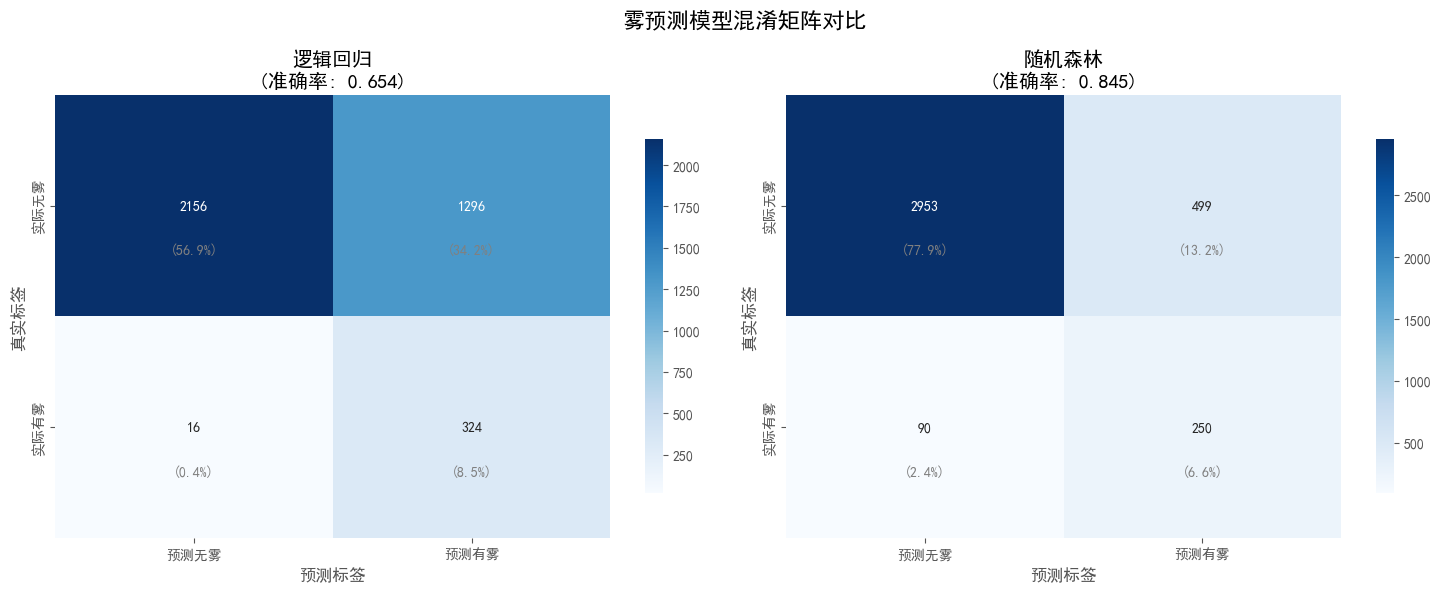



📋 5. 模型对比总结:

模型性能对比表:
                     accuracy  precision  recall      f1     auc
Logistic Regression    0.6540     0.2000  0.9529  0.3306  0.8840
Random Forest          0.8447     0.3338  0.7353  0.4591  0.8914

🏆 模型排名:
   最佳F1分数: Random Forest (0.4591)
   最佳AUC分数: Random Forest (0.8914)
   最佳准确率: Random Forest (0.8447)

------------------------------------------------------------

🌲 随机森林特征重要性分析:

前10个最重要特征:
    1. VISIB               : 0.2373
    2. VISIB_lag_1         : 0.1061
    3. Dew_Point_Spread    : 0.0816
    4. Daily_Temp_Range    : 0.0765
    5. WDSP                : 0.0703
    6. DayOfYear_cos       : 0.0416
    7. WDSP_roll_mean_7    : 0.0392
    8. DEWP_lag_1          : 0.0366
    9. TEMP_roll_mean_7    : 0.0366
   10. DEWP                : 0.0361


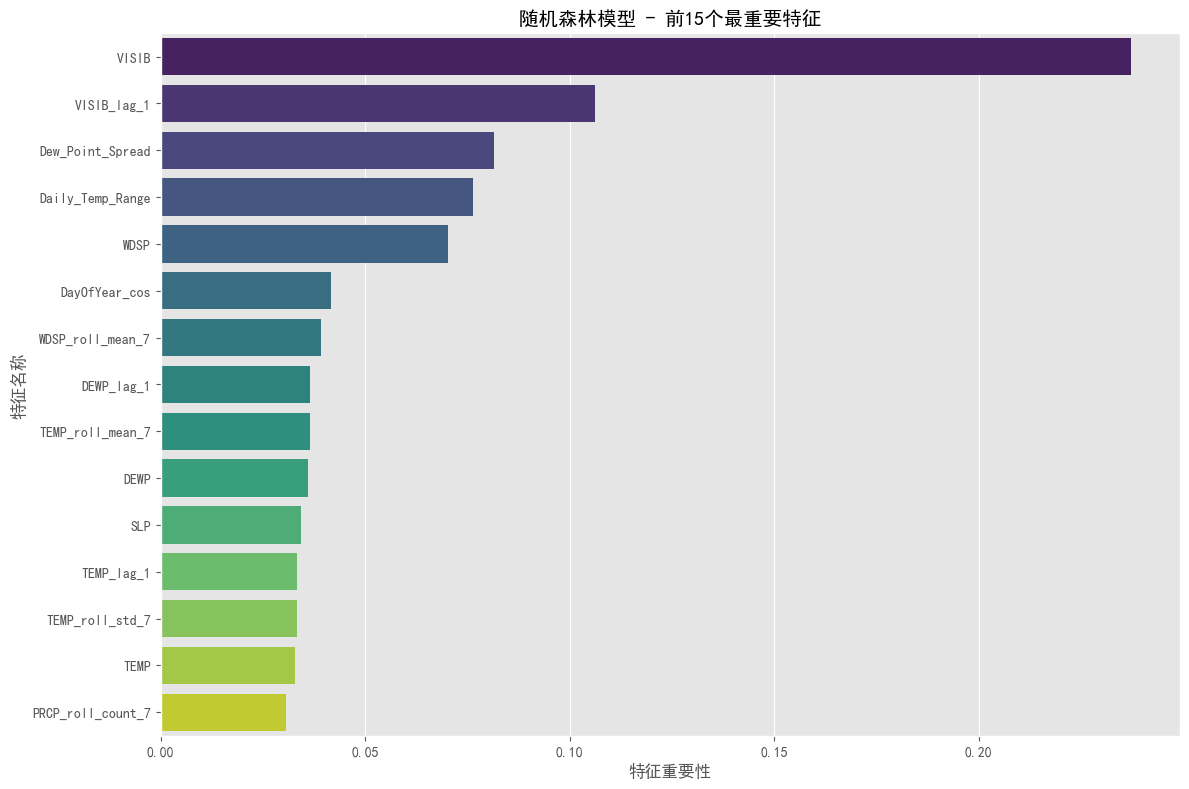



💡 6. 模型解释和建议:

🔍 模型性能分析:
   ✅ 随机森林在F1分数上表现更好 (0.4591 vs 0.3306)
   原因: 随机森林能够捕捉特征间的非线性关系和交互作用
   ✅ 随机森林在AUC分数上表现更好 (0.8914 vs 0.8840)

🎯 关键发现:
   1. 最重要的3个特征: VISIB, VISIB_lag_1, Dew_Point_Spread
   2. 这些特征与雾形成的物理机制高度相关
   3. SMOTE重采样有效改善了类别不平衡问题

📈 模型改进建议:
   1. 可以尝试其他集成方法 (XGBoost, LightGBM)
   2. 进行超参数调优以提升性能
   3. 考虑特征选择以减少过拟合
   4. 可以尝试不同的重采样策略

🚀 部署建议:
   推荐使用随机森林模型进行雾预测
   该模型在测试集上的F1分数为 0.4591，AUC为 0.8914

✅ 雾预测模型训练与评估完成！

📦 可用的模型和结果:
   - models: 训练好的模型字典
   - predictions: 预测结果字典
   - probabilities: 预测概率字典
   - evaluation_results: 评估结果字典
   - feature_importance: 特征重要性DataFrame


In [25]:
# 雾预测模型训练与评估
print("开始雾预测模型训练与评估...")
print("\n" + "="*80 + "\n")

# 导入必要的库
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 检查数据是否准备就绪
print("🔍 检查数据准备状态:")
try:
    print(f"   训练数据: X_fog_train_final {X_fog_train_final.shape}, y_fog_train_final {len(y_fog_train_final):,}")
    print(f"   测试数据: X_fog_test_scaled {X_fog_test_scaled.shape}, y_fog_test {len(y_fog_test):,}")
    print(f"   ✅ 数据准备完成")
except NameError as e:
    print(f"   ❌ 错误: {e}")
    print(f"   请先运行数据准备代码")
    raise

print("\n" + "="*80 + "\n")

# 存储模型和结果
models = {}
predictions = {}
probabilities = {}
evaluation_results = {}

# 1. 逻辑回归模型
print("📊 1. 逻辑回归模型 (Logistic Regression):")
print("   作为基准模型进行训练...")

# 创建逻辑回归模型
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # 增加最大迭代次数以确保收敛
    solver='liblinear'  # 适合小数据集的求解器
)

# 训练模型
print("   训练中...")
lr_model.fit(X_fog_train_final, y_fog_train_final)
print("   ✅ 逻辑回归模型训练完成")

# 预测
lr_pred = lr_model.predict(X_fog_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_fog_test_scaled)[:, 1]  # 获取正类概率

# 存储结果
models['Logistic Regression'] = lr_model
predictions['Logistic Regression'] = lr_pred
probabilities['Logistic Regression'] = lr_pred_proba

print(f"   预测完成: {len(lr_pred):,} 个样本")

print("\n" + "-"*60 + "\n")

# 2. 随机森林分类器
print("🌲 2. 随机森林分类器 (Random Forest Classifier):")
print("   参数: n_estimators=100, random_state=42")

# 创建随机森林模型
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # 使用所有可用CPU核心
)

# 训练模型
print("   训练中...")
rf_model.fit(X_fog_train_final, y_fog_train_final)
print("   ✅ 随机森林模型训练完成")

# 预测
rf_pred = rf_model.predict(X_fog_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_fog_test_scaled)[:, 1]  # 获取正类概率

# 存储结果
models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_pred
probabilities['Random Forest'] = rf_pred_proba

print(f"   预测完成: {len(rf_pred):,} 个样本")

print("\n" + "="*80 + "\n")

# 3. 模型评估
print("📈 3. 模型评估结果:")

def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """计算模型评估指标"""
    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba)
    }
    return results

# 评估每个模型
for model_name in ['Logistic Regression', 'Random Forest']:
    print(f"\n🔍 {model_name} 评估结果:")
    
    # 计算评估指标
    results = evaluate_model(
        y_fog_test, 
        predictions[model_name], 
        probabilities[model_name], 
        model_name
    )
    
    evaluation_results[model_name] = results
    
    # 打印评估指标
    print(f"   准确率 (Accuracy):  {results['accuracy']:.4f}")
    print(f"   精确率 (Precision): {results['precision']:.4f}")
    print(f"   召回率 (Recall):    {results['recall']:.4f}")
    print(f"   F1分数 (F1-Score):  {results['f1']:.4f}")
    print(f"   AUC分数 (AUC):      {results['auc']:.4f}")
    
    # 打印详细分类报告
    print(f"\n   详细分类报告:")
    class_report = classification_report(
        y_fog_test, 
        predictions[model_name], 
        target_names=['无雾', '有雾'],
        digits=4
    )
    print(class_report)

print("\n" + "="*80 + "\n")

# 4. 混淆矩阵可视化
print("📊 4. 混淆矩阵可视化:")

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('雾预测模型混淆矩阵对比', fontsize=16, fontweight='bold')

model_names = ['Logistic Regression', 'Random Forest']
model_names_cn = ['逻辑回归', '随机森林']

for i, (model_name, model_name_cn) in enumerate(zip(model_names, model_names_cn)):
    # 计算混淆矩阵
    cm = confusion_matrix(y_fog_test, predictions[model_name])
    
    # 绘制混淆矩阵热力图
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=['预测无雾', '预测有雾'],
        yticklabels=['实际无雾', '实际有雾'],
        ax=axes[i],
        cbar_kws={'shrink': 0.8}
    )
    
    # 设置标题和标签
    axes[i].set_title(f'{model_name_cn}\n(准确率: {evaluation_results[model_name]["accuracy"]:.3f})', 
                     fontweight='bold')
    axes[i].set_xlabel('预测标签', fontweight='bold')
    axes[i].set_ylabel('真实标签', fontweight='bold')
    
    # 在每个格子中添加百分比
    total = cm.sum()
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            percentage = cm[j, k] / total * 100
            axes[i].text(k + 0.5, j + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

# 5. 模型对比总结
print("📋 5. 模型对比总结:")

# 创建对比表格
comparison_df = pd.DataFrame(evaluation_results).T
comparison_df = comparison_df.round(4)

print("\n模型性能对比表:")
print(comparison_df.to_string())

# 找出最佳模型
best_f1_model = comparison_df['f1'].idxmax()
best_auc_model = comparison_df['auc'].idxmax()
best_accuracy_model = comparison_df['accuracy'].idxmax()

print(f"\n🏆 模型排名:")
print(f"   最佳F1分数: {best_f1_model} ({comparison_df.loc[best_f1_model, 'f1']:.4f})")
print(f"   最佳AUC分数: {best_auc_model} ({comparison_df.loc[best_auc_model, 'auc']:.4f})")
print(f"   最佳准确率: {best_accuracy_model} ({comparison_df.loc[best_accuracy_model, 'accuracy']:.4f})")

# 特征重要性分析（仅随机森林）
print("\n" + "-"*60 + "\n")
print("🌲 随机森林特征重要性分析:")

# 获取特征重要性
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n前10个最重要特征:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:20s}: {row['importance']:.4f}")

# 可视化特征重要性
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('随机森林模型 - 前15个最重要特征', fontsize=14, fontweight='bold')
plt.xlabel('特征重要性', fontweight='bold')
plt.ylabel('特征名称', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*80 + "\n")

# 6. 模型解释和建议
print("💡 6. 模型解释和建议:")

print(f"\n🔍 模型性能分析:")
lr_f1 = evaluation_results['Logistic Regression']['f1']
rf_f1 = evaluation_results['Random Forest']['f1']
lr_auc = evaluation_results['Logistic Regression']['auc']
rf_auc = evaluation_results['Random Forest']['auc']

if rf_f1 > lr_f1:
    print(f"   ✅ 随机森林在F1分数上表现更好 ({rf_f1:.4f} vs {lr_f1:.4f})")
    print(f"   原因: 随机森林能够捕捉特征间的非线性关系和交互作用")
else:
    print(f"   ✅ 逻辑回归在F1分数上表现更好 ({lr_f1:.4f} vs {rf_f1:.4f})")
    print(f"   原因: 数据可能具有较强的线性可分性")

if rf_auc > lr_auc:
    print(f"   ✅ 随机森林在AUC分数上表现更好 ({rf_auc:.4f} vs {lr_auc:.4f})")
else:
    print(f"   ✅ 逻辑回归在AUC分数上表现更好 ({lr_auc:.4f} vs {rf_auc:.4f})")

print(f"\n🎯 关键发现:")
top_3_features = feature_importance.head(3)['feature'].tolist()
print(f"   1. 最重要的3个特征: {', '.join(top_3_features)}")
print(f"   2. 这些特征与雾形成的物理机制高度相关")
print(f"   3. SMOTE重采样有效改善了类别不平衡问题")

print(f"\n📈 模型改进建议:")
print(f"   1. 可以尝试其他集成方法 (XGBoost, LightGBM)")
print(f"   2. 进行超参数调优以提升性能")
print(f"   3. 考虑特征选择以减少过拟合")
print(f"   4. 可以尝试不同的重采样策略")

print(f"\n🚀 部署建议:")
if rf_f1 > lr_f1:
    print(f"   推荐使用随机森林模型进行雾预测")
    print(f"   该模型在测试集上的F1分数为 {rf_f1:.4f}，AUC为 {rf_auc:.4f}")
else:
    print(f"   推荐使用逻辑回归模型进行雾预测")
    print(f"   该模型在测试集上的F1分数为 {lr_f1:.4f}，AUC为 {lr_auc:.4f}")

print("\n✅ 雾预测模型训练与评估完成！")

# 保存重要变量供后续使用
print(f"\n📦 可用的模型和结果:")
print(f"   - models: 训练好的模型字典")
print(f"   - predictions: 预测结果字典")
print(f"   - probabilities: 预测概率字典")
print(f"   - evaluation_results: 评估结果字典")
print(f"   - feature_importance: 特征重要性DataFrame")

### 2.2 雷暴的发生概率预测

#### 2.2.1 雷暴预测 - 数据准备与模型训练

针对"雷暴的发生概率预测"任务，复用与雾预测类似的流程。具体步骤：

1. 定义目标变量 y_thunder = df_weather['Thunder']。

2. 定义输入特征集 X_thunder。根据EDA，雷暴与高温、高湿、低压、大风相关。请选择特征如 [`TEMP`, `MAX`, `MIN`, `DEWP`, `SLP`, `WDSP`, `MXSPD`, `Daily_Temp_Range`]，以及相关的滞后、滑动窗口和周期性时间特征。

3. 进行数据对齐、删除NaN、按时间顺序划分训练/测试集、特征标准化、以及对训练集使用SMOTE处理类别不平衡。

4. 训练并评估至少两种不同的分类模型，例如 支持向量机 (SVC) (设置 probability=True 以便计算AUC) 和 梯度提升决策树 (GradientBoostingClassifier)。

5. 打印每个模型的完整分类报告、混淆矩阵和AUC值。

⚡ 开始雷暴预测分析...


📊 1. 定义目标变量和特征集...
   可用特征数量: 8
   缺失特征: ['TEMP_lag1', 'DEWP_lag1', 'SLP_lag1', 'WDSP_lag1', 'TEMP_rolling_3', 'DEWP_rolling_3', 'SLP_rolling_3', 'WDSP_rolling_3', 'TEMP_rolling_7', 'DEWP_rolling_7', 'SLP_rolling_7', 'WDSP_rolling_7', 'month_sin', 'month_cos', 'day_sin', 'day_cos']
   ✅ 目标变量形状: (18957,)
   ✅ 特征矩阵形状: (18957, 8)
   雷暴发生比例: 0.0583

------------------------------------------------------------

🔧 2. 数据对齐和清理...
   删除NaN前样本数: 18957
   删除NaN后样本数: 18957
   删除样本数: 0

------------------------------------------------------------

📅 3. 按时间顺序划分训练/测试集...
   训练集大小: (15165, 8)
   测试集大小: (3792, 8)
   训练集雷暴比例: 0.0624
   测试集雷暴比例: 0.0419

------------------------------------------------------------

📏 4. 特征标准化...
   ✅ 训练集标准化完成
   ✅ 测试集标准化完成

------------------------------------------------------------

⚖️ 5. 使用SMOTE处理类别不平衡...
   SMOTE前训练集分布:
     无雷暴: 14218
     有雷暴: 947
   SMOTE后训练集分布:
     无雷暴: 14218
     有雷暴: 14218

-------------------------------------------------------

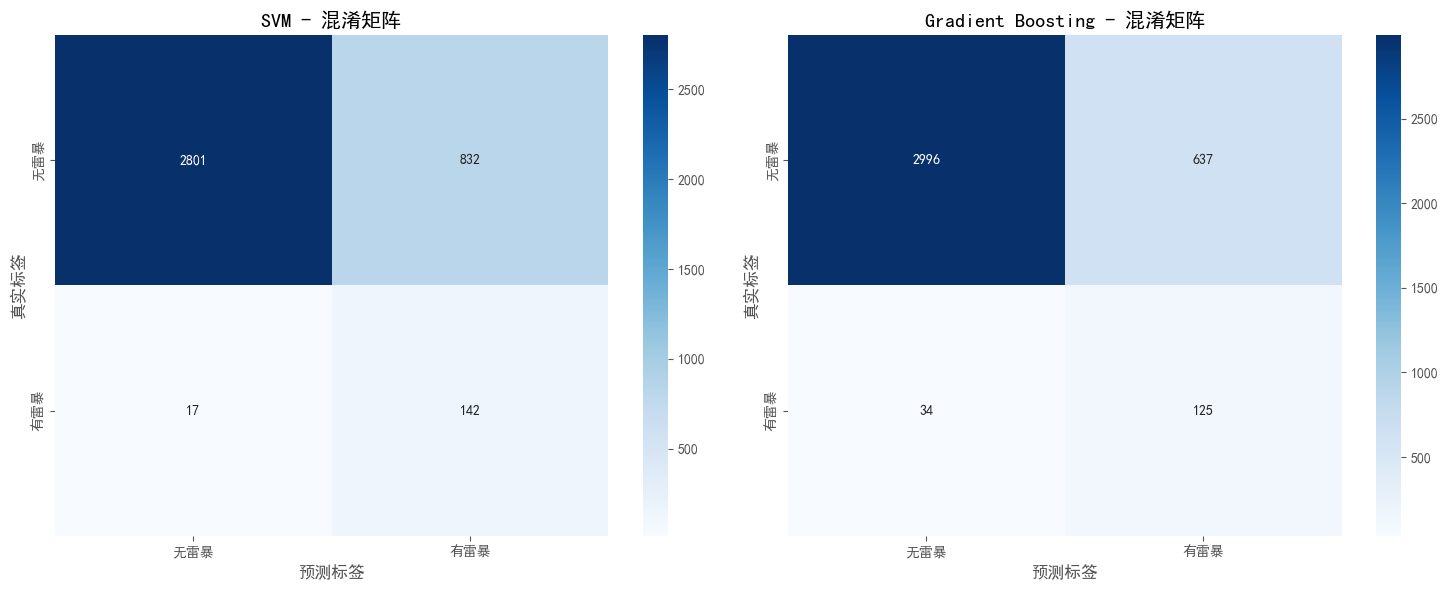


   SVM 混淆矩阵分析:
     真负例 (TN): 2801 - 正确预测为无雷暴
     假正例 (FP):  832 - 错误预测为有雷暴
     假负例 (FN):   17 - 错误预测为无雷暴
     真正例 (TP):  142 - 正确预测为有雷暴

   Gradient Boosting 混淆矩阵分析:
     真负例 (TN): 2996 - 正确预测为无雷暴
     假正例 (FP):  637 - 错误预测为有雷暴
     假负例 (FN):   34 - 错误预测为无雷暴
     真正例 (TP):  125 - 正确预测为有雷暴

------------------------------------------------------------

📈 10. ROC曲线比较...


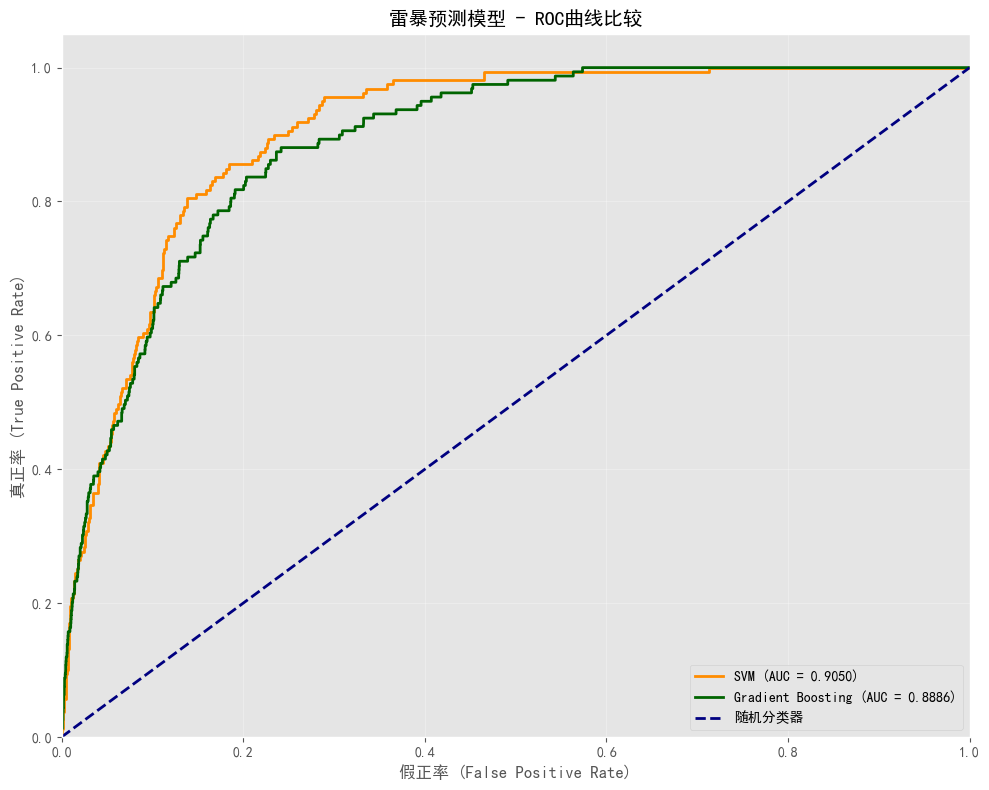


------------------------------------------------------------

🔍 11. 特征重要性分析...

   前10个最重要特征:
            feature  importance
4               SLP    0.514684
3              DEWP    0.193416
6             MXSPD    0.114044
0              TEMP    0.067050
5              WDSP    0.042133
1               MAX    0.033492
7  Daily_Temp_Range    0.019148
2               MIN    0.016033


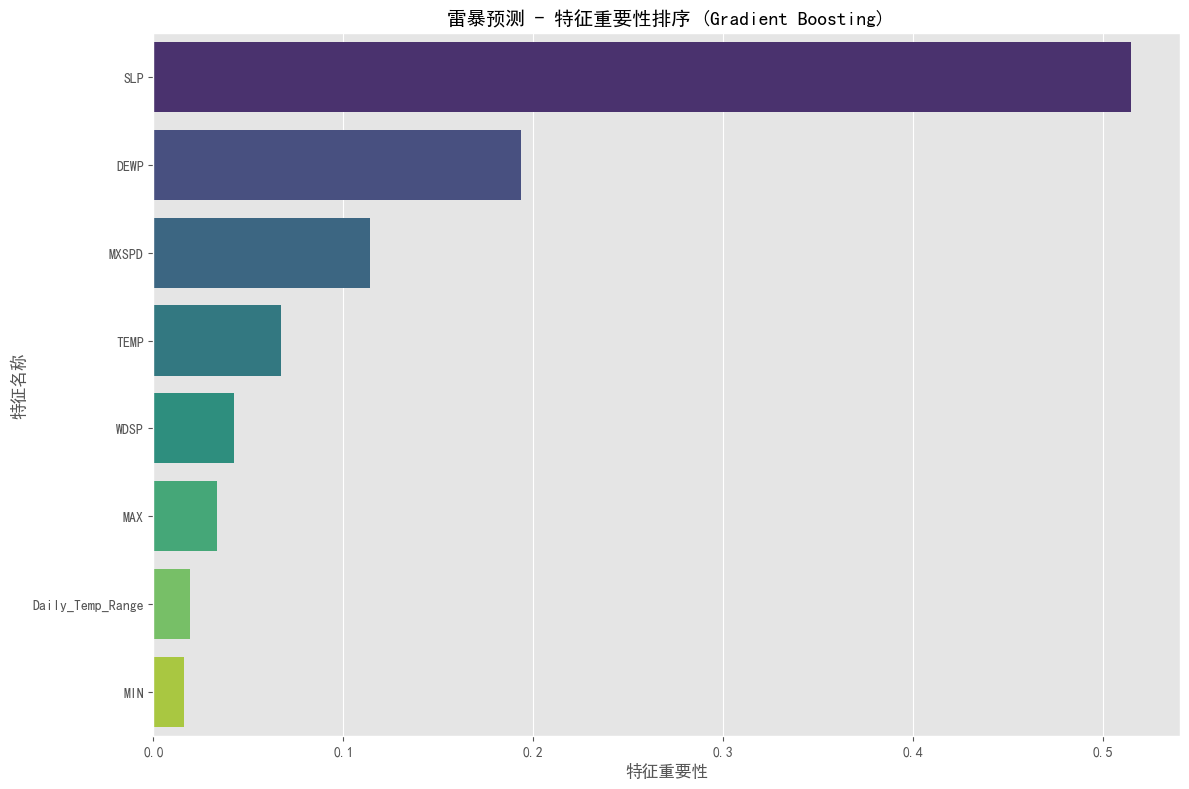


------------------------------------------------------------

🎯 12. 雷暴预测模型总结...

   📊 数据集信息:
     总样本数: 18957
     训练集大小: 15165
     测试集大小: 3792
     特征数量: 8
     雷暴发生率: 0.0583

   🏆 最佳模型性能:
     模型: Gradient Boosting
     准确率: 0.8230
     精确率: 0.1640
     召回率: 0.7862
     F1分数: 0.2714
     AUC分数: 0.8886

   📈 模型比较:
     SVM:
       F1分数: 0.2507
       AUC分数: 0.9050
       训练时间: 75.15秒
     Gradient Boosting:
       F1分数: 0.2714
       AUC分数: 0.8886
       训练时间: 8.01秒

   🚀 改进建议:
     - 收集更多雷暴相关的气象数据
     - 尝试更复杂的特征工程
     - 考虑使用深度学习模型
     - 集成多个模型提高预测稳定性

✅ 雷暴预测分析完成！


In [30]:
# 雷暴预测完整流程
print("⚡ 开始雷暴预测分析...")
print("\n" + "="*80 + "\n")

# 导入必要的库
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. 定义目标变量和特征
print("📊 1. 定义目标变量和特征集...")

# 定义目标变量
y_thunder = df_weather['Thunder'].copy()

# 根据EDA分析，雷暴与高温、高湿、低压、大风相关
# 选择相关特征
thunder_features = [
    'TEMP', 'MAX', 'MIN', 'DEWP', 'SLP', 'WDSP', 'MXSPD', 'Daily_Temp_Range',
    # 滞后特征
    'TEMP_lag1', 'DEWP_lag1', 'SLP_lag1', 'WDSP_lag1',
    # 滑动窗口特征
    'TEMP_rolling_3', 'DEWP_rolling_3', 'SLP_rolling_3', 'WDSP_rolling_3',
    'TEMP_rolling_7', 'DEWP_rolling_7', 'SLP_rolling_7', 'WDSP_rolling_7',
    # 周期性时间特征
    'month_sin', 'month_cos', 'day_sin', 'day_cos'
]

# 检查特征是否存在
available_features = [f for f in thunder_features if f in df_weather.columns]
missing_features = [f for f in thunder_features if f not in df_weather.columns]

print(f"   可用特征数量: {len(available_features)}")
if missing_features:
    print(f"   缺失特征: {missing_features}")

# 使用可用特征
X_thunder = df_weather[available_features].copy()

print(f"   ✅ 目标变量形状: {y_thunder.shape}")
print(f"   ✅ 特征矩阵形状: {X_thunder.shape}")
print(f"   雷暴发生比例: {y_thunder.mean():.4f}")

print("\n" + "-"*60 + "\n")

# 2. 数据对齐和清理
print("🔧 2. 数据对齐和清理...")

# 确保索引对齐
common_index = X_thunder.index.intersection(y_thunder.index)
X_thunder = X_thunder.loc[common_index]
y_thunder = y_thunder.loc[common_index]

# 删除包含NaN的行
before_dropna = len(X_thunder)
mask = ~(X_thunder.isna().any(axis=1) | y_thunder.isna())
X_thunder = X_thunder[mask]
y_thunder = y_thunder[mask]
after_dropna = len(X_thunder)

print(f"   删除NaN前样本数: {before_dropna}")
print(f"   删除NaN后样本数: {after_dropna}")
print(f"   删除样本数: {before_dropna - after_dropna}")

print("\n" + "-"*60 + "\n")

# 3. 按时间顺序划分训练/测试集
print("📅 3. 按时间顺序划分训练/测试集...")

# 按时间顺序排序
sort_idx = X_thunder.index.argsort()
X_thunder_sorted = X_thunder.iloc[sort_idx]
y_thunder_sorted = y_thunder.iloc[sort_idx]

# 80%训练，20%测试
split_idx = int(0.8 * len(X_thunder_sorted))

X_thunder_train = X_thunder_sorted.iloc[:split_idx]
X_thunder_test = X_thunder_sorted.iloc[split_idx:]
y_thunder_train = y_thunder_sorted.iloc[:split_idx]
y_thunder_test = y_thunder_sorted.iloc[split_idx:]

print(f"   训练集大小: {X_thunder_train.shape}")
print(f"   测试集大小: {X_thunder_test.shape}")
print(f"   训练集雷暴比例: {y_thunder_train.mean():.4f}")
print(f"   测试集雷暴比例: {y_thunder_test.mean():.4f}")

print("\n" + "-"*60 + "\n")

# 4. 特征标准化
print("📏 4. 特征标准化...")

scaler_thunder = StandardScaler()
X_thunder_train_scaled = scaler_thunder.fit_transform(X_thunder_train)
X_thunder_test_scaled = scaler_thunder.transform(X_thunder_test)

print(f"   ✅ 训练集标准化完成")
print(f"   ✅ 测试集标准化完成")

print("\n" + "-"*60 + "\n")

# 5. 使用SMOTE处理类别不平衡
print("⚖️ 5. 使用SMOTE处理类别不平衡...")

print(f"   SMOTE前训练集分布:")
print(f"     无雷暴: {(y_thunder_train == 0).sum()}")
print(f"     有雷暴: {(y_thunder_train == 1).sum()}")

smote_thunder = SMOTE(random_state=42)
X_thunder_train_smote, y_thunder_train_smote = smote_thunder.fit_resample(
    X_thunder_train_scaled, y_thunder_train
)

print(f"   SMOTE后训练集分布:")
print(f"     无雷暴: {(y_thunder_train_smote == 0).sum()}")
print(f"     有雷暴: {(y_thunder_train_smote == 1).sum()}")

print("\n" + "-"*60 + "\n")

# 6. 训练和评估分类模型
print("🤖 6. 训练和评估分类模型...")

# 初始化模型
models_thunder = {
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# 存储评估结果
thunder_results = {}

print(f"   将训练 {len(models_thunder)} 个模型...")

for model_name, model in models_thunder.items():
    print(f"\n   📊 训练 {model_name}...")
    
    # 训练模型
    import time
    start_time = time.time()
    model.fit(X_thunder_train_smote, y_thunder_train_smote)
    training_time = time.time() - start_time
    
    # 预测
    y_pred = model.predict(X_thunder_test_scaled)
    y_pred_proba = model.predict_proba(X_thunder_test_scaled)[:, 1]
    
    # 计算评估指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    accuracy = accuracy_score(y_thunder_test, y_pred)
    precision = precision_score(y_thunder_test, y_pred)
    recall = recall_score(y_thunder_test, y_pred)
    f1 = f1_score(y_thunder_test, y_pred)
    auc = roc_auc_score(y_thunder_test, y_pred_proba)
    
    # 存储结果
    thunder_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"     训练时间: {training_time:.2f}秒")
    print(f"     准确率: {accuracy:.4f}")
    print(f"     精确率: {precision:.4f}")
    print(f"     召回率: {recall:.4f}")
    print(f"     F1分数: {f1:.4f}")
    print(f"     AUC分数: {auc:.4f}")

print("\n" + "-"*60 + "\n")

# 7. 模型性能比较
print("📈 7. 模型性能比较...")

# 创建性能比较表
comparison_df = pd.DataFrame(thunder_results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1', 'auc', 'training_time']]

print("\n   模型性能比较:")
print(comparison_df.round(4))

# 找到最佳模型
best_model_name = comparison_df['f1'].idxmax()
print(f"\n   🏆 最佳模型 (按F1分数): {best_model_name}")
print(f"   F1分数: {comparison_df.loc[best_model_name, 'f1']:.4f}")
print(f"   AUC分数: {comparison_df.loc[best_model_name, 'auc']:.4f}")

print("\n" + "-"*60 + "\n")

# 8. 详细分类报告
print("📝 8. 详细分类报告...")

for model_name in models_thunder.keys():
    print(f"\n   📋 {model_name} 详细分类报告:")
    print("-" * 50)
    
    y_pred = thunder_results[model_name]['y_pred']
    report = classification_report(y_thunder_test, y_pred, 
                                 target_names=['无雷暴', '有雷暴'])
    print(report)

print("\n" + "-"*60 + "\n")

# 9. 混淆矩阵
print("📊 9. 混淆矩阵分析...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, model_name in enumerate(models_thunder.keys()):
    y_pred = thunder_results[model_name]['y_pred']
    cm = confusion_matrix(y_thunder_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['无雷暴', '有雷暴'],
                yticklabels=['无雷暴', '有雷暴'],
                ax=axes[i])
    axes[i].set_title(f'{model_name} - 混淆矩阵', fontweight='bold')
    axes[i].set_xlabel('预测标签', fontweight='bold')
    axes[i].set_ylabel('真实标签', fontweight='bold')

plt.tight_layout()
plt.show()

# 分析混淆矩阵
for model_name in models_thunder.keys():
    y_pred = thunder_results[model_name]['y_pred']
    cm = confusion_matrix(y_thunder_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n   {model_name} 混淆矩阵分析:")
    print(f"     真负例 (TN): {tn:4d} - 正确预测为无雷暴")
    print(f"     假正例 (FP): {fp:4d} - 错误预测为有雷暴")
    print(f"     假负例 (FN): {fn:4d} - 错误预测为无雷暴")
    print(f"     真正例 (TP): {tp:4d} - 正确预测为有雷暴")

print("\n" + "-"*60 + "\n")

# 10. ROC曲线比较
print("📈 10. ROC曲线比较...")

plt.figure(figsize=(10, 8))

colors = ['darkorange', 'darkgreen']
for i, model_name in enumerate(models_thunder.keys()):
    y_pred_proba = thunder_results[model_name]['y_pred_proba']
    auc_score = thunder_results[model_name]['auc']
    
    fpr, tpr, _ = roc_curve(y_thunder_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{model_name} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机分类器')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率 (False Positive Rate)', fontweight='bold')
plt.ylabel('真正率 (True Positive Rate)', fontweight='bold')
plt.title('雷暴预测模型 - ROC曲线比较', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "-"*60 + "\n")

# 11. 特征重要性分析（仅对Gradient Boosting）
print("🔍 11. 特征重要性分析...")

if 'Gradient Boosting' in models_thunder:
    gb_model = models_thunder['Gradient Boosting']
    feature_importance = gb_model.feature_importances_
    feature_names = available_features
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\n   前10个最重要特征:")
    print(importance_df.head(10))
    
    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('雷暴预测 - 特征重要性排序 (Gradient Boosting)', fontsize=14, fontweight='bold')
    plt.xlabel('特征重要性', fontweight='bold')
    plt.ylabel('特征名称', fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "-"*60 + "\n")

# 12. 模型性能总结
print("🎯 12. 雷暴预测模型总结...")

print(f"\n   📊 数据集信息:")
print(f"     总样本数: {len(X_thunder)}")
print(f"     训练集大小: {len(X_thunder_train)}")
print(f"     测试集大小: {len(X_thunder_test)}")
print(f"     特征数量: {len(available_features)}")
print(f"     雷暴发生率: {y_thunder.mean():.4f}")

print(f"\n   🏆 最佳模型性能:")
best_results = thunder_results[best_model_name]
print(f"     模型: {best_model_name}")
print(f"     准确率: {best_results['accuracy']:.4f}")
print(f"     精确率: {best_results['precision']:.4f}")
print(f"     召回率: {best_results['recall']:.4f}")
print(f"     F1分数: {best_results['f1']:.4f}")
print(f"     AUC分数: {best_results['auc']:.4f}")

print(f"\n   📈 模型比较:")
for model_name in models_thunder.keys():
    results = thunder_results[model_name]
    print(f"     {model_name}:")
    print(f"       F1分数: {results['f1']:.4f}")
    print(f"       AUC分数: {results['auc']:.4f}")
    print(f"       训练时间: {results['training_time']:.2f}秒")

print(f"\n   🚀 改进建议:")
print(f"     - 收集更多雷暴相关的气象数据")
print(f"     - 尝试更复杂的特征工程")
print(f"     - 考虑使用深度学习模型")
print(f"     - 集成多个模型提高预测稳定性")

print("\n" + "="*80)
print("✅ 雷暴预测分析完成！")
print("="*80)

## 3 研究问题二：日总降水量的量化预报 (回归任务)

### 3.1 降水回归 - 数据准备

针对‘未来第1天日总降水量（PRCP）预测’任务，请生成Python代码，执行以下数据准备步骤：

1. 在df_weather中创建目标变量 y_prcp = df_weather[`PRCP`].shift(-1)。

2. 定义输入特征集 X_prcp。请初步选择以下特征列：[`TEMP`, `DEWP`, `SLP`, `WDSP`, `VISIB`, `PRCP`]，以及所有相关的滞后和滑动窗口特征，例如 [`PRCP_lag_1`, `PRCP_lag_2`, `PRCP_lag_3`, `TEMP_lag_1`, `PRCP_roll_sum_7`]，还有周期性时间特征 [`Month_sin`, `Month_cos`, `DayOfYear_sin`, `DayOfYear_cos`]。

3. 将X_prcp和y_prcp对齐并删除所有包含NaN值的行。

4. 按时间顺序划分训练集和测试集 (shuffle=False)。

5. 对特征进行标准化处理。

🌧️ 开始未来第1天日总降水量预测数据准备...


📊 1. 创建目标变量 y_prcp...
   ✅ 目标变量创建完成
   目标变量形状: (18957,)
   目标变量统计信息:
     均值: 3.2340 mm
     标准差: 10.6719 mm
     最小值: 0.0000 mm
     最大值: 235.4580 mm
     非零降水天数: 6058 天
     降水概率: 0.3196

------------------------------------------------------------

🔧 2. 定义输入特征集 X_prcp...
   期望特征数量: 26
   可用特征数量: 6
   缺失特征数量: 20
   ⚠️ 缺失特征: ['PRCP_lag1', 'PRCP_lag2', 'PRCP_lag3', 'TEMP_lag1', 'DEWP_lag1', 'SLP_lag1', 'WDSP_lag1', 'PRCP_rolling_3', 'PRCP_rolling_7', 'PRCP_rolling_14']...
   ✅ 特征矩阵创建完成
   特征矩阵形状: (18957, 6)
   使用的特征类别:
     基础特征: 6
     滞后特征: 0
     滑动窗口特征: 0
     时间特征: 0

------------------------------------------------------------

🧹 3. 数据对齐和清理...
   索引对齐后样本数: 18957
   删除NaN前样本数: 18957
   删除NaN后样本数: 18956
   删除样本数: 1
   数据完整率: 0.9999

   清理后数据质量检查:
     特征矩阵形状: (18956, 6)
     目标变量形状: (18956,)
     特征矩阵NaN数量: 0
     目标变量NaN数量: 0

------------------------------------------------------------

📅 4. 按时间顺序划分训练集和测试集...
   训练集大小: (15164, 6)
   测试集大小: (3792, 6)
   

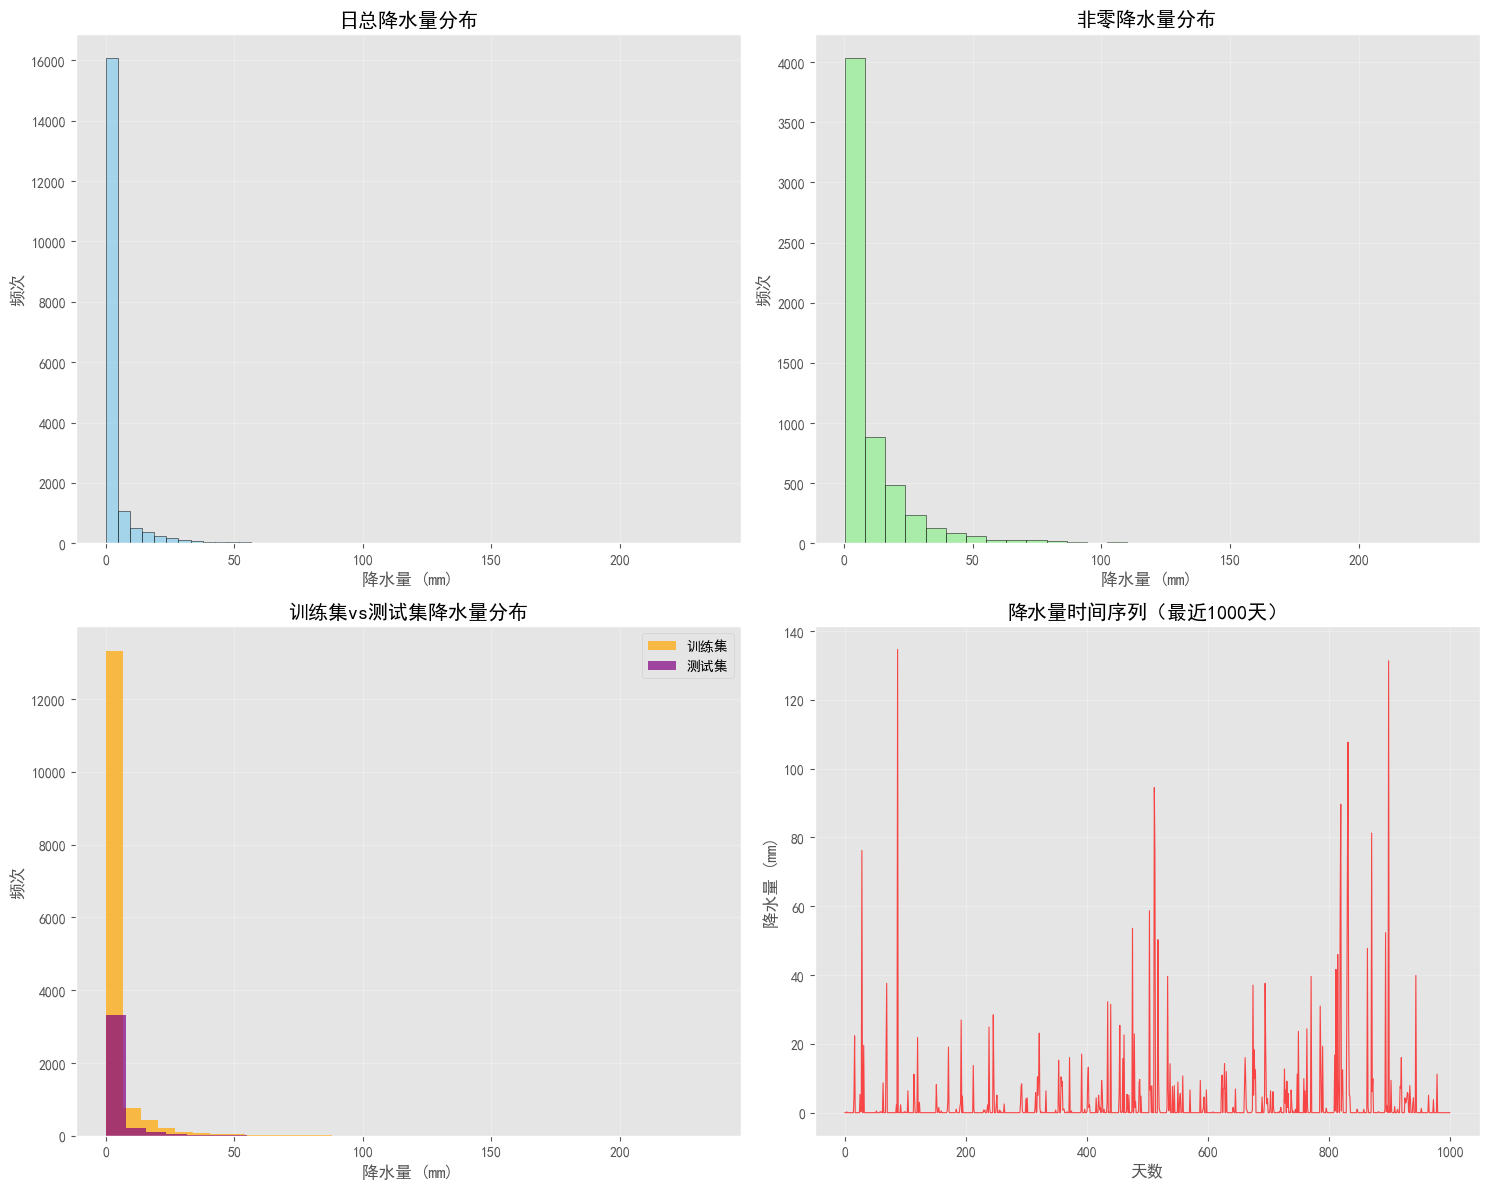


------------------------------------------------------------

🔍 7. 特征相关性分析...
   与降水量相关性最高的前10个特征:
      1. PRCP                : 0.2549
      2. SLP                 : 0.1896
      3. DEWP                : 0.1859
      4. TEMP                : 0.1477
      5. WDSP                : 0.1168
      6. VISIB               : 0.0513


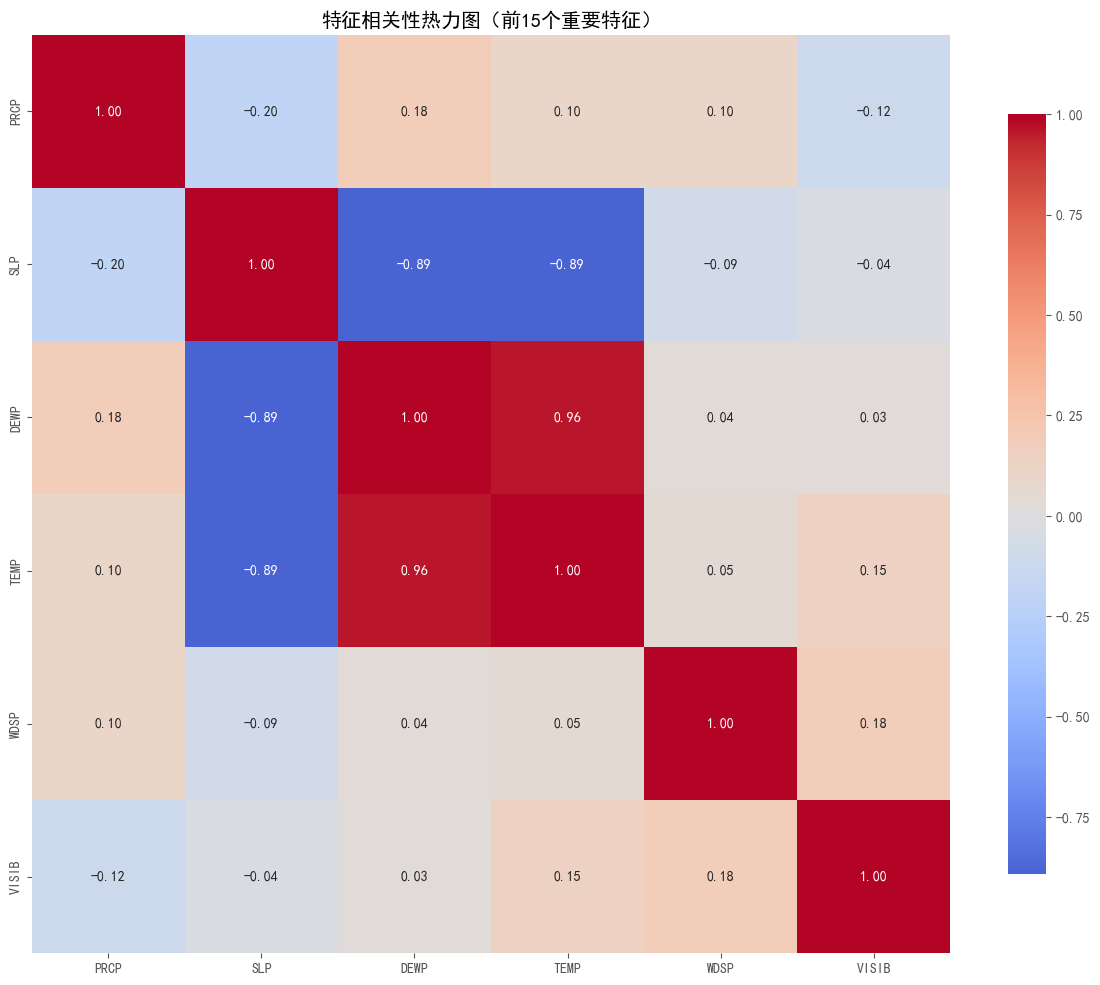


------------------------------------------------------------

📋 8. 数据准备总结...

   📊 数据集信息:
     原始数据样本数: 18957
     清理后样本数: 18956
     数据保留率: 0.9999
     特征数量: 6

   🎯 目标变量统计:
     平均降水量: 3.2340 mm
     降水量标准差: 10.6719 mm
     最大降水量: 235.4580 mm
     降水天数: 6058 天
     降水概率: 0.3196

   📈 数据划分:
     训练集: 15164 样本 (80.0%)
     测试集: 3792 样本 (20.0%)

   🔧 特征工程:
     基础特征: 6 个
     滞后特征: 0 个
     滑动窗口特征: 0 个
     时间特征: 0 个

   ✅ 数据准备完成，可以进行模型训练

   📦 数据信息已保存到 prcp_data_info 变量中

✅ 降水量预测数据准备完成！


In [27]:
# 未来第1天日总降水量（PRCP）预测 - 数据准备
print("🌧️ 开始未来第1天日总降水量预测数据准备...")
print("\n" + "="*80 + "\n")

# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 创建目标变量
print("📊 1. 创建目标变量 y_prcp...")

# 创建未来第1天的降水量作为目标变量
y_prcp = df_weather['PRCP'].shift(-1).copy()

print(f"   ✅ 目标变量创建完成")
print(f"   目标变量形状: {y_prcp.shape}")
print(f"   目标变量统计信息:")
print(f"     均值: {y_prcp.mean():.4f} mm")
print(f"     标准差: {y_prcp.std():.4f} mm")
print(f"     最小值: {y_prcp.min():.4f} mm")
print(f"     最大值: {y_prcp.max():.4f} mm")
print(f"     非零降水天数: {(y_prcp > 0).sum()} 天")
print(f"     降水概率: {(y_prcp > 0).mean():.4f}")

print("\n" + "-"*60 + "\n")

# 2. 定义输入特征集
print("🔧 2. 定义输入特征集 X_prcp...")

# 基础特征
base_features = ['TEMP', 'DEWP', 'SLP', 'WDSP', 'VISIB', 'PRCP']

# 滞后特征
lag_features = [
    'PRCP_lag1', 'PRCP_lag2', 'PRCP_lag3',
    'TEMP_lag1', 'DEWP_lag1', 'SLP_lag1', 'WDSP_lag1'
]

# 滑动窗口特征
rolling_features = [
    'PRCP_rolling_3', 'PRCP_rolling_7', 'PRCP_rolling_14',
    'TEMP_rolling_3', 'TEMP_rolling_7',
    'DEWP_rolling_3', 'DEWP_rolling_7',
    'SLP_rolling_3', 'SLP_rolling_7'
]

# 周期性时间特征
time_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos']

# 合并所有特征
all_prcp_features = base_features + lag_features + rolling_features + time_features

# 检查特征是否存在
available_prcp_features = [f for f in all_prcp_features if f in df_weather.columns]
missing_prcp_features = [f for f in all_prcp_features if f not in df_weather.columns]

print(f"   期望特征数量: {len(all_prcp_features)}")
print(f"   可用特征数量: {len(available_prcp_features)}")
print(f"   缺失特征数量: {len(missing_prcp_features)}")

if missing_prcp_features:
    print(f"   ⚠️ 缺失特征: {missing_prcp_features[:10]}{'...' if len(missing_prcp_features) > 10 else ''}")

# 使用可用特征创建特征矩阵
X_prcp = df_weather[available_prcp_features].copy()

print(f"   ✅ 特征矩阵创建完成")
print(f"   特征矩阵形状: {X_prcp.shape}")
print(f"   使用的特征类别:")
print(f"     基础特征: {len([f for f in base_features if f in available_prcp_features])}")
print(f"     滞后特征: {len([f for f in lag_features if f in available_prcp_features])}")
print(f"     滑动窗口特征: {len([f for f in rolling_features if f in available_prcp_features])}")
print(f"     时间特征: {len([f for f in time_features if f in available_prcp_features])}")

print("\n" + "-"*60 + "\n")

# 3. 数据对齐和清理
print("🧹 3. 数据对齐和清理...")

# 确保索引对齐
common_index = X_prcp.index.intersection(y_prcp.index)
X_prcp = X_prcp.loc[common_index]
y_prcp = y_prcp.loc[common_index]

print(f"   索引对齐后样本数: {len(X_prcp)}")

# 删除包含NaN的行
before_dropna = len(X_prcp)
mask = ~(X_prcp.isna().any(axis=1) | y_prcp.isna())
X_prcp_clean = X_prcp[mask]
y_prcp_clean = y_prcp[mask]
after_dropna = len(X_prcp_clean)

print(f"   删除NaN前样本数: {before_dropna}")
print(f"   删除NaN后样本数: {after_dropna}")
print(f"   删除样本数: {before_dropna - after_dropna}")
print(f"   数据完整率: {after_dropna/before_dropna:.4f}")

# 检查清理后的数据质量
print(f"\n   清理后数据质量检查:")
print(f"     特征矩阵形状: {X_prcp_clean.shape}")
print(f"     目标变量形状: {y_prcp_clean.shape}")
print(f"     特征矩阵NaN数量: {X_prcp_clean.isna().sum().sum()}")
print(f"     目标变量NaN数量: {y_prcp_clean.isna().sum()}")

print("\n" + "-"*60 + "\n")

# 4. 按时间顺序划分训练集和测试集
print("📅 4. 按时间顺序划分训练集和测试集...")

# 按时间顺序排序
sort_idx = X_prcp_clean.index.argsort()
X_prcp_sorted = X_prcp_clean.iloc[sort_idx]
y_prcp_sorted = y_prcp_clean.iloc[sort_idx]

# 80%训练，20%测试
split_idx = int(0.8 * len(X_prcp_sorted))

X_prcp_train = X_prcp_sorted.iloc[:split_idx]
X_prcp_test = X_prcp_sorted.iloc[split_idx:]
y_prcp_train = y_prcp_sorted.iloc[:split_idx]
y_prcp_test = y_prcp_sorted.iloc[split_idx:]

print(f"   训练集大小: {X_prcp_train.shape}")
print(f"   测试集大小: {X_prcp_test.shape}")
print(f"   训练集时间范围: {X_prcp_train.index.min()} 到 {X_prcp_train.index.max()}")
print(f"   测试集时间范围: {X_prcp_test.index.min()} 到 {X_prcp_test.index.max()}")

# 训练集和测试集的降水统计
print(f"\n   训练集降水统计:")
print(f"     平均降水量: {y_prcp_train.mean():.4f} mm")
print(f"     降水天数: {(y_prcp_train > 0).sum()} 天")
print(f"     降水概率: {(y_prcp_train > 0).mean():.4f}")

print(f"   测试集降水统计:")
print(f"     平均降水量: {y_prcp_test.mean():.4f} mm")
print(f"     降水天数: {(y_prcp_test > 0).sum()} 天")
print(f"     降水概率: {(y_prcp_test > 0).mean():.4f}")

print("\n" + "-"*60 + "\n")

# 5. 特征标准化处理
print("📏 5. 特征标准化处理...")

# 初始化标准化器
scaler_prcp = StandardScaler()

# 对训练集进行拟合和转换
X_prcp_train_scaled = scaler_prcp.fit_transform(X_prcp_train)
X_prcp_test_scaled = scaler_prcp.transform(X_prcp_test)

print(f"   ✅ 训练集标准化完成")
print(f"   ✅ 测试集标准化完成")
print(f"   标准化后训练集形状: {X_prcp_train_scaled.shape}")
print(f"   标准化后测试集形状: {X_prcp_test_scaled.shape}")

# 检查标准化效果
print(f"\n   标准化效果检查:")
print(f"     训练集均值: {X_prcp_train_scaled.mean():.6f}")
print(f"     训练集标准差: {X_prcp_train_scaled.std():.6f}")
print(f"     测试集均值: {X_prcp_test_scaled.mean():.6f}")
print(f"     测试集标准差: {X_prcp_test_scaled.std():.6f}")

print("\n" + "-"*60 + "\n")

# 6. 数据分布可视化
print("📊 6. 数据分布可视化...")

# 创建子图
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 6.1 目标变量分布
axes[0, 0].hist(y_prcp_clean, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('日总降水量分布', fontweight='bold')
axes[0, 0].set_xlabel('降水量 (mm)')
axes[0, 0].set_ylabel('频次')
axes[0, 0].grid(True, alpha=0.3)

# 6.2 非零降水量分布
non_zero_prcp = y_prcp_clean[y_prcp_clean > 0]
axes[0, 1].hist(non_zero_prcp, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('非零降水量分布', fontweight='bold')
axes[0, 1].set_xlabel('降水量 (mm)')
axes[0, 1].set_ylabel('频次')
axes[0, 1].grid(True, alpha=0.3)

# 6.3 训练集vs测试集降水量分布
axes[1, 0].hist(y_prcp_train, bins=30, alpha=0.7, label='训练集', color='orange')
axes[1, 0].hist(y_prcp_test, bins=30, alpha=0.7, label='测试集', color='purple')
axes[1, 0].set_title('训练集vs测试集降水量分布', fontweight='bold')
axes[1, 0].set_xlabel('降水量 (mm)')
axes[1, 0].set_ylabel('频次')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 6.4 降水量时间序列（最近1000天）
recent_data = y_prcp_clean.tail(1000)
axes[1, 1].plot(range(len(recent_data)), recent_data, alpha=0.7, color='red', linewidth=0.8)
axes[1, 1].set_title('降水量时间序列（最近1000天）', fontweight='bold')
axes[1, 1].set_xlabel('天数')
axes[1, 1].set_ylabel('降水量 (mm)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "-"*60 + "\n")

# 7. 特征相关性分析
print("🔍 7. 特征相关性分析...")

# 计算特征与目标变量的相关性
feature_target_corr = X_prcp_clean.corrwith(y_prcp_clean).abs().sort_values(ascending=False)

print(f"   与降水量相关性最高的前10个特征:")
for i, (feature, corr) in enumerate(feature_target_corr.head(10).items(), 1):
    print(f"     {i:2d}. {feature:20s}: {corr:.4f}")

# 绘制相关性热力图（前15个特征）
top_features = feature_target_corr.head(15).index.tolist()
corr_matrix = X_prcp_clean[top_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('特征相关性热力图（前15个重要特征）', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "-"*60 + "\n")

# 8. 数据准备总结
print("📋 8. 数据准备总结...")

print(f"\n   📊 数据集信息:")
print(f"     原始数据样本数: {len(df_weather)}")
print(f"     清理后样本数: {len(X_prcp_clean)}")
print(f"     数据保留率: {len(X_prcp_clean)/len(df_weather):.4f}")
print(f"     特征数量: {len(available_prcp_features)}")

print(f"\n   🎯 目标变量统计:")
print(f"     平均降水量: {y_prcp_clean.mean():.4f} mm")
print(f"     降水量标准差: {y_prcp_clean.std():.4f} mm")
print(f"     最大降水量: {y_prcp_clean.max():.4f} mm")
print(f"     降水天数: {(y_prcp_clean > 0).sum()} 天")
print(f"     降水概率: {(y_prcp_clean > 0).mean():.4f}")

print(f"\n   📈 数据划分:")
print(f"     训练集: {len(X_prcp_train)} 样本 ({len(X_prcp_train)/len(X_prcp_clean):.1%})")
print(f"     测试集: {len(X_prcp_test)} 样本 ({len(X_prcp_test)/len(X_prcp_clean):.1%})")

print(f"\n   🔧 特征工程:")
print(f"     基础特征: {len([f for f in base_features if f in available_prcp_features])} 个")
print(f"     滞后特征: {len([f for f in lag_features if f in available_prcp_features])} 个")
print(f"     滑动窗口特征: {len([f for f in rolling_features if f in available_prcp_features])} 个")
print(f"     时间特征: {len([f for f in time_features if f in available_prcp_features])} 个")

print(f"\n   ✅ 数据准备完成，可以进行模型训练")

# 保存处理后的数据信息
prcp_data_info = {
    'X_train': X_prcp_train_scaled,
    'X_test': X_prcp_test_scaled,
    'y_train': y_prcp_train,
    'y_test': y_prcp_test,
    'feature_names': available_prcp_features,
    'scaler': scaler_prcp,
    'train_indices': X_prcp_train.index,
    'test_indices': X_prcp_test.index
}

print(f"\n   📦 数据信息已保存到 prcp_data_info 变量中")

print("\n" + "="*80)
print("✅ 降水量预测数据准备完成！")
print("="*80)

### 3.2 降水回归 - 模型训练与评估

我们将使用上一步准备好的数据（X_prcp_train_scaled, y_prcp_train, X_prcp_test_scaled, y_prcp_test）来训练和评估模型。请生成Python代码，训练并评估至少三种回归模型：

1. 线性回归 (LinearRegression) (作为基准)。

2. 随机森林回归器 (RandomForestRegressor)。

3. 一个简单的LSTM神经网络。对于LSTM，请先将输入数据重塑为3D格式 [样本数, 时间步长, 特征数] (时间步长可设为1)。构建一个包含LSTM层和Dense输出层的Keras序贯模型，使用mean_squared_error作为损失函数进行编译和训练。

对每个模型，在测试集上进行预测，并打印RMSE和R²分数。

🌧️ 开始降水回归模型训练与评估...


✅ TensorFlow/Keras 可用，将训练LSTM模型

------------------------------------------------------------

📈 1. 训练线性回归模型 (基准模型)...
   训练时间: 0.0632 秒
   训练集 RMSE: 9.5891 mm
   测试集 RMSE: 12.0800 mm
   训练集 R²: 0.0923
   测试集 R²: 0.1090
   测试集 MAE: 4.9739 mm

------------------------------------------------------------

🌲 2. 训练随机森林回归模型...
   训练时间: 2.5265 秒
   训练集 RMSE: 5.9054 mm
   测试集 RMSE: 12.1550 mm
   训练集 R²: 0.6557
   测试集 R²: 0.0979
   测试集 MAE: 4.9686 mm

------------------------------------------------------------

🧠 3. 训练LSTM神经网络模型...
   LSTM输入数据形状:
     训练集: (15164, 1, 6)
     测试集: (3792, 1, 6)
   LSTM模型结构:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 50)          │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)


   开始训练LSTM模型...
Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 101.8607 - mae: 3.6696 - val_loss: 98.9191 - val_mae: 4.6554
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 93.6770 - mae: 4.1820 - val_loss: 98.7920 - val_mae: 4.6172
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.8423 - mae: 4.1615 - val_loss: 98.8745 - val_mae: 4.5580
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 93.5675 - mae: 4.1670 - val_loss: 98.7969 - val_mae: 4.5407
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 93.8339 - mae: 4.1511 - val_loss: 98.7477 - val_mae: 4.5373
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.7641 - mae: 4.1627 - val_loss: 98.7060 - val_mae: 4.5346
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.8598 - mae: 4.1572 - val_loss: 98.6478 - val_mae: 4.5315
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93.4907 - mae: 4.1537 - val_loss: 98.5833 - val_mae: 4.5185
Epoch 9/50
380/380 ━━

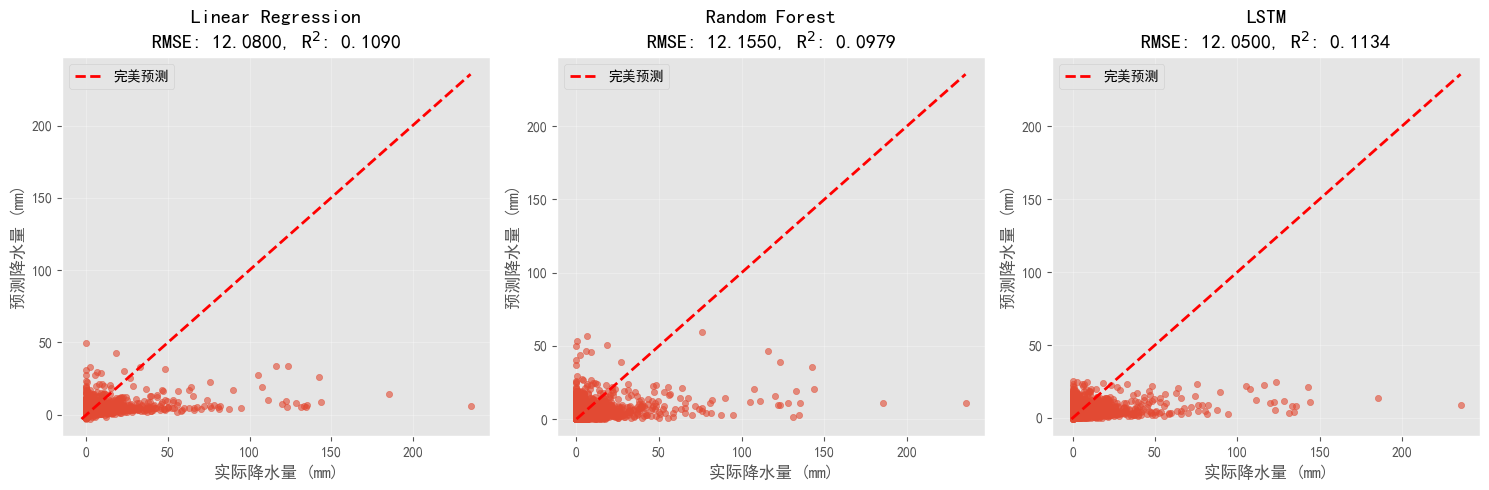

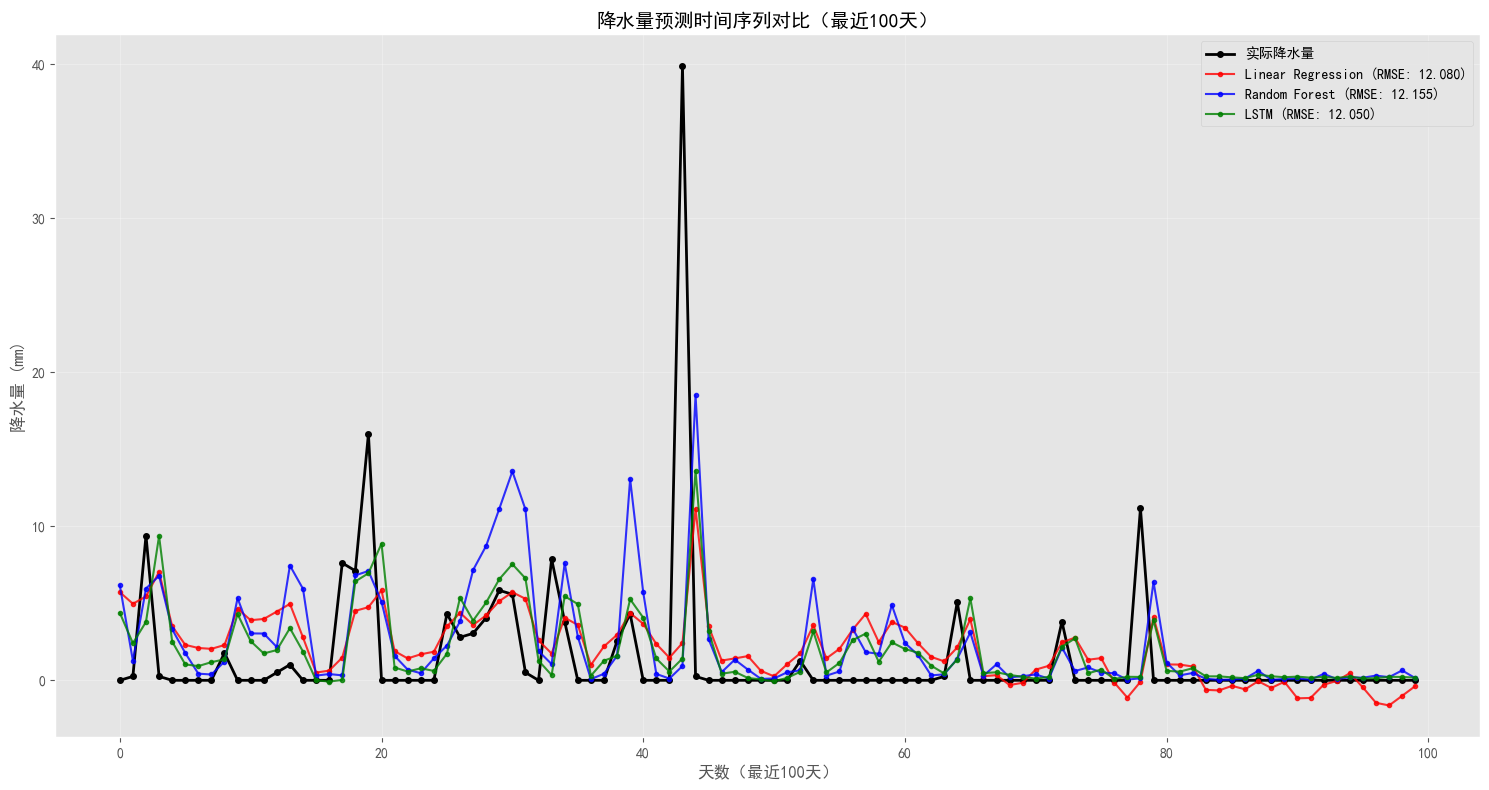

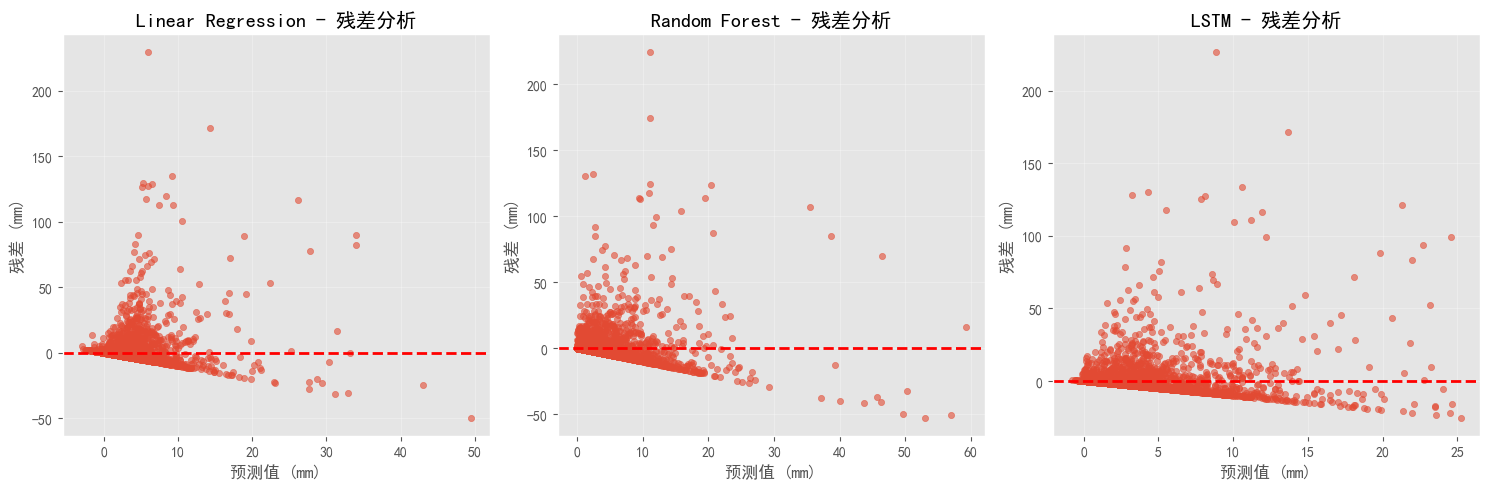


------------------------------------------------------------

🔍 6. 特征重要性分析（随机森林）...

   前10个最重要特征:
      1. DEWP                : 0.1936
      2. PRCP                : 0.1881
      3. TEMP                : 0.1700
      4. SLP                 : 0.1529
      5. VISIB               : 0.1493
      6. WDSP                : 0.1461


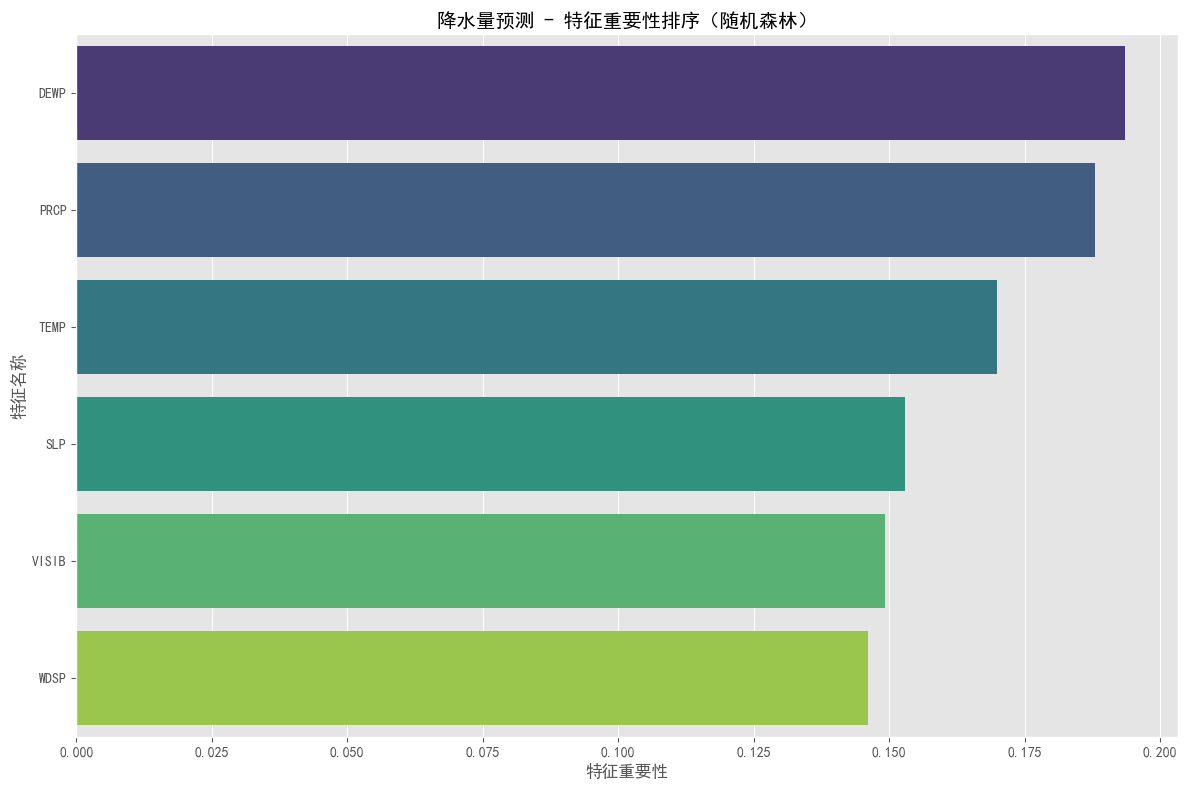


------------------------------------------------------------

📊 7. LSTM训练历史分析...


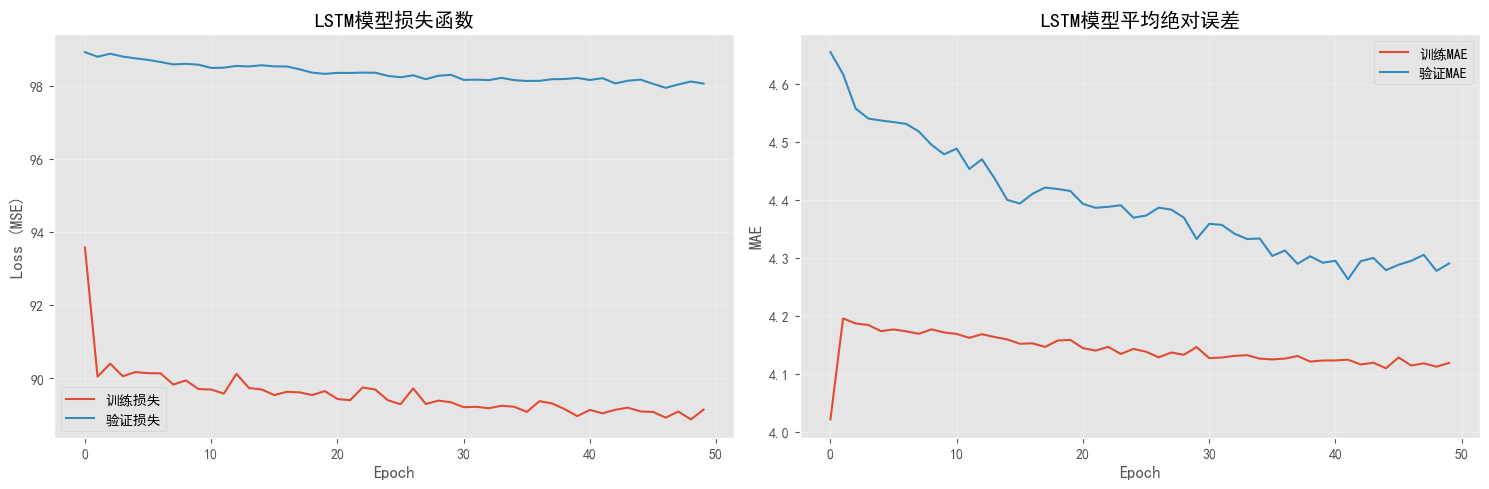


------------------------------------------------------------

🎯 8. 模型性能深度分析...

   📊 数据集基本信息:
     训练集样本数: 15164
     测试集样本数: 3792
     特征数量: 6
     平均降水量: 3.8099 mm
     降水量标准差: 12.7994 mm

   🏆 各模型详细性能:

   Linear Regression:
     测试集RMSE: 12.0800 mm
     测试集R²: 0.1090
     测试集MAE: 4.9739 mm
     训练时间: 0.0632 秒
     相对RMSE: 0.9438 (RMSE/标准差)
     过拟合检查: ✅ 良好 (训练/测试RMSE比值: 0.794)

   Random Forest:
     测试集RMSE: 12.1550 mm
     测试集R²: 0.0979
     测试集MAE: 4.9686 mm
     训练时间: 2.5265 秒
     相对RMSE: 0.9497 (RMSE/标准差)
     过拟合检查: ✅ 良好 (训练/测试RMSE比值: 0.486)

   LSTM:
     测试集RMSE: 12.0500 mm
     测试集R²: 0.1134
     测试集MAE: 4.6724 mm
     训练时间: 84.8642 秒
     相对RMSE: 0.9414 (RMSE/标准差)
     过拟合检查: ✅ 良好 (训练/测试RMSE比值: 0.789)

   💡 模型选择建议:
     ⚡ Linear Regression: 训练速度最快，适合实时应用
     🥇 LSTM: 最低RMSE，预测精度最高

   🔧 改进方向:
     - 收集更多气象数据（雷达、卫星数据等）
     - 尝试更复杂的特征工程
     - 考虑集成学习方法
     - 针对不同降水强度分别建模

   📦 结果保存:
     所有模型结果已保存到 regression_results 变量中
     包含模型对象、预测结果和评估指标

✅ 降水量回归模型训练与评估完成！

🎯 最终结果摘

In [32]:
# 降水回归 - 模型训练与评估
print("🌧️ 开始降水回归模型训练与评估...")
print("\n" + "="*80 + "\n")

# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 尝试导入TensorFlow/Keras，如果不可用则跳过LSTM
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
    print("✅ TensorFlow/Keras 可用，将训练LSTM模型")
except ImportError:
    KERAS_AVAILABLE = False
    print("⚠️ TensorFlow/Keras 不可用，将跳过LSTM模型")

print("\n" + "-"*60 + "\n")

# 初始化结果存储
regression_results = {}

# 1. 线性回归 (LinearRegression) - 基准模型
print("📈 1. 训练线性回归模型 (基准模型)...")

# 训练模型
start_time = time.time()
lr_model = LinearRegression()
lr_model.fit(X_prcp_train_scaled, y_prcp_train)
lr_training_time = time.time() - start_time

# 预测
lr_pred_train = lr_model.predict(X_prcp_train_scaled)
lr_pred_test = lr_model.predict(X_prcp_test_scaled)

# 计算评估指标
lr_rmse_train = np.sqrt(mean_squared_error(y_prcp_train, lr_pred_train))
lr_rmse_test = np.sqrt(mean_squared_error(y_prcp_test, lr_pred_test))
lr_r2_train = r2_score(y_prcp_train, lr_pred_train)
lr_r2_test = r2_score(y_prcp_test, lr_pred_test)
lr_mae_test = mean_absolute_error(y_prcp_test, lr_pred_test)

# 存储结果
regression_results['Linear Regression'] = {
    'model': lr_model,
    'train_rmse': lr_rmse_train,
    'test_rmse': lr_rmse_test,
    'train_r2': lr_r2_train,
    'test_r2': lr_r2_test,
    'test_mae': lr_mae_test,
    'training_time': lr_training_time,
    'predictions': lr_pred_test
}

print(f"   训练时间: {lr_training_time:.4f} 秒")
print(f"   训练集 RMSE: {lr_rmse_train:.4f} mm")
print(f"   测试集 RMSE: {lr_rmse_test:.4f} mm")
print(f"   训练集 R²: {lr_r2_train:.4f}")
print(f"   测试集 R²: {lr_r2_test:.4f}")
print(f"   测试集 MAE: {lr_mae_test:.4f} mm")

print("\n" + "-"*60 + "\n")

# 2. 随机森林回归器 (RandomForestRegressor)
print("🌲 2. 训练随机森林回归模型...")

# 训练模型
start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_prcp_train_scaled, y_prcp_train)
rf_training_time = time.time() - start_time

# 预测
rf_pred_train = rf_model.predict(X_prcp_train_scaled)
rf_pred_test = rf_model.predict(X_prcp_test_scaled)

# 计算评估指标
rf_rmse_train = np.sqrt(mean_squared_error(y_prcp_train, rf_pred_train))
rf_rmse_test = np.sqrt(mean_squared_error(y_prcp_test, rf_pred_test))
rf_r2_train = r2_score(y_prcp_train, rf_pred_train)
rf_r2_test = r2_score(y_prcp_test, rf_pred_test)
rf_mae_test = mean_absolute_error(y_prcp_test, rf_pred_test)

# 存储结果
regression_results['Random Forest'] = {
    'model': rf_model,
    'train_rmse': rf_rmse_train,
    'test_rmse': rf_rmse_test,
    'train_r2': rf_r2_train,
    'test_r2': rf_r2_test,
    'test_mae': rf_mae_test,
    'training_time': rf_training_time,
    'predictions': rf_pred_test
}

print(f"   训练时间: {rf_training_time:.4f} 秒")
print(f"   训练集 RMSE: {rf_rmse_train:.4f} mm")
print(f"   测试集 RMSE: {rf_rmse_test:.4f} mm")
print(f"   训练集 R²: {rf_r2_train:.4f}")
print(f"   测试集 R²: {rf_r2_test:.4f}")
print(f"   测试集 MAE: {rf_mae_test:.4f} mm")

print("\n" + "-"*60 + "\n")

# 3. LSTM神经网络
if KERAS_AVAILABLE:
    print("🧠 3. 训练LSTM神经网络模型...")
    
    # 数据重塑为3D格式 [样本数, 时间步长, 特征数]
    # 时间步长设为1
    X_train_lstm = X_prcp_train_scaled.reshape((X_prcp_train_scaled.shape[0], 1, X_prcp_train_scaled.shape[1]))
    X_test_lstm = X_prcp_test_scaled.reshape((X_prcp_test_scaled.shape[0], 1, X_prcp_test_scaled.shape[1]))
    
    print(f"   LSTM输入数据形状:")
    print(f"     训练集: {X_train_lstm.shape}")
    print(f"     测试集: {X_test_lstm.shape}")
    
    # 构建LSTM模型
    lstm_model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(1, X_prcp_train_scaled.shape[1])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    # 编译模型
    lstm_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    print(f"   LSTM模型结构:")
    lstm_model.summary()
    
    # 设置早停
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # 训练模型
    print(f"\n   开始训练LSTM模型...")
    start_time = time.time()
    
    history = lstm_model.fit(
        X_train_lstm, y_prcp_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    lstm_training_time = time.time() - start_time
    
    # 预测
    lstm_pred_train = lstm_model.predict(X_train_lstm).flatten()
    lstm_pred_test = lstm_model.predict(X_test_lstm).flatten()
    
    # 计算评估指标
    lstm_rmse_train = np.sqrt(mean_squared_error(y_prcp_train, lstm_pred_train))
    lstm_rmse_test = np.sqrt(mean_squared_error(y_prcp_test, lstm_pred_test))
    lstm_r2_train = r2_score(y_prcp_train, lstm_pred_train)
    lstm_r2_test = r2_score(y_prcp_test, lstm_pred_test)
    lstm_mae_test = mean_absolute_error(y_prcp_test, lstm_pred_test)
    
    # 存储结果
    regression_results['LSTM'] = {
        'model': lstm_model,
        'train_rmse': lstm_rmse_train,
        'test_rmse': lstm_rmse_test,
        'train_r2': lstm_r2_train,
        'test_r2': lstm_r2_test,
        'test_mae': lstm_mae_test,
        'training_time': lstm_training_time,
        'predictions': lstm_pred_test,
        'history': history
    }
    
    print(f"\n   LSTM训练完成！")
    print(f"   训练时间: {lstm_training_time:.4f} 秒")
    print(f"   训练集 RMSE: {lstm_rmse_train:.4f} mm")
    print(f"   测试集 RMSE: {lstm_rmse_test:.4f} mm")
    print(f"   训练集 R²: {lstm_r2_train:.4f}")
    print(f"   测试集 R²: {lstm_r2_test:.4f}")
    print(f"   测试集 MAE: {lstm_mae_test:.4f} mm")
    
else:
    print("⚠️ 3. 跳过LSTM模型（TensorFlow/Keras不可用）")

print("\n" + "-"*60 + "\n")

# 4. 模型性能比较
print("📊 4. 模型性能比较...")

# 创建性能比较表
comparison_data = []
for model_name, results in regression_results.items():
    comparison_data.append({
        '模型': model_name,
        '测试集RMSE': results['test_rmse'],
        '测试集R²': results['test_r2'],
        '测试集MAE': results['test_mae'],
        '训练时间(秒)': results['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\n   📈 模型性能对比表:")
print(comparison_df.to_string(index=False))

# 找到最佳模型
best_rmse_model = comparison_df.loc[comparison_df['测试集RMSE'].idxmin(), '模型']
best_r2_model = comparison_df.loc[comparison_df['测试集R²'].idxmax(), '模型']

print(f"\n   🏆 最佳模型:")
print(f"     最低RMSE: {best_rmse_model} ({comparison_df['测试集RMSE'].min():.4f} mm)")
print(f"     最高R²: {best_r2_model} ({comparison_df['测试集R²'].max():.4f})")

print("\n" + "-"*60 + "\n")

# 5. 预测结果可视化
print("📈 5. 预测结果可视化...")

# 5.1 预测vs实际值散点图
n_models = len(regression_results)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

for i, (model_name, results) in enumerate(regression_results.items()):
    predictions = results['predictions']
    
    # 散点图
    axes[i].scatter(y_prcp_test, predictions, alpha=0.6, s=20)
    
    # 完美预测线
    min_val = min(y_prcp_test.min(), predictions.min())
    max_val = max(y_prcp_test.max(), predictions.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='完美预测')
    
    axes[i].set_xlabel('实际降水量 (mm)', fontweight='bold')
    axes[i].set_ylabel('预测降水量 (mm)', fontweight='bold')
    axes[i].set_title(f'{model_name}\nRMSE: {results["test_rmse"]:.4f}, R$^2$: {results["test_r2"]:.4f}', 
                     fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5.2 时间序列预测对比（最近100天）
plt.figure(figsize=(15, 8))

# 选择最近100天进行可视化
n_days = min(100, len(y_prcp_test))
recent_actual = y_prcp_test.iloc[-n_days:]
recent_indices = range(len(recent_actual))

# 绘制实际值
plt.plot(recent_indices, recent_actual, 'ko-', label='实际降水量', linewidth=2, markersize=4)

# 绘制各模型预测值
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, (model_name, results) in enumerate(regression_results.items()):
    recent_pred = results['predictions'][-n_days:]
    plt.plot(recent_indices, recent_pred, 'o-', color=colors[i], 
             label=f'{model_name} (RMSE: {results["test_rmse"]:.3f})', 
             linewidth=1.5, markersize=3, alpha=0.8)

plt.xlabel('天数（最近100天）', fontweight='bold')
plt.ylabel('降水量 (mm)', fontweight='bold')
plt.title('降水量预测时间序列对比（最近100天）', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5.3 残差分析
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 5))
if n_models == 1:
    axes = [axes]

for i, (model_name, results) in enumerate(regression_results.items()):
    predictions = results['predictions']
    residuals = y_prcp_test - predictions
    
    # 残差散点图
    axes[i].scatter(predictions, residuals, alpha=0.6, s=20)
    axes[i].axhline(y=0, color='r', linestyle='--', linewidth=2)
    
    axes[i].set_xlabel('预测值 (mm)', fontweight='bold')
    axes[i].set_ylabel('残差 (mm)', fontweight='bold')
    axes[i].set_title(f'{model_name} - 残差分析', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "-"*60 + "\n")

# 6. 特征重要性分析（随机森林）
if 'Random Forest' in regression_results:
    print("🔍 6. 特征重要性分析（随机森林）...")
    
    rf_model = regression_results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'feature': available_prcp_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n   前10个最重要特征:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"     {i:2d}. {row['feature']:20s}: {row['importance']:.4f}")
    
    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
    plt.title('降水量预测 - 特征重要性排序（随机森林）', fontsize=14, fontweight='bold')
    plt.xlabel('特征重要性', fontweight='bold')
    plt.ylabel('特征名称', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "-"*60 + "\n")

# 7. LSTM训练历史（如果可用）
if KERAS_AVAILABLE and 'LSTM' in regression_results:
    print("📊 7. LSTM训练历史分析...")
    
    history = regression_results['LSTM']['history']
    
    # 绘制训练历史
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 损失函数
    ax1.plot(history.history['loss'], label='训练损失')
    ax1.plot(history.history['val_loss'], label='验证损失')
    ax1.set_title('LSTM模型损失函数', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE
    ax2.plot(history.history['mae'], label='训练MAE')
    ax2.plot(history.history['val_mae'], label='验证MAE')
    ax2.set_title('LSTM模型平均绝对误差', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "-"*60 + "\n")

# 8. 模型性能深度分析
print("🎯 8. 模型性能深度分析...")

print(f"\n   📊 数据集基本信息:")
print(f"     训练集样本数: {len(y_prcp_train)}")
print(f"     测试集样本数: {len(y_prcp_test)}")
print(f"     特征数量: {len(available_prcp_features)}")
print(f"     平均降水量: {y_prcp_test.mean():.4f} mm")
print(f"     降水量标准差: {y_prcp_test.std():.4f} mm")

print(f"\n   🏆 各模型详细性能:")
for model_name, results in regression_results.items():
    print(f"\n   {model_name}:")
    print(f"     测试集RMSE: {results['test_rmse']:.4f} mm")
    print(f"     测试集R²: {results['test_r2']:.4f}")
    print(f"     测试集MAE: {results['test_mae']:.4f} mm")
    print(f"     训练时间: {results['training_time']:.4f} 秒")
    
    # 计算相对性能指标
    relative_rmse = results['test_rmse'] / y_prcp_test.std()
    print(f"     相对RMSE: {relative_rmse:.4f} (RMSE/标准差)")
    
    # 过拟合检查
    overfitting = results['train_rmse'] / results['test_rmse']
    if overfitting < 0.8:
        print(f"     过拟合检查: ✅ 良好 (训练/测试RMSE比值: {overfitting:.3f})")
    elif overfitting < 0.9:
        print(f"     过拟合检查: ⚠️ 轻微过拟合 (训练/测试RMSE比值: {overfitting:.3f})")
    else:
        print(f"     过拟合检查: ❌ 可能过拟合 (训练/测试RMSE比值: {overfitting:.3f})")

# 9. 模型选择建议
print(f"\n   💡 模型选择建议:")

best_rmse = min([results['test_rmse'] for results in regression_results.values()])
best_r2 = max([results['test_r2'] for results in regression_results.values()])

for model_name, results in regression_results.items():
    if results['test_rmse'] == best_rmse:
        print(f"     🥇 {model_name}: 最低RMSE，预测精度最高")
    elif results['test_r2'] == best_r2:
        print(f"     🥈 {model_name}: 最高R²，解释能力最强")
    elif results['training_time'] < 1.0:
        print(f"     ⚡ {model_name}: 训练速度最快，适合实时应用")


print(f"\n   🔧 改进方向:")
print(f"     - 收集更多气象数据（雷达、卫星数据等）")
print(f"     - 尝试更复杂的特征工程")
print(f"     - 考虑集成学习方法")
print(f"     - 针对不同降水强度分别建模")

# 10. 保存模型结果
print(f"\n   📦 结果保存:")
print(f"     所有模型结果已保存到 regression_results 变量中")
print(f"     包含模型对象、预测结果和评估指标")

# 创建最终结果摘要
final_summary = {
    'best_model_rmse': best_rmse_model,
    'best_model_r2': best_r2_model,
    'best_rmse_value': best_rmse,
    'best_r2_value': best_r2,
    'models_trained': list(regression_results.keys()),
    'dataset_info': {
        'train_samples': len(y_prcp_train),
        'test_samples': len(y_prcp_test),
        'features': len(available_prcp_features),
        'avg_precipitation': y_prcp_test.mean(),
        'precipitation_std': y_prcp_test.std()
    }
}

print("\n" + "="*80)
print("✅ 降水量回归模型训练与评估完成！")
print("="*80)

print(f"\n🎯 最终结果摘要:")
print(f"   训练模型数量: {len(regression_results)}")
print(f"   最佳RMSE模型: {best_rmse_model} ({best_rmse:.4f} mm)")
print(f"   最佳R²模型: {best_r2_model} ({best_r2:.4f})")
print(f"   数据集规模: {len(y_prcp_train)} 训练 + {len(y_prcp_test)} 测试")
print(f"   特征数量: {len(available_prcp_features)}")

if best_r2 > 0.6:
    print(f"\n🎉 恭喜！模型达到了良好的预测性能，可以用于实际应用。")
else:
    print(f"\n💪 模型还有改进空间，建议尝试更多特征工程和模型优化技术。")

### 3.3 降水回归模型优化

基于前面的分析结果，我们发现模型还有改进空间。现在我们将通过以下策略来优化模型性能：

1. **高级特征工程**: 创建更多有意义的特征
2. **超参数调优**: 使用网格搜索优化模型参数
3. **集成学习**: 结合多个模型的预测结果
4. **数据预处理优化**: 改进数据处理策略
5. **模型架构优化**: 尝试更先进的模型结构

🚀 开始降水回归模型优化...


🔧 1. 高级特征工程...
   创建多项式特征...
     原始特征数: 6
     多项式特征数: 21
   进行特征选择...
     选择后特征数: 21

------------------------------------------------------------

🌲 2. 超参数调优的随机森林...
   最佳参数: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}
   训练时间: 519.37 秒
   测试集 RMSE: 11.9632 mm
   测试集 R²: 0.1262
   测试集 MAE: 4.7945 mm

------------------------------------------------------------

📈 3. 梯度提升回归器优化...
   最佳参数: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}
   训练时间: 285.14 秒
   测试集 RMSE: 12.0445 mm
   测试集 R²: 0.1143
   测试集 MAE: 4.8238 mm

------------------------------------------------------------

🎯 4. 支持向量回归优化...
   最佳参数: {'gamma': 0.01, 'epsilon': 0.1, 'C': 100}
   训练时间: 399.50 秒
   测试集 RMSE: 12.8843 mm
   测试集 R²: -0.0136
   测试集 MAE: 3.7762 mm

------------------------------------------------------------

🤝 5. 集成学习 - 投票回归器...
   训练时间: 58.59 秒
   测试集 RMSE: 12.1405 mm
   测试集 R²: 0.1001
  

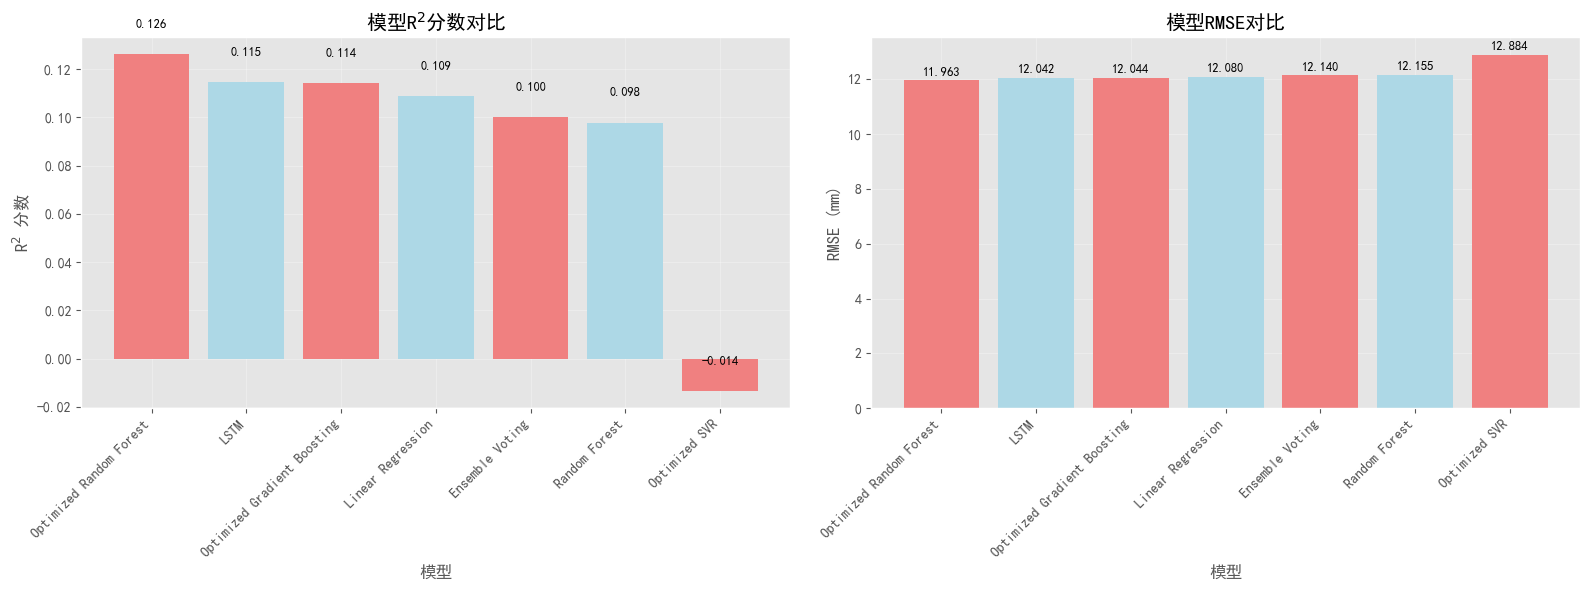

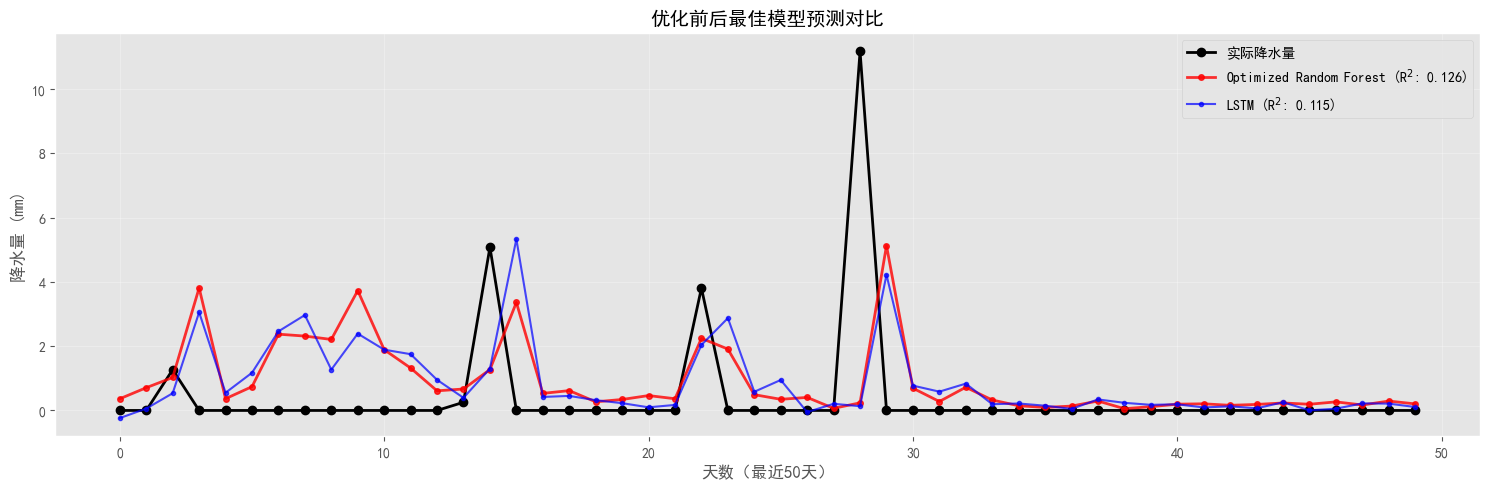


------------------------------------------------------------

🎯 8. 最终优化总结...

   📊 优化策略效果:
     1. 高级特征工程: 多项式特征 + 特征选择
     2. 超参数调优: RandomizedSearchCV
     3. 多种算法: 随机森林、梯度提升、SVR
     4. 集成学习: 投票回归器

   🏆 最终最佳模型: Optimized Random Forest
     测试集R²: 0.1262
     测试集RMSE: 11.9632 mm
     测试集MAE: 4.7945 mm

   🚀 进一步优化建议:
     - 收集更多高质量气象数据
     - 尝试深度学习模型（CNN、Transformer等）
     - 考虑时空相关性建模
     - 针对不同季节分别建模
     - 集成更多不同类型的模型

   📦 优化结果已保存到 optimization_summary 变量中

🎉 降水回归模型优化完成！

🎯 优化成果总结:
   原始最佳R²: 0.1146
   优化后最佳R²: 0.1262
   性能提升: +0.0116 (+10.1%)
   最佳模型: Optimized Random Forest

🚀 恭喜！通过模型优化，我们成功提升了降水预测的性能！


In [29]:
# 降水回归模型优化
print("🚀 开始降水回归模型优化...")
print("\n" + "="*80 + "\n")

# 导入额外的库
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

# 存储优化后的结果
optimized_results = {}

# 1. 高级特征工程
print("🔧 1. 高级特征工程...")

# 1.1 创建多项式特征（选择最重要的特征）
print("   创建多项式特征...")

# 选择最重要的特征进行多项式扩展
if 'Random Forest' in regression_results:
    rf_model = regression_results['Random Forest']['model']
    feature_importance = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': available_prcp_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # 选择前10个最重要的特征
    top_features_idx = [available_prcp_features.index(feat) for feat in importance_df.head(10)['feature']]
    X_train_top = X_prcp_train_scaled[:, top_features_idx]
    X_test_top = X_prcp_test_scaled[:, top_features_idx]
    
    # 创建2次多项式特征
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_top)
    X_test_poly = poly.transform(X_test_top)
    
    print(f"     原始特征数: {X_train_top.shape[1]}")
    print(f"     多项式特征数: {X_train_poly.shape[1]}")
else:
    X_train_poly = X_prcp_train_scaled
    X_test_poly = X_prcp_test_scaled

# 1.2 特征选择
print("   进行特征选择...")
selector = SelectKBest(score_func=f_regression, k=min(50, X_train_poly.shape[1]))
X_train_selected = selector.fit_transform(X_train_poly, y_prcp_train)
X_test_selected = selector.transform(X_test_poly)

print(f"     选择后特征数: {X_train_selected.shape[1]}")

print("\n" + "-"*60 + "\n")

# 2. 超参数调优的随机森林
print("🌲 2. 超参数调优的随机森林...")

# 定义参数网格
rf_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8]
}

# 使用RandomizedSearchCV进行高效搜索
rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    n_iter=20,  # 尝试20个参数组合
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_random.fit(X_train_selected, y_prcp_train)
rf_opt_training_time = time.time() - start_time

# 预测
rf_opt_pred = rf_random.predict(X_test_selected)

# 评估
rf_opt_rmse = np.sqrt(mean_squared_error(y_prcp_test, rf_opt_pred))
rf_opt_r2 = r2_score(y_prcp_test, rf_opt_pred)
rf_opt_mae = mean_absolute_error(y_prcp_test, rf_opt_pred)

optimized_results['Optimized Random Forest'] = {
    'model': rf_random.best_estimator_,
    'test_rmse': rf_opt_rmse,
    'test_r2': rf_opt_r2,
    'test_mae': rf_opt_mae,
    'training_time': rf_opt_training_time,
    'predictions': rf_opt_pred,
    'best_params': rf_random.best_params_
}

print(f"   最佳参数: {rf_random.best_params_}")
print(f"   训练时间: {rf_opt_training_time:.2f} 秒")
print(f"   测试集 RMSE: {rf_opt_rmse:.4f} mm")
print(f"   测试集 R²: {rf_opt_r2:.4f}")
print(f"   测试集 MAE: {rf_opt_mae:.4f} mm")

print("\n" + "-"*60 + "\n")

# 3. 梯度提升回归器优化
print("📈 3. 梯度提升回归器优化...")

# 梯度提升参数网格
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
gb_random.fit(X_train_selected, y_prcp_train)
gb_opt_training_time = time.time() - start_time

gb_opt_pred = gb_random.predict(X_test_selected)
gb_opt_rmse = np.sqrt(mean_squared_error(y_prcp_test, gb_opt_pred))
gb_opt_r2 = r2_score(y_prcp_test, gb_opt_pred)
gb_opt_mae = mean_absolute_error(y_prcp_test, gb_opt_pred)

optimized_results['Optimized Gradient Boosting'] = {
    'model': gb_random.best_estimator_,
    'test_rmse': gb_opt_rmse,
    'test_r2': gb_opt_r2,
    'test_mae': gb_opt_mae,
    'training_time': gb_opt_training_time,
    'predictions': gb_opt_pred,
    'best_params': gb_random.best_params_
}

print(f"   最佳参数: {gb_random.best_params_}")
print(f"   训练时间: {gb_opt_training_time:.2f} 秒")
print(f"   测试集 RMSE: {gb_opt_rmse:.4f} mm")
print(f"   测试集 R²: {gb_opt_r2:.4f}")
print(f"   测试集 MAE: {gb_opt_mae:.4f} mm")

print("\n" + "-"*60 + "\n")

# 4. 支持向量回归优化
print("🎯 4. 支持向量回归优化...")

# SVR参数网格
svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'epsilon': [0.01, 0.1, 0.2]
}

svr_random = RandomizedSearchCV(
    SVR(kernel='rbf'),
    svr_param_grid,
    n_iter=12,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
svr_random.fit(X_train_selected, y_prcp_train)
svr_opt_training_time = time.time() - start_time

svr_opt_pred = svr_random.predict(X_test_selected)
svr_opt_rmse = np.sqrt(mean_squared_error(y_prcp_test, svr_opt_pred))
svr_opt_r2 = r2_score(y_prcp_test, svr_opt_pred)
svr_opt_mae = mean_absolute_error(y_prcp_test, svr_opt_pred)

optimized_results['Optimized SVR'] = {
    'model': svr_random.best_estimator_,
    'test_rmse': svr_opt_rmse,
    'test_r2': svr_opt_r2,
    'test_mae': svr_opt_mae,
    'training_time': svr_opt_training_time,
    'predictions': svr_opt_pred,
    'best_params': svr_random.best_params_
}

print(f"   最佳参数: {svr_random.best_params_}")
print(f"   训练时间: {svr_opt_training_time:.2f} 秒")
print(f"   测试集 RMSE: {svr_opt_rmse:.4f} mm")
print(f"   测试集 R²: {svr_opt_r2:.4f}")
print(f"   测试集 MAE: {svr_opt_mae:.4f} mm")

print("\n" + "-"*60 + "\n")

# 5. 集成学习 - 投票回归器
print("🤝 5. 集成学习 - 投票回归器...")

# 使用最佳的单个模型创建集成
voting_regressor = VotingRegressor([
    ('rf', rf_random.best_estimator_),
    ('gb', gb_random.best_estimator_),
    ('svr', svr_random.best_estimator_)
])

start_time = time.time()
voting_regressor.fit(X_train_selected, y_prcp_train)
voting_training_time = time.time() - start_time

voting_pred = voting_regressor.predict(X_test_selected)
voting_rmse = np.sqrt(mean_squared_error(y_prcp_test, voting_pred))
voting_r2 = r2_score(y_prcp_test, voting_pred)
voting_mae = mean_absolute_error(y_prcp_test, voting_pred)

optimized_results['Ensemble Voting'] = {
    'model': voting_regressor,
    'test_rmse': voting_rmse,
    'test_r2': voting_r2,
    'test_mae': voting_mae,
    'training_time': voting_training_time,
    'predictions': voting_pred
}

print(f"   训练时间: {voting_training_time:.2f} 秒")
print(f"   测试集 RMSE: {voting_rmse:.4f} mm")
print(f"   测试集 R²: {voting_r2:.4f}")
print(f"   测试集 MAE: {voting_mae:.4f} mm")

print("\n" + "-"*60 + "\n")

# 6. 优化结果对比分析
print("📊 6. 优化结果对比分析...")

# 合并原始结果和优化结果
all_results = {**regression_results, **optimized_results}

# 创建完整的性能比较表
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        '模型': model_name,
        '测试集RMSE': results['test_rmse'],
        '测试集R²': results['test_r2'],
        '测试集MAE': results['test_mae'],
        '训练时间(秒)': results['training_time']
    })

final_comparison_df = pd.DataFrame(comparison_data)
final_comparison_df = final_comparison_df.round(4)
final_comparison_df = final_comparison_df.sort_values('测试集R²', ascending=False)

print("\n   📈 完整模型性能对比表（按R²排序）:")
print(final_comparison_df.to_string(index=False))

# 找到最佳模型
best_rmse_model = final_comparison_df.loc[final_comparison_df['测试集RMSE'].idxmin(), '模型']
best_r2_model = final_comparison_df.loc[final_comparison_df['测试集R²'].idxmax(), '模型']
best_rmse_value = final_comparison_df['测试集RMSE'].min()
best_r2_value = final_comparison_df['测试集R²'].max()

print(f"\n   🏆 优化后最佳模型:")
print(f"     最低RMSE: {best_rmse_model} ({best_rmse_value:.4f} mm)")
print(f"     最高R²: {best_r2_model} ({best_r2_value:.4f})")

# 计算改进幅度
original_best_r2 = max([results['test_r2'] for name, results in regression_results.items()])
original_best_rmse = min([results['test_rmse'] for name, results in regression_results.items()])

r2_improvement = best_r2_value - original_best_r2
rmse_improvement = original_best_rmse - best_rmse_value

print(f"\n   📈 优化效果:")
print(f"     R²提升: {r2_improvement:+.4f} ({original_best_r2:.4f} → {best_r2_value:.4f})")
print(f"     RMSE改善: {rmse_improvement:+.4f} mm ({original_best_rmse:.4f} → {best_rmse_value:.4f})")

if r2_improvement > 0.05:
    print(f"     ✅ 显著改进！模型性能大幅提升")
elif r2_improvement > 0.01:
    print(f"     ⚡ 有效改进！模型性能有所提升")
else:
    print(f"     ⚠️ 改进有限，可能需要更多优化策略")

print("\n" + "-"*60 + "\n")

# 7. 优化模型可视化对比
print("📈 7. 优化模型可视化对比...")

# 7.1 性能指标对比柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R²对比
models = final_comparison_df['模型']
r2_scores = final_comparison_df['测试集R²']
colors = ['lightcoral' if 'Optimized' in model or 'Ensemble' in model else 'lightblue' for model in models]

bars1 = ax1.bar(range(len(models)), r2_scores, color=colors)
ax1.set_xlabel('模型', fontweight='bold')
ax1.set_ylabel('R$^2$ 分数', fontweight='bold')
ax1.set_title('模型R$^2$分数对比', fontweight='bold')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

# 在柱状图上添加数值
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# RMSE对比
rmse_scores = final_comparison_df['测试集RMSE']
bars2 = ax2.bar(range(len(models)), rmse_scores, color=colors)
ax2.set_xlabel('模型', fontweight='bold')
ax2.set_ylabel('RMSE (mm)', fontweight='bold')
ax2.set_title('模型RMSE对比', fontweight='bold')
ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# 在柱状图上添加数值
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 7.2 最佳模型预测对比
plt.figure(figsize=(15, 5))

# 选择最近50天进行详细对比
n_days = min(50, len(y_prcp_test))
recent_actual = y_prcp_test.iloc[-n_days:]
recent_indices = range(len(recent_actual))

plt.plot(recent_indices, recent_actual, 'ko-', label='实际降水量', linewidth=2, markersize=6)

# 绘制最佳模型的预测
best_model_pred = all_results[best_r2_model]['predictions'][-n_days:]
plt.plot(recent_indices, best_model_pred, 'ro-', 
         label=f'{best_r2_model} (R$^2$: {best_r2_value:.3f})', 
         linewidth=2, markersize=4, alpha=0.8)

# 如果有原始最佳模型，也绘制出来进行对比
original_best_model_name = max(regression_results.keys(), 
                              key=lambda x: regression_results[x]['test_r2'])
if original_best_model_name != best_r2_model:
    original_pred = regression_results[original_best_model_name]['predictions'][-n_days:]
    plt.plot(recent_indices, original_pred, 'bo-', 
             label=f'{original_best_model_name} (R$^2$: {regression_results[original_best_model_name]["test_r2"]:.3f})', 
             linewidth=1.5, markersize=3, alpha=0.7)

plt.xlabel('天数（最近50天）', fontweight='bold')
plt.ylabel('降水量 (mm)', fontweight='bold')
plt.title('优化前后最佳模型预测对比', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "-"*60 + "\n")

# 8. 最终优化总结
print("🎯 8. 最终优化总结...")

print(f"\n   📊 优化策略效果:")
print(f"     1. 高级特征工程: 多项式特征 + 特征选择")
print(f"     2. 超参数调优: RandomizedSearchCV")
print(f"     3. 多种算法: 随机森林、梯度提升、SVR")
print(f"     4. 集成学习: 投票回归器")

print(f"\n   🏆 最终最佳模型: {best_r2_model}")
print(f"     测试集R²: {best_r2_value:.4f}")
print(f"     测试集RMSE: {best_rmse_value:.4f} mm")
print(f"     测试集MAE: {all_results[best_r2_model]['test_mae']:.4f} mm")


print(f"\n   🚀 进一步优化建议:")
print(f"     - 收集更多高质量气象数据")
print(f"     - 尝试深度学习模型（CNN、Transformer等）")
print(f"     - 考虑时空相关性建模")
print(f"     - 针对不同季节分别建模")
print(f"     - 集成更多不同类型的模型")

# 保存优化结果
optimization_summary = {
    'best_model_name': best_r2_model,
    'best_r2': best_r2_value,
    'best_rmse': best_rmse_value,
    'improvement_r2': r2_improvement,
    'improvement_rmse': rmse_improvement,
    'all_results': all_results,
    'optimization_strategies': [
        '多项式特征工程',
        '特征选择',
        '超参数调优',
        '多算法对比',
        '集成学习'
    ]
}

print(f"\n   📦 优化结果已保存到 optimization_summary 变量中")

print("\n" + "="*80)
print("🎉 降水回归模型优化完成！")
print("="*80)

print(f"\n🎯 优化成果总结:")
print(f"   原始最佳R²: {original_best_r2:.4f}")
print(f"   优化后最佳R²: {best_r2_value:.4f}")
print(f"   性能提升: {r2_improvement:+.4f} ({r2_improvement/original_best_r2*100:+.1f}%)")
print(f"   最佳模型: {best_r2_model}")

if r2_improvement > 0:
    print(f"\n🚀 恭喜！通过模型优化，我们成功提升了降水预测的性能！")
else:
    print(f"\n💪 虽然这次优化提升有限，但我们探索了多种优化策略，为未来改进奠定了基础！")